In [1]:
# Functions and packages

from functions import *
from src.utils import *
import matplotlib.pyplot as plt
set_rcParams()

import pickle as pkl

# from pingouin import multivariate_normality # It uses the Henze-Zirkler test [https://www.tandfonline.com/doi/abs/10.1080/03610929008830400]
from scipy.stats import pearsonr, spearmanr, kendalltau, permutation_test

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

import seaborn as sns

In [2]:
# FIXED PATHS

FOLDER_SIMULATION_DATA = os.path.join(os.path.abspath(os.path.join('.', os.pardir)), 'CASE_STUDY_DHNs_copy_here')
JULIA_RESULTS_FOLDER = os.path.join(os.path.abspath(os.path.join(os.path.abspath(os.path.join('.', os.pardir)), os.pardir)), 'HeatGrid (Julia code)', 'HeatGrid', 'heatgrid', 'networks_study')

### Functions

In [3]:
# Functions required

## Helpers

from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.linear_model import LogisticRegression
def compute_goodness_thresholds(intercept, coefficients, variables, other_values=None):
    """
    Compute individual thresholds for variables where goodness switches between 0 and 1.
    
    Parameters:
    - intercept (float): The intercept (b_0) of the logistic regression model.
    - coefficients (list): List of coefficients for each variable.
    - variables (list): List of variable names (for labeling).
    - other_values (dict, optional): Values to fix other variables at (default is 0 for all).
    
    Returns:
    - dict: Thresholds for each variable where goodness switches (log-odds = 0).
    """
    if len(coefficients) != len(variables):
        raise ValueError("Number of coefficients must match number of variables.")
    
    # Default to setting all other variables to 0 if not specified
    if other_values is None:
        other_values = {var: 0 for var in variables}
    
    thresholds = {}
    
    # Equation: intercept + sum(coef[i] * var[i]) = 0
    for i, (coef, var) in enumerate(zip(coefficients, variables)):
        # Compute the contribution of all other variables
        other_contribution = sum(coef_j * other_values[var_j] 
                                for j, (coef_j, var_j) in enumerate(zip(coefficients, variables)) 
                                if j != i)
        
        # Solve for the current variable: coef[i] * var[i] + other_contribution + intercept = 0
        # var[i] = -(intercept + other_contribution) / coef[i]
        if coef == 0:
            thresholds[var] = None  # No threshold if coefficient is 0
        else:
            threshold = -(intercept + other_contribution) / coef
            thresholds[var] = threshold
    
    return thresholds

def compute_mutual_information(df, col_x, col_y):
    x = df[[col_x]].values  # Feature (must be 2D)
    y = df[col_y].values    # Target (1D)
    
    mi = mutual_info_regression(x, y, random_state=42)  # For continuous target
    return mi[0]  # mutual_info_regression returns an array, extract first value

def compute_mutual_information_classif(df, col_x, col_y):
    x = df[[col_x]].values  # Feature (must be 2D)
    y = df[col_y].astype('category').cat.codes.values  # Convert to numerical labels
    
    mi = mutual_info_classif(x, y, random_state=42)  # For classification tasks
    return mi[0]  

def pareto_front(points, dominate_function, x_threshold=1e-4, y_threshold=1e-1):
    """
    Compute the Pareto front for a set of 2D points using the divide-and-conquer approach.
    
    Parameters:
    points (numpy array): An array of shape (n, 3) where each row represents a point (x, y, i) with i the index from original data
    
    Returns:
    pareto_points (numpy array): The Pareto front, a subset of the input points.
    indexes (list): Indices of the pareto font points within the original dataset
    """
    
    # Sort points by the first value (x-coordinate) ascending
    points = points[points[:, 0].argsort()]
    
    def recursive_pareto(points):
        # Base case: if there's one point, it's Pareto-optimal
        if len(points) == 1:
            return points
        
        # Split points into two halves
        mid = len(points) // 2
        left_points = points[:mid]
        right_points = points[mid:]
        
        # Recursively find Pareto fronts for left and right halves
        pareto_left = recursive_pareto(left_points)
        pareto_right = recursive_pareto(right_points)
        
        # Keep only the non-dominated points from both halves
        pareto_front = []
        
        # Keep all left points, they are already sorted and can't be dominated by any right point
        pareto_front.extend(pareto_left)
        
        for right_point in pareto_right:
            dominated = False
            for left_point in pareto_left:
                if dominate_function(right_point, left_point, x_threshold, y_threshold): #right point dominated by left
                    dominated = True
                    break
        
            if not dominated:
                pareto_front.append(right_point)
                
        return np.array(pareto_front)
    
    # Start the recursion
    pareto_points = recursive_pareto(points)
    
    return pareto_points

def get_producers_indices(dhn, id, new_dhns=True):
    if not new_dhns and id in [1,2,3,4]:
        return get_network_producers_nodes_indices(id)
    else:
        return [int(i)-1 for i in dhn.producer_nodes] # python indexed
    
def get_dhn(id: int) -> DistrictHeatingNetworkFromExcel:
    # study_dhn_folder = os.path.join(os.path.abspath(os.path.join('.', os.pardir)), 'CASE_STUDY_DHNs_copy_here')
    simu_file = os.path.join(FOLDER_SIMULATION_DATA, f'network_{id}', f'dataset_v2_tss_variable_trc_random_net{id}.mat')
    if not os.path.isfile(simu_file):
        raise Exception(f'DHN {id} missing file - Data File {simu_file} not found! ')

    excel_file = os.path.join(FOLDER_SIMULATION_DATA, f'network_{id}', f'case_study_topology_{id}.xlsx')
    if not os.path.isfile(excel_file):
        raise Exception(f'DHN {id} missing file - Topology File {excel_file} not found! ')
    
    dhn = DistrictHeatingNetworkFromExcel(excel_file, simu_file, transient_delay_in_time_step=0, last_limit_simulation=60, version_topology_file=1)   
    return dhn

def get_synthetic_dhn(id) -> DistrictHeatingNetworkFromExcel :
    # study_dhn_folder = os.path.join(os.path.abspath(os.path.join('.', os.pardir)), 'CASE_STUDY_DHNs_copy_here')
    study_dhn_folder = JULIA_RESULTS_FOLDER
    simu_file = os.path.join(study_dhn_folder, f'synthetic_dhn_{id}', 'simulation_results_v2.mat')
    if not os.path.isfile(simu_file):
        raise Exception(f'Synthetic DHN {id} missing file - Data File {simu_file} not found! ')

    excel_file = os.path.join(study_dhn_folder, f'synthetic_dhn_{id}', 'topology.xlsx')
    if not os.path.isfile(excel_file):
        raise Exception(f'Synthetic DHN {id} missing file - Topology File {excel_file} not found! ')
    
    excel = pd.read_excel(excel_file, sheet_name=['nodes', 'pipes', 'consumers(area)'])
    
    excel['nodes'].columns = ['Node', 'x', 'y', 'Is source']
    excel['pipes'].columns = ['start node', 'end node', 'Diameter', 'h', 'length']
    
    new_topology_file_to_use = os.path.join(study_dhn_folder, f'synthetic_dhn_{id}', 'topology_dhn.xlsx')
    
    with pd.ExcelWriter(new_topology_file_to_use, engine='openpyxl') as writer:
        for sheet, df in excel.items():
            # Write back to Excel
            df.to_excel(writer, sheet_name=sheet, index=False)
            
    dhn = DistrictHeatingNetworkFromExcel(new_topology_file_to_use, simu_file, transient_delay_in_time_step=0, last_limit_simulation=300, version_topology_file=2)   
    return dhn

def pickle_dhn(dhn, file_path):
    with open(file_path, 'wb') as file:
        pkl.dump(dhn, file, pkl.HIGHEST_PROTOCOL)
        
def read_dhn_pickled(file_path):
    dhn = None
    with open(file_path, 'rb') as file:
        dhn = pkl.load(file)
    return dhn

def _merge_clusters(cluster_1: list[int], cluster_2: list[int]):
    merged_cluster = cluster_1.copy()
    merged_cluster.extend(cluster_2)
    return merged_cluster

def _is_clusters_connected(cluster_a: list[int], cluster_b: list[int], edge_labels: dict):
    for a in cluster_a:
        for b in cluster_b:
            if (a,b) in edge_labels or (b,a) in edge_labels: #!! edge labels are not inversed by flux directions
                return True
            
    return False

def _get_in_out_degree_cluster(cluster: list[int], dhn: DistrictHeatingNetworkFromExcel):
    cluster_ = [i+1 for i in cluster]
    ins, in_, out_, _ = dhn.get_cluster_qualities_and_identify_connecting_pipes(cluster_)
    return len(in_), len(out_), len(ins)+len(in_)+len(out_) 
    
def _get_cut_size_cluster(cluster: list[int], dhn: DistrictHeatingNetworkFromExcel):
    in_, out_, total_edges = _get_in_out_degree_cluster(cluster, dhn)
    return in_ + out_, total_edges

def _has_source(cluster_a:list, sources: list):
    # Readability is prefered than efficiency here
    for el in sources: # starts with sources as they have fewer elements
        if el in cluster_a:
            return True
    return False

def _get_shortest_paths_between_nodes(graph_dhn, dhn, source_node, target_node):
    list_pair_nodes = []
    if nx.has_path(graph_dhn, source_node, target_node):
        u = source_node
        v = target_node
    elif nx.has_path(graph_dhn, target_node, source_node):
        v = source_node
        u = target_node
    else:
        return list_pair_nodes

    shortest_paths = nx.all_shortest_paths(graph_dhn, u, v)
    previous_node = u
    for node_on_path in shortest_paths:
        if node_on_path == u:
            continue
        list_pair_nodes = [previous_node, node_on_path]
        previous_node = node_on_path
                
    return list_pair_nodes
    
def _create_list_clusters_from_labels_clustering(clustering_labels):
    clusters = {}
    for i, cl in enumerate(clustering_labels):
        if cl not in clusters:
            clusters[cl] = []
        clusters[cl].append(i)
    return list(clusters.values())

def _literal_eval_clustering_labels_list(cluster_labels_already_in_list):
    label_list = ast.literal_eval(cluster_labels_already_in_list)
    clusters = {}
    for node, cl_label in enumerate(label_list):
        if cl_label not in clusters:
            clusters[cl_label] = []
        clusters[cl_label].append(node)
        
    return clusters

def _create_list_clusters_from_labels_in_string(clusters_labels):
    clusters = {}
    try:
        labels = clusters_labels
        cleaned_label_str = labels.replace("[", "").replace("]", "").replace("\n", "")
        label_list_str = cleaned_label_str.split()
        label_list = [int(num) for num in label_list_str]
    except Exception:
        label_list = clusters_labels

    for node, cl_label in enumerate(label_list):
        if cl_label not in clusters:
            clusters[cl_label] = []
        clusters[cl_label].append(node)
        
    return clusters

## Distances functions
def _compute_manhattan_distance_between_time_series(time_serie_a, time_serie_b):
    return np.sum(np.abs(time_serie_a - time_serie_b)) / len(time_serie_a)

def _compute_total_ts_tr_signals_distances(dhn: DistrictHeatingNetworkFromExcel, edge_index: int, use_nodes_signals=False):
    
    if use_nodes_signals:
        (node_a_idx, node_b_indx) = dhn.edges_nodes[edge_index]
        dist_ts = _compute_manhattan_distance_between_time_series(dhn.dict_physical_values['Ts_node'][node_a_idx,:], dhn.dict_physical_values['Ts_node'][node_b_indx,:]) 
        dist_tr = _compute_manhattan_distance_between_time_series(dhn.dict_physical_values['Tr_node'][node_a_idx,:], dhn.dict_physical_values['Tr_node'][node_b_indx,:])
    else:
        ts1 = dhn.dict_physical_values['Tsin'][edge_index,:]
        ts2 = dhn.dict_physical_values['Tsout'][edge_index,:]
        dist_ts = np.mean(np.abs(dhn.dict_physical_values['mw'][edge_index,:])) * _compute_manhattan_distance_between_time_series(ts1, ts2)
        tr1 = dhn.dict_physical_values['Trin'][edge_index,:]
        tr2 = dhn.dict_physical_values['Trout'][edge_index,:]
        dist_tr = np.mean(np.abs(dhn.dict_physical_values['mw'][edge_index,:])) * _compute_manhattan_distance_between_time_series(tr1, tr2)
    
    return dist_ts + dist_tr

def compute_distance_topology_between_(cluster_a: list[int], cluster_b: list[int], dhn: DistrictHeatingNetworkFromExcel, gamma: float):
    merged = _merge_clusters(cluster_a, cluster_b)
    inc_degree, out_degree, _ = _get_in_out_degree_cluster(cluster=merged, dhn=dhn)
    distance = gamma*(inc_degree) + (1-gamma)*(out_degree)
    return distance

def compute_distance_temperatures_between_(cluster_a: list[int], cluster_b: list[int], dhn: DistrictHeatingNetworkFromExcel):
    min_dist = 100
    if len(cluster_a) == 1:
        nd = cluster_a[0]
        incoming_edges = set(dhn.edge_features_v2[dhn.edge_features_v2['end node'] == nd].index)
        outgoing_edges = set(dhn.edge_features_v2[dhn.edge_features_v2['start node'] == nd].index)
    else:
        _, incoming_edges, outgoing_edges, _ = dhn.get_cluster_qualities_and_identify_connecting_pipes([i+1 for i in cluster_a])

    for e in incoming_edges:
        (st, ed) = dhn.edges_nodes[e] # as ed in cluster a
        if st in cluster_b:
            distance = _compute_total_ts_tr_signals_distances(dhn, e, use_nodes_signals=False)
            if distance < min_dist:
                min_dist = distance
        
    for e in outgoing_edges:
        (st, ed) = dhn.edges_nodes[e] # as st in cluster a
        if ed in cluster_b:
            distance = _compute_total_ts_tr_signals_distances(dhn, e, use_nodes_signals=False)
            if distance < min_dist:
                min_dist = distance
                
    return min_dist

def compute_distance_matrices(sources: list, clusters: list, dhn: DistrictHeatingNetworkFromExcel, gamma: float, normalization_norm= 'inf'):
    topology_distance_matrix = np.zeros(shape=(len(clusters), len(clusters))) # 1 value to not merge the clusters
    temperatures_distance_matrix = np.zeros(shape=(len(clusters), len(clusters))) # 1 value to not merge the clusters
    np.fill_diagonal(topology_distance_matrix, 0)
    np.fill_diagonal(temperatures_distance_matrix, 0)
    
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            if i == j:
                continue
            cluster_i = clusters[i]
            cluster_j = clusters[j]
            if _is_clusters_connected(cluster_a=cluster_i, cluster_b=cluster_j, edge_labels=dhn.edge_labels):
                merged = _merge_clusters(cluster_i, cluster_j)
                if _has_source(cluster_i, sources) or _has_source(cluster_j, sources) or assess_inversion_flux([i+1 for i in merged], dhn):
                    dist_topology = 0.0
                    dist_temperatures = 0.0
                else:
                    dist_topology = compute_distance_topology_between_(cluster_i, cluster_j, dhn=dhn, gamma=gamma)
                    dist_temperatures = compute_distance_temperatures_between_(cluster_i, cluster_j, dhn)
                
                topology_distance_matrix[i, j] = dist_topology
                temperatures_distance_matrix[i, j] = dist_temperatures
            else:
                topology_distance_matrix[i, j] = 0.0
                temperatures_distance_matrix[i, j] = 0.0
    
    # Normalization
    if normalization_norm == 'inf':
        topology_distance_matrix /= np.max(topology_distance_matrix)
        temperatures_distance_matrix /= np.max(temperatures_distance_matrix)
    else:
        topology_distance_matrix /= np.linalg.norm(topology_distance_matrix)
        temperatures_distance_matrix /= np.linalg.norm(temperatures_distance_matrix)
        
    topology_distance_matrix[topology_distance_matrix == 0.0] = 1.0
    temperatures_distance_matrix[temperatures_distance_matrix == 0.0] = 1.0 
    np.fill_diagonal(topology_distance_matrix, 0)
    np.fill_diagonal(temperatures_distance_matrix, 0)
        
    # Check symmetry
    if (topology_distance_matrix != topology_distance_matrix.T).all():
        raise Exception('Stopping error: distance topology matrix is not symmetric')
    
    if (temperatures_distance_matrix != temperatures_distance_matrix.T).all():
        raise Exception('Stopping error: distance topology matrix is not symmetric')
    
    return topology_distance_matrix, temperatures_distance_matrix

def compute_distance_matrix(sources: list, clusters: list, 
                            dhn: DistrictHeatingNetworkFromExcel, 
                            alpha: float, gamma: float, 
                            normalization_norm='inf'):
    
    distance_topology_matrix, distance_temperatures_matrix = compute_distance_matrices(sources=sources, clusters=clusters, dhn=dhn, gamma=gamma, normalization_norm=normalization_norm)
    distance_matrix = alpha*distance_topology_matrix + (1-alpha)*distance_temperatures_matrix
    return distance_matrix

def compute_new_distance_matrix(distance_matrix, graph):
    # use dijkstra algorith
    # we compute all shortest paths once for all
    n = distance_matrix.shape[0]
    new_distance_matrix = np.zeros_like(distance_matrix)
    for u in range(n):
        for v in range(u, n):
            if u == v:
                continue
            start_node = u
            for step_node in nx.shortest_path(graph.to_undirected(), u, v):
                new_distance_matrix[u,v] += distance_matrix[start_node, step_node]
                start_node = step_node
            new_distance_matrix[v,u] = new_distance_matrix[u, v]
    return new_distance_matrix


## Clustering results quality
def recompute_losses(df_data, dict_dhns):
    values = []
    for i, df_row in df_data.iterrows():
        clusters = _create_list_clusters_from_labels_in_string(df_row['clusters_labels'])
        dhn_id = df_row['dhn_id']
        dhn = dict_dhns[dhn_id]
        
        # Compute total losses of the network
        total_e_loss = 0
        for e, df_ in dhn.edge_features.iterrows():
            e_loss, e_in, e_out = compute_e_loss_through_edge(e, dhn)
            total_e_loss += e_loss
        
        total_e_demands = dhn.dict_physical_values['Demands'].sum()
        pw_losses = []
        pw_losses_perc_2 = []
        pw_losses_perc_3 = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                pw_loss, _, r_2, r_3 = compute_e_loss_through_cluster(cluster, dhn)
                pw_losses.append(pw_loss)   
                pw_losses_perc_2.append(r_2)   
                pw_losses_perc_3.append(r_3)
                
        mean_losses = np.mean(pw_losses) # W
        mean_losses_per_demanded_e = np.mean(pw_losses_perc_2) # %
        mean_losses_per_transit_e = np.mean(pw_losses_perc_3)
        mean_losses_per_total_demanded_dhn = 100* mean_losses / total_e_demands
        mean_losses_per_total_loss_dhn = 100 *mean_losses / total_e_loss
        values.append([mean_losses, mean_losses_per_demanded_e, mean_losses_per_transit_e, mean_losses_per_total_demanded_dhn, mean_losses_per_total_loss_dhn]) 
    return np.array(values)

def recompute_cut_ratio(df_data, dict_dhns):
    values = []
    for i, df_row in df_data.iterrows():
        clusters = _create_list_clusters_from_labels_in_string(df_row['clusters_labels'])
        dhn_id = df_row['dhn_id']
        dhn = dict_dhns[dhn_id]
        n_nodes = dhn.dict_physical_values['Demands'].shape[0]
        cut_ratios = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                cut, tt_edges = _get_cut_size_cluster(cluster=cluster, dhn=dhn)
                in_, out_, _ = _get_in_out_degree_cluster(cluster, dhn)
                ns = len(cluster)
                cut_ratio = cut / (ns*(n_nodes-ns))
                cut_ratios.append(cut_ratio)
        values.append(np.mean(cut_ratios))
    return np.array(values)

def compute_e_loss_through_edge(edge_idx, dhn: DistrictHeatingNetworkFromExcel):
    """Computes the thermal energy loss through an edge

    Args:
        edge_idx (int): the index of the edge
        dhn (DistrictHeatingNetworkFromExcel): the DHN
        
    Return:
        tuple: (thermal energy loss (W), thermal incoming energy, thermal outgoing energy)
    """
    p_in = np.abs(dhn.dict_physical_values['mw'][edge_idx,:]) * CP * (dhn.dict_physical_values['Tsin'][edge_idx,:] - dhn.dict_physical_values['Trout'][edge_idx,:])
    p_out = np.abs(dhn.dict_physical_values['mw'][edge_idx,:]) * CP * (dhn.dict_physical_values['Tsout'][edge_idx,:] - dhn.dict_physical_values['Trin'][edge_idx,:])
    e_in = np.sum(p_in)
    e_out = np.sum(p_out)
    e_loss = e_in - e_out
    return e_loss, e_in, e_out
    
def compute_e_loss_through_cluster(cluster: list, dhn: DistrictHeatingNetworkFromExcel):
    """Computes thermal losses of cluster

    Args:
        cluster (list): list of nodes in the cluster [python indexx]
        dhn (DistrictHeatingNetworkFromExcel): DHN parent of the clusters

    Returns:
        tuple: (real power losses, power losses / incoming power, power losses / total consumption, power losses / (incoming - outgoing))
    """

    cluster_to_use = [i+1 for i in cluster]
    _, incoming_pipes, outgoing_pipes, _ = dhn.get_cluster_qualities_and_identify_connecting_pipes(cluster_to_use)
    total_e_consumptions = np.abs(dhn.dict_physical_values['Real_Pc'][[i-1 for i in cluster_to_use],:]).sum() # Total energy consumed
    total_e_incomings = 0
    total_e_outgoings = 0
    
    for pipe_index in incoming_pipes:
        p_in = np.abs(dhn.dict_physical_values['mw'][pipe_index,:]) * CP * (dhn.dict_physical_values['Tsin'][pipe_index,:] - dhn.dict_physical_values['Trout'][pipe_index,:])
        total_e_incomings += p_in.sum()
    
    for pipe_index in outgoing_pipes:
        p_out = np.abs(dhn.dict_physical_values['mw'][pipe_index,:]) * CP * (dhn.dict_physical_values['Tsout'][pipe_index,:] - dhn.dict_physical_values['Trin'][pipe_index,:])
        total_e_outgoings += p_out.sum()

    total_e_losses = total_e_incomings - total_e_consumptions - total_e_outgoings
    cluster_thermal_losses_percentage = 100*total_e_losses / total_e_incomings
    cluster_thermal_losses_percentage_v2 = 100*total_e_losses / total_e_consumptions
    cluster_thermal_losses_percentage_v3 = 100*total_e_losses / (total_e_incomings - total_e_outgoings)

    return total_e_losses, cluster_thermal_losses_percentage, cluster_thermal_losses_percentage_v2, cluster_thermal_losses_percentage_v3

def compute_errors_in_energy(cluster, dhn, mae):
    
    cluster_to_use = cluster # clustering in julia index
    
    _, incoming_pipes, outgoing_pipes, _ = dhn.get_cluster_qualities_and_identify_connecting_pipes(cluster_to_use)
    total_e_consumptions = np.abs(dhn.dict_physical_values['Real_Pc'][[i-1 for i in cluster_to_use],:]).sum() # Total energy consumed
    total_e_incomings = 0
    total_e_outgoings = 0
    total_e_error = 0
    
    for pipe_index in incoming_pipes:
        p_in = np.abs(dhn.dict_physical_values['mw'][pipe_index,:]) * CP * (dhn.dict_physical_values['Tsin'][pipe_index,:] - dhn.dict_physical_values['Trout'][pipe_index,:])
        total_e_incomings += p_in.sum()
        total_e_error += np.sum(np.abs(dhn.dict_physical_values['mw'][pipe_index,:]) * CP * mae)
    
    for pipe_index in outgoing_pipes:
        p_out = np.abs(dhn.dict_physical_values['mw'][pipe_index,:]) * CP * (dhn.dict_physical_values['Tsout'][pipe_index,:] - dhn.dict_physical_values['Trin'][pipe_index,:])
        total_e_outgoings += p_out.sum()
        total_e_error += np.sum(np.abs(dhn.dict_physical_values['mw'][pipe_index,:]) * CP * mae)

    total_e_loss = total_e_incomings - total_e_consumptions - total_e_outgoings
    return total_e_error, 100* total_e_error / total_e_loss

from sklearn.metrics import silhouette_score

def compute_clustering_metrics(distance_matrix, clustering_labels, dhn: DistrictHeatingNetworkFromExcel):
    clusters_lists = _create_list_clusters_from_labels_clustering(clustering_labels)
    metrics = {}
    results_for_visualiazation = {}
    try:
        # Clustering labels are python indexed (0-base index)
        slh_score = silhouette_score(distance_matrix, clustering_labels, metric="precomputed", random_state=2)
        metrics['silhouette_score'] = slh_score

        clusters_e_losses = []
        clusters_cut_ratio = []
        clusters_types = []
        clusters_sizes = []
        
        cl_i = 1
        for cluster in clusters_lists: # clusters are in python indices
            if len(cluster) > 1:
                _, e_loss_perc, _, _ = compute_e_loss_through_cluster(cluster=cluster, dhn=dhn)
                cut, tt_edges = _get_cut_size_cluster(cluster=cluster, dhn=dhn)
                in_, out_, _ = _get_in_out_degree_cluster(cluster, dhn)
                results_for_visualiazation[f'cluster_{cl_i}'] = [i+1 for i in cluster]
                clusters_e_losses.append(e_loss_perc)
                clusters_cut_ratio.append(cut/tt_edges) # 
                clusters_types.append(f'{in_}-{out_}')
                clusters_sizes.append(len(cluster))
                cl_i += 1
                
        metrics['clusters_mean_size'] = np.mean(clusters_sizes)
        metrics['clusters_std_size'] = np.std(clusters_sizes)
        
        metrics['Types 1-0'] = len([typ for typ in clusters_types if typ == '1-0'])
        metrics['Types 1-1'] = len([typ for typ in clusters_types if typ == '1-1'])
        metrics['Higher cuts'] = len([typ for typ in clusters_types if (typ != '1-1' and typ != '1-0')])
        metrics['k-clusters'] = len(clusters_types)
        
    except Exception as ex:
        print(f'Exception clustering -- {ex}')
    
    return metrics, results_for_visualiazation

# Visualisation
def plot_dendrogram(model, h_cut, **kwargs):
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.axhline(y=h_cut, color='black', linestyle='--', label='cut line')
    plt.legend()
    plt.xlabel("Nodes")
    plt.ylabel("Distance merge")
    plt.title("Dendrogram of DHN studied")  # Adjust title based on your chosen linkage method
    plt.show()
        
def visualize_clusters_with_metrics(clusters_list, graph, dhn, producers, list_labels=None):
    # Visualization 
    net = graph
    pos = dhn.nodes_coordinates
    layout = {}
    node_labels = {}
    node_colors = {}
    for i in range(len(pos)):
        coor = pos[i]
        layout[i] = (coor[0], -1*coor[1])
        node_labels[i] = str(i+1)
        if i in producers:
            node_colors[i] = 'tab:red'
        else:
            node_colors[i] = 'tab:grey'

    edges_colors = []    
    edges_with_inversion = label_edges_with_flux_inversion(dhn)
    for e in edges_with_inversion:
        if edges_with_inversion[e] == 1:
            edges_colors.append('red')
        else:
            edges_colors.append('black')

    colors_to_use = ['blue', 'green', 'orange', 'cyan', 'magenta', 'deeppink', 'peru', 'slategray']
    cluster_node_colors = node_colors.copy()
    cluster_node_labels = node_labels.copy()
    if list_labels == None:
        i = 0
        for cl_label in clusters_list:
            if cl_label in ['icci', 'bcci']:
                continue
            cluster = clusters_list[cl_label] # with julia index
            for node in cluster:
                cluster_node_labels[node-1] = cl_label
                if i >= len(colors_to_use):
                    i = 0
                    cluster_node_colors[node-1] = colors_to_use[i]
                else:
                    cluster_node_colors[node-1] = colors_to_use[i]
            i += 1
    else:
        clusters = {}
        labels = list_labels
        cleaned_label_str = labels.replace("[", "").replace("]", "").replace("\n", "")
        label_list_str = cleaned_label_str.split()
        label_list = [int(num) for num in label_list_str]
        
        for node, cl_label in enumerate(label_list):
            if cl_label not in clusters:
                clusters[cl_label] = []
            clusters[cl_label].append(node)
        
        
        palette = sns.color_palette("tab10", len(clusters.keys()))
        i = 0
        for cl_label, cluster in clusters.items(): # clusters are in python index
            if len(cluster) <= 1:
                continue
            for node_index in cluster:
                cluster_node_labels[node_index] = f'K-{i+1}'
                cluster_node_colors[node_index] = palette[i]
            i += 1
    
    colors = list(cluster_node_colors.values())

    fig, ax = plt.subplots(figsize=(10,10))
    nx.draw_networkx(net, pos=layout, with_labels=False, node_size=40, nodelist=pos.keys(), 
                    edgelist=list(dhn.edges_nodes.values()),
                    node_color=list(cluster_node_colors.values()),
                    edge_color=edges_colors,
                    alpha=0.9, width=0.8, ax=ax)
    plt.show()

def visualize_clustering_result(dhn_id, dhn, graph, producers, distance_threshold, df_clustering_results, ):
    filtered_df = df_clustering_results[(df_clustering_results['height_cut'] == distance_threshold) & (df_clustering_results['dhn_id'] == dhn_id)].iloc[0]
    clustering_labels = filtered_df['clusters_labels']
    visualize_clusters_with_metrics([], graph, dhn, producers, list_labels=clustering_labels)

def get_useful_columns_names():
   list_ = ['height_cut','dhn_id','clusters_labels','silhouette_score','reduced_percentage_mean','reduced_percentage_std','reduced_percentage_z_98','corrected_cut_ratio','k-clusters','mean_perfs','errors_in_energy', 'errors_in_energy_per_loss','clustered_percentage','cpu_gain','cpu_ml_time','mean_power_losses_clusters','mean_losses_per_conso_clusters','mean_losses_per_power_transit_clusters','mean_losses_per_total_demands','mean_losses_per_total_losses_dhn']
   return list_
      
## Files paths
def get_training_graphs_result_csv_file():
    return os.path.join('data_results_xlsx_files', 'clustering_results_training_graphs_v2.csv')

def get_evaluation_graphs_result_csv_file():
    return os.path.join('data_results_xlsx_files', 'clustering_results_evaluation_graphs.csv')


# Computing Spearman coefficients

def detect_outliers_from_iqr(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    return (data < lower_bound) | (data > upper_bound)

def spearman_statistic(x, y):
    
    # The data (e.g., MAE, errors in energy) are not normally distributed.
    # Therefore Pearson correlation bivariate normality assumption may not be respected.
    # Therefore, we rely on Spearman correlation
    # To test the significance of the method, we can not use normal approximation as the samples are not too many (n < 500) [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html]
    # We use instead the "Permuatation test" [https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html]
    
    # dof = len(df_clusters_metrics_no_inversion['mae']) - 2
    # rs = spearmanr(df_clusters_metrics_no_inversion['mae'], df_clusters_metrics_no_inversion['density']).statistic
    # transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
    # return transformed
    return spearmanr(x, y).statistic

def pearson_statistic(x, y):
    return pearsonr(x, y).statistic

def compute_correalation_with_permutation_test(x, y, remove_outliers, method):
    x_ = x.to_numpy().copy()
    y_ = y.to_numpy().copy()
    
    if remove_outliers:
        outliers_indices = detect_outliers_from_iqr(y_)
        x_list = x_.tolist()
        x_ = np.array([x_list[i] for i in range(len(x_list)) if not outliers_indices[i]])
        y_list = y_.tolist()
        y_ = np.array([y_list[i] for i in range(len(y_list)) if not outliers_indices[i]])
    
    if method == 'pearson':
        ref = permutation_test((x_, y_), pearson_statistic, vectorized=False, alternative='two-sided', permutation_type='pairings')
    else:
        ref = permutation_test((x_, y_), spearman_statistic, vectorized=False, alternative='two-sided', permutation_type='pairings')
    
    return ref.statistic, ref.pvalue
    # print(f'--> Spearman rank correlation = {ref.statistic} with pvalue {ref.pvalue}')


## Retrieve clusters and ML performances

In [454]:
dhns_ids = [1, 2, 3, 4, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 137]
# {1: np.float64(0.39746107040467815), 2: np.float64(0.3940146446713929), 3: np.float64(0.417257469043411), 4: np.float64(0.2131283270840146), 100: np.float64(0.268648522103301), 101: np.float64(0.6386229367207658), 102: np.float64(0.5518876829654328), 103: np.float64(0.21510771891750985), 104: np.float64(0.5563659529354278), 105: np.float64(0.6860765172664001), 106: np.float64(0.02224451355391732), 108: np.float64(0.4704678630914729), 109: np.float64(-0.1483158734146705), 110: np.float64(0.025186802370080173), 111: np.float64(-0.3560331503652223), 112: np.float64(0.009654876717805697), 137: np.float64(0.03874939104364707)}
# dhns_ids_considered = [1, 2, 3, 4, 100, 101, 102, 103, 104, 105, 108, 110, 112]
dhns_ids_considered = [1, 2, 3, 4, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 137]

df_clusters_metrics = pd.DataFrame()
for dhn_id in dhns_ids_considered:
    # path_metric = os.path.join('new_clusters_paradigm_saved', f'dhn_{dhn_id}', 'clusters_metrics.csv')
    path_metric = os.path.join('new_clusters_paradigm_saved', f'clusters_metrics_dhn_{dhn_id}_new_energy_error.csv')
    df_ = pd.read_csv(path_metric, index_col=False)
    df_clusters_metrics = pd.concat([df_clusters_metrics, df_])
df_clusters_metrics_no_nan = df_clusters_metrics.dropna()
df_clusters_metrics_no_nan.head()

,key,nodes,size,cluster_has_loop,density,internal_degree,scaled_density,nodes_mean_internal_indegree,nodes_sum_internal_indegree,nodes_max_internal_indegree,...,max_delay_time,std_delay_time,median_delay_time,e_loss_wrt_energy_through,e_loss_wrt_energy_consumed,total_e_loss_wh,mean_ts_tr_distance,mean_demands_distance,mean_pipes_loss,dhn_id
0,K0,"[31, 32]",2,False,0.500000,1,1.0,0.500000,1,1,...,25.991422,0.000000,25.991422,2.569692,2.637467,7.976012e+07,8.055555,513996.753962,0.105795,1
1,K1,"[27, 41]",2,False,0.500000,1,1.0,0.500000,1,1,...,6.926858,0.000000,6.926858,2.190887,2.239962,8.951624e+07,2.189693,129327.827557,0.022448,1
2,K2,"[29, 53]",2,False,0.500000,1,1.0,0.500000,1,1,...,17.317788,0.000000,17.317788,3.043812,3.139368,9.279011e+07,6.146654,65926.207723,0.053523,1
3,K3,"[27, 41, 42]",3,False,0.333333,2,1.0,0.666667,2,1,...,23.425549,8.249346,15.176203,3.611776,3.747113,1.723939e+08,2.475904,220295.608764,0.042039,1
4,K4,"[8, 50]",2,False,0.500000,1,1.0,0.500000,1,1,...,0.548725,0.000000,0.548725,4.917372,5.171682,8.729696e+07,0.398690,79431.360421,0.001844,1


<Axes: xlabel='dhn_id', ylabel='mean_delay_time'>

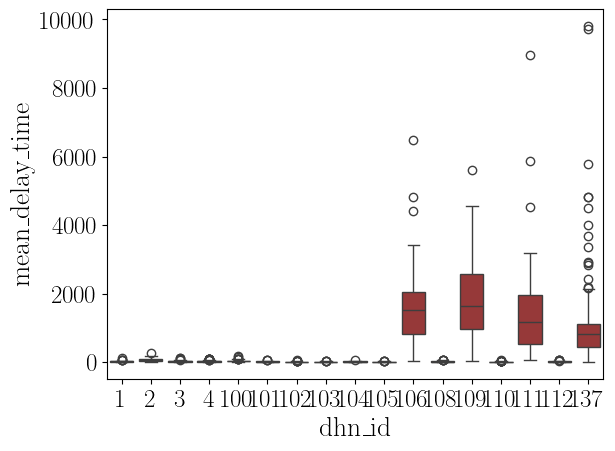

In [455]:
sns.boxplot(df_clusters_metrics_no_nan, x='dhn_id', y='mean_delay_time')

In [456]:
df_clusters_metrics_no_nan = df_clusters_metrics_no_nan[df_clusters_metrics_no_nan['dhn_id'].isin(dhns_ids_considered)]

<Axes: xlabel='dhn_id', ylabel='mean_delay_time'>

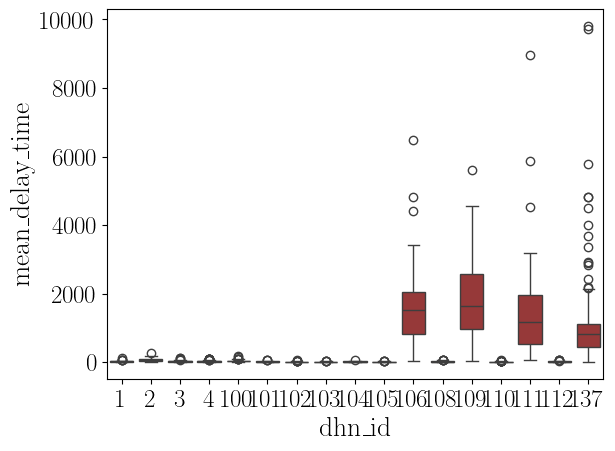

In [457]:
sns.boxplot(df_clusters_metrics_no_nan, x='dhn_id', y='mean_delay_time')

In [458]:
df_clusters_ml_performances = pd.DataFrame()
for dhn_id in dhns_ids_considered:
    path_metric = os.path.join('new_clusters_paradigm_saved', f'Condensated_learning_performances_with_energy_dhn_{dhn_id}_modified.csv')
    df_ = pd.read_csv(path_metric, index_col=0)
    df_clusters_ml_performances = pd.concat([df_clusters_ml_performances, df_])
# df_clusters_ml_performances = df_clusters_metrics.dropna()
df_clusters_ml_performances.head()

,unique_key,dhn_id,mae,energy_mae,energy_mare_per_loss,energy_loss_wh,cluster
0,K0,1,0.041671,7.690736e+08,16.070555,7.976012e+07,"[31, 32]"
1,K1,1,0.020201,8.975708e+08,16.711509,8.951624e+07,"[27, 41]"
2,K2,1,0.011192,6.476929e+08,11.633656,9.279011e+07,"[29, 53]"
3,K3,1,0.026725,1.160844e+09,11.222793,1.723939e+08,"[27, 41, 42]"
4,K4,1,0.008642,1.322107e+09,25.241564,8.729696e+07,"[8, 50]"


In [459]:
# Merge both tables
df_merged_tables = pd.merge(left=df_clusters_metrics_no_nan, right=df_clusters_ml_performances, how='inner',
                            left_on=['key', 'dhn_id'], right_on=['unique_key', 'dhn_id'])
df_merged_tables.head()

,key,nodes,size,cluster_has_loop,density,internal_degree,scaled_density,nodes_mean_internal_indegree,nodes_sum_internal_indegree,nodes_max_internal_indegree,...,mean_ts_tr_distance,mean_demands_distance,mean_pipes_loss,dhn_id,unique_key,mae,energy_mae,energy_mare_per_loss,energy_loss_wh,cluster
0,K0,"[31, 32]",2,False,0.500000,1,1.0,0.500000,1,1,...,8.055555,513996.753962,0.105795,1,K0,0.041671,7.690736e+08,16.070555,7.976012e+07,"[31, 32]"
1,K1,"[27, 41]",2,False,0.500000,1,1.0,0.500000,1,1,...,2.189693,129327.827557,0.022448,1,K1,0.020201,8.975708e+08,16.711509,8.951624e+07,"[27, 41]"
2,K2,"[29, 53]",2,False,0.500000,1,1.0,0.500000,1,1,...,6.146654,65926.207723,0.053523,1,K2,0.011192,6.476929e+08,11.633656,9.279011e+07,"[29, 53]"
3,K3,"[27, 41, 42]",3,False,0.333333,2,1.0,0.666667,2,1,...,2.475904,220295.608764,0.042039,1,K3,0.026725,1.160844e+09,11.222793,1.723939e+08,"[27, 41, 42]"
4,K4,"[8, 50]",2,False,0.500000,1,1.0,0.500000,1,1,...,0.398690,79431.360421,0.001844,1,K4,0.008642,1.322107e+09,25.241564,8.729696e+07,"[8, 50]"


In [460]:
df_merged_tables = df_merged_tables[df_merged_tables['energy_mae' ] > 0.0]
df_merged_tables['energy_error_mwh'] = 1e-6 * df_merged_tables['energy_mae'] * 60 / 3600
df_merged_tables['energy_loss_mwh'] = 1e-6 * df_merged_tables['energy_loss_wh']

In [461]:
goodness_energy_threshold = 5 # percent
goodness_mae_threshold = 0.1 # °C

In [462]:
df_merged_tables['energy_loss_mwh'] = df_merged_tables['energy_loss_mwh'].abs()
df_merged_tables['goodness_energy'] = df_merged_tables['energy_mare_per_loss'].apply(lambda x: 1 if x <= goodness_energy_threshold else 0)
df_merged_tables['goodness_mae'] = df_merged_tables['mae'].apply(lambda x: 1 if x <= goodness_mae_threshold else 0)

## Correlations study

In [463]:
print(f"Total {len(df_merged_tables)} clusters from {len(df_merged_tables['dhn_id'].unique())} DHNs")

Total 2694 clusters from 17 DHNs


In [464]:
print(f'Table columns: {df_merged_tables.columns}')

Table columns: Index(['key', 'nodes', 'size', 'cluster_has_loop', 'density',
       'internal_degree', 'scaled_density', 'nodes_mean_internal_indegree',
       'nodes_sum_internal_indegree', 'nodes_max_internal_indegree',
       'nodes_mean_internal_outdegree', 'nodes_sum_internal_outdegree',
       'nodes_max_internal_outdegree', 'nodes_mean_internal_degree',
       'nodes_sum_internal_degree', 'nodes_max_internal_degree',
       'average_outdegree_fraction', 'max_outdegree_fraction',
       'average_indegree_fraction', 'max_indegree_fraction', 'cut_size',
       'cut_ratio', 'conductance', 'nb_upstream_interfaces',
       'nb_downstream_interfaces', 'max_diameter', 'mean_delay_time',
       'min_delay_time', 'max_delay_time', 'std_delay_time',
       'median_delay_time', 'e_loss_wrt_energy_through',
       'e_loss_wrt_energy_consumed', 'total_e_loss_wh', 'mean_ts_tr_distance',
       'mean_demands_distance', 'mean_pipes_loss', 'dhn_id', 'unique_key',
       'mae', 'energy_mae', 'ener

In [465]:
df_merged_tables['total_interfaces'] = df_merged_tables['nb_upstream_interfaces'] + df_merged_tables['nb_downstream_interfaces']

In [466]:
df_merged_tables = df_merged_tables[df_merged_tables['mae'] < 1.0]
print(f'Number of clusters without outliers {len(df_merged_tables)}')

Number of clusters without outliers 2641


In [467]:
df_merged_tables['energy_mare_per_loss'] = df_merged_tables['energy_mare_per_loss'].abs()
df_merged_tables_new = df_merged_tables.copy()
df_merged_tables_new['cut_size_modified'] = df_merged_tables_new['cut_size'].apply(lambda x: x if x < 5 else 5)
df_merged_tables_new['total_interfaces_modified'] = df_merged_tables_new['total_interfaces'].apply(lambda x: x if x < 5 else 5)

In [468]:
# {1: np.float64(0.39746107040467815), 2: np.float64(0.3940146446713929), 3: np.float64(0.417257469043411), 4: np.float64(0.2131283270840146), 100: np.float64(0.268648522103301), 101: np.float64(0.6386229367207658), 102: np.float64(0.5518876829654328), 103: np.float64(0.21510771891750985), 104: np.float64(0.5563659529354278), 105: np.float64(0.6860765172664001), 106: np.float64(0.02224451355391732), 108: np.float64(0.4704678630914729), 109: np.float64(-0.1483158734146705), 110: np.float64(0.025186802370080173), 111: np.float64(-0.3560331503652223), 112: np.float64(0.009654876717805697), 137: np.float64(0.03874939104364707)}

In [469]:
for dhn_id, df_ in df_merged_tables_new.groupby(by='dhn_id'):
    print(f'There is {len(df_)} clusters in dhn {dhn_id}')

There is 135 clusters in dhn 1
There is 19 clusters in dhn 2
There is 113 clusters in dhn 3
There is 194 clusters in dhn 4
There is 172 clusters in dhn 100
There is 120 clusters in dhn 101
There is 167 clusters in dhn 102
There is 323 clusters in dhn 103
There is 114 clusters in dhn 104
There is 40 clusters in dhn 105
There is 73 clusters in dhn 106
There is 226 clusters in dhn 108
There is 87 clusters in dhn 109
There is 266 clusters in dhn 110
There is 38 clusters in dhn 111
There is 260 clusters in dhn 112
There is 294 clusters in dhn 137


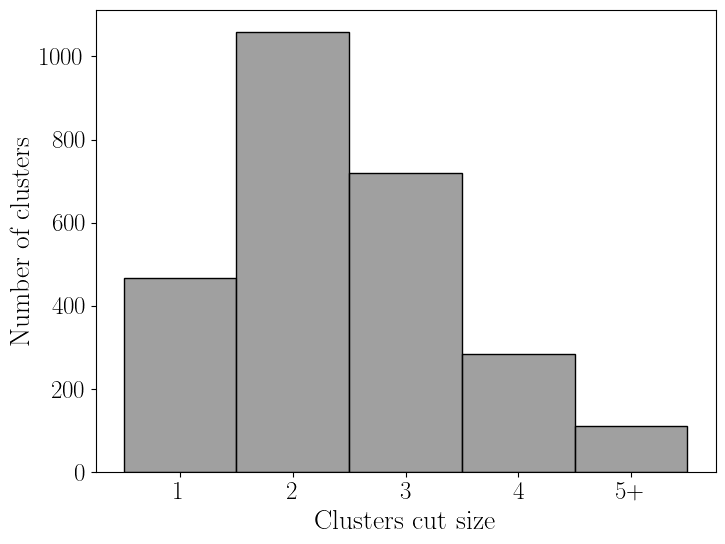

In [470]:
# Number of clusters per cut sizes

# Compute the min and max of your data
min_val = df_merged_tables_new["cut_size_modified"].min()
max_val = df_merged_tables_new["cut_size_modified"].max()

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # Edges between integers

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_merged_tables_new, x='cut_size_modified', bins=bins, color='grey', fill=True, stat='count', ax=ax)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(["1", "2", "3", "4", "5+"])
ax.set_ylabel('Number of clusters')
ax.set_xlabel('Clusters cut size')
plt.show()


In [471]:
# Function to randomly sample equal sizes from each X group
def sample_equal_groups(df, x_col='X', y_col='Y'):
    # Find the minimum group size
    # min_size = df.groupby(x_col).size().min()
    min_size = 10
    print(f"Minimum group size: {min_size}")
    
    # Sample min_size observations from each group
    sampled_df = df.groupby(x_col).apply(lambda x: x.sample(min_size)).reset_index(drop=True)
    return sampled_df

# Apply the sampling
# for _ in range(10):
#     sampled_data = sample_equal_groups(df_merged_tables_new, x_col='cut_size_modified')
#     from scipy.stats import spearmanr
#     correlation, p_value = spearmanr(sampled_data['cut_size_modified'], sampled_data['mae'])
#     print(f"Spearman's correlation: {correlation:.3f}, p-value: {p_value:.3f}")
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='cut_size_modified', y='mae', data=sampled_data, showfliers=False)
# plt.title('Box Plot of Y by X (Sampled Data)')
# plt.show()

In [472]:
df_merged_tables_new.columns

Index(['key', 'nodes', 'size', 'cluster_has_loop', 'density',
       'internal_degree', 'scaled_density', 'nodes_mean_internal_indegree',
       'nodes_sum_internal_indegree', 'nodes_max_internal_indegree',
       'nodes_mean_internal_outdegree', 'nodes_sum_internal_outdegree',
       'nodes_max_internal_outdegree', 'nodes_mean_internal_degree',
       'nodes_sum_internal_degree', 'nodes_max_internal_degree',
       'average_outdegree_fraction', 'max_outdegree_fraction',
       'average_indegree_fraction', 'max_indegree_fraction', 'cut_size',
       'cut_ratio', 'conductance', 'nb_upstream_interfaces',
       'nb_downstream_interfaces', 'max_diameter', 'mean_delay_time',
       'min_delay_time', 'max_delay_time', 'std_delay_time',
       'median_delay_time', 'e_loss_wrt_energy_through',
       'e_loss_wrt_energy_consumed', 'total_e_loss_wh', 'mean_ts_tr_distance',
       'mean_demands_distance', 'mean_pipes_loss', 'dhn_id', 'unique_key',
       'mae', 'energy_mae', 'energy_mare_per_los

In [473]:
df_merged_tables_new['dhn_id'].unique()

array([  1,   2,   3,   4, 100, 101, 102, 103, 104, 105, 106, 108, 109,
       110, 111, 112, 137])

In [474]:
for dhn_id in df_merged_tables_new['dhn_id'].unique():
    print(f'DHN {dhn_id}')
    df_dhn_id = df_merged_tables_new[df_merged_tables_new['dhn_id'] == dhn_id]
    df_dhn_id_avg_cut_size = df_dhn_id.groupby(by='cut_size_modified', as_index=False).mean(numeric_only=True)
    print(f'correlation cut size vs mae', spearmanr(df_dhn_id_avg_cut_size['cut_size_modified'], df_dhn_id_avg_cut_size['mae']))

DHN 1
correlation cut size vs mae SignificanceResult(statistic=np.float64(0.8999999999999998), pvalue=np.float64(0.03738607346849874))
DHN 2
correlation cut size vs mae SignificanceResult(statistic=np.float64(1.0), pvalue=np.float64(0.0))
DHN 3
correlation cut size vs mae SignificanceResult(statistic=np.float64(0.8999999999999998), pvalue=np.float64(0.03738607346849874))
DHN 4
correlation cut size vs mae SignificanceResult(statistic=np.float64(0.0), pvalue=np.float64(1.0))
DHN 100
correlation cut size vs mae SignificanceResult(statistic=np.float64(0.7999999999999999), pvalue=np.float64(0.10408803866182788))
DHN 101
correlation cut size vs mae SignificanceResult(statistic=np.float64(0.7), pvalue=np.float64(0.1881204043741873))
DHN 102
correlation cut size vs mae SignificanceResult(statistic=np.float64(0.9999999999999999), pvalue=np.float64(1.4042654220543672e-24))
DHN 103
correlation cut size vs mae SignificanceResult(statistic=np.float64(-0.09999999999999999), pvalue=np.float64(0.87288

In [475]:
df_merged_tables_new[['mae', 'cut_size_modified']].quantile()

mae                  0.016007
cut_size_modified    2.000000
Name: 0.5, dtype: float64

In [476]:
# Compute Z-scores for each column
df_ = df_merged_tables_new[['mae', 'cut_size_modified']]
z_scores = np.abs((df_ - df_.mean()) / df_.std())

# Define a threshold (commonly 3)
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

# Filter outliers
df_outliers = df_[outliers]
df_no_outliers_test = df_[~outliers]
print(df_no_outliers_test.groupby(by='cut_size_modified').mean())
print(f'No outliers clusters = {len(df_no_outliers_test)}')
print(spearmanr(df_no_outliers_test['mae'], df_no_outliers_test['cut_size_modified']))

                        mae
cut_size_modified          
1                  0.020680
2                  0.025910
3                  0.026415
4                  0.024725
5                  0.028671
No outliers clusters = 2592
SignificanceResult(statistic=np.float64(0.07305927214372786), pvalue=np.float64(0.00019706280987177513))


C:\Users\d22rodri\AppData\Roaming\MobaXterm\slash\mx86_64b\var\log\xwin\ipykernel_14432\2979357199.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cut_size[2].set_xticklabels(["1", "2", "3", "4", "5+"])


Spearman correlation MAE vs cut size: SignificanceResult(statistic=np.float64(0.24582069282909996), pvalue=np.float64(0.03116413692823103))
Spearman correlation Energy error vs cut size: SignificanceResult(statistic=np.float64(0.6818233183945058), pvalue=np.float64(8.706525813838983e-12))
Spearman correlation Energy error per loss vs cut size: SignificanceResult(statistic=np.float64(0.5757040029109053), pvalue=np.float64(4.314357163308036e-08))
Spearman correlation MAE vs size: SignificanceResult(statistic=np.float64(0.010322368962136015), pvalue=np.float64(0.8349326884861952))
Spearman correlation Energy error vs size: SignificanceResult(statistic=np.float64(0.41704419107396445), pvalue=np.float64(1.1044595884061655e-18))
Spearman correlation Energy error per loss vs size: SignificanceResult(statistic=np.float64(0.2585433522445616), pvalue=np.float64(1.0982713692175015e-07))


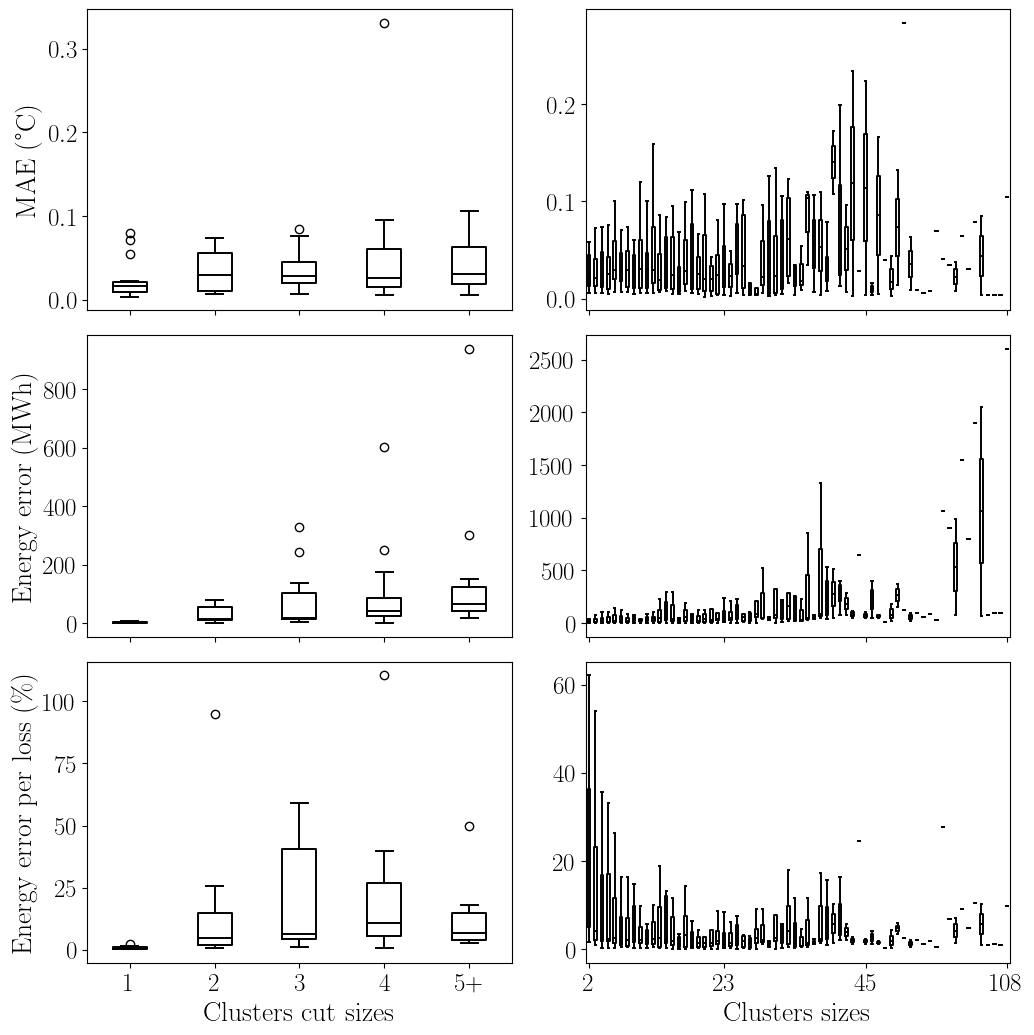

In [477]:
# Big plots
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=2, sharex='col', sharey=False)
fig.tight_layout(pad=0.1)

# Cut size column
ax_cut_size = axes[:, 0]
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'cut_size_modified'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_mean, x='cut_size_modified', y='mae', 
            showfliers=True, fill=False, color='black', 
            gap=.5, ax=ax_cut_size[0])
ax_cut_size[0].set_ylabel('MAE (°C)')
sns.boxplot(df_mean, x='cut_size_modified', y='energy_error_mwh', 
            showfliers=True, fill=False, color='black', 
            gap=.5, ax=ax_cut_size[1])
ax_cut_size[1].set_ylabel('Energy error (MWh)')
sns.boxplot(df_mean, x='cut_size_modified', y='energy_mare_per_loss', 
            showfliers=True, fill=False, color='black', 
            gap=.5, ax=ax_cut_size[2])
ax_cut_size[2].set_ylabel('Energy error per loss (\\%)')
ax_cut_size[2].set_xlabel('Clusters cut sizes')
ax_cut_size[2].set_xticklabels(["1", "2", "3", "4", "5+"])
print(f"Spearman correlation MAE vs cut size: {spearmanr(df_mean['cut_size_modified'], df_mean['mae'])}")
print(f"Spearman correlation Energy error vs cut size: {spearmanr(df_mean['cut_size_modified'], df_mean['energy_error_mwh'])}")
print(f"Spearman correlation Energy error per loss vs cut size: {spearmanr(df_mean['cut_size_modified'], df_mean['energy_mare_per_loss'])}")

# Sie column
ax_size = axes[:, 1]
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'size'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_mean, x='size', y='mae', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax_size[0])
ax_size[0].set_ylabel('')
sns.boxplot(df_mean, x='size', y='energy_error_mwh', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax_size[1])
ax_size[1].set_ylabel('')
sns.boxplot(df_mean, x='size', y='energy_mare_per_loss', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax_size[2])
ax_size[2].set_ylabel('')
ax_size[2].set_xlabel('Clusters cut sizes')
size_values = df_mean['size'].unique()
size_values.sort()
# Select 3-4 representative tick positions (e.g., min, max, and a couple in between)
n_ticks = 4  # Number of ticks to show
if len(size_values) > n_ticks:
    # Evenly spaced indices
    tick_indices = np.linspace(0, len(size_values) - 1, n_ticks, dtype=int)
    tick_positions = tick_indices  # Positions correspond to index in sorted unique values
    tick_labels = [size_values[i] for i in tick_indices]
else:
    # If fewer unique values than n_ticks, use all
    tick_positions = range(len(size_values))
    tick_labels = size_values

# Set custom x-ticks
ax_size[0].set_xticks(tick_positions)
ax_size[1].set_xticks(tick_positions)
ax_size[2].set_xticks(tick_positions)
ax_size[0].set_xticklabels(tick_labels)
ax_size[1].set_xticklabels(tick_labels)
ax_size[2].set_xticklabels(tick_labels)

# ax_size[2].set_ylabel('Energy error per loss (\\%)')
ax_size[2].set_xlabel('Clusters sizes')
print(f"Spearman correlation MAE vs size: {spearmanr(df_mean['size'], df_mean['mae'])}")
print(f"Spearman correlation Energy error vs size: {spearmanr(df_mean['size'], df_mean['energy_error_mwh'])}")
print(f"Spearman correlation Energy error per loss vs size: {spearmanr(df_mean['cut_size_modified'], df_mean['energy_mare_per_loss'])}")

plt.show()


C:\Users\d22rodri\AppData\Roaming\MobaXterm\slash\mx86_64b\var\log\xwin\ipykernel_14432\464777692.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["1", "2", "3", "4", "5+"])


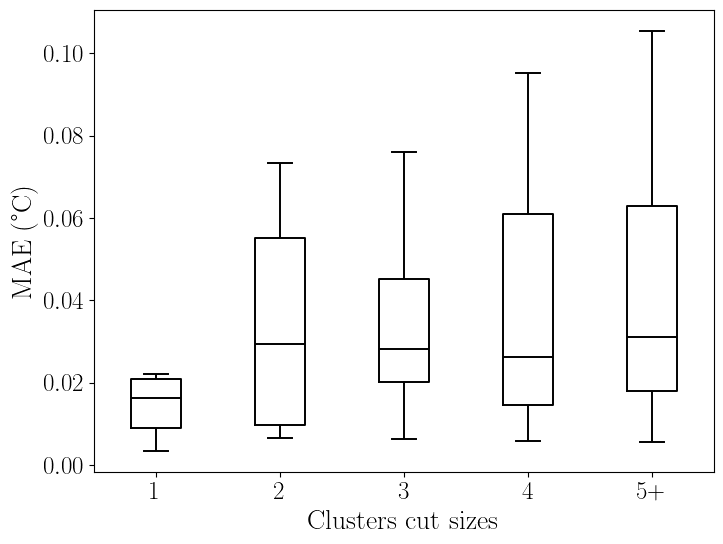

Spearman correlation mae vs cut size: SignificanceResult(statistic=np.float64(0.24582069282909996), pvalue=np.float64(0.03116413692823103))


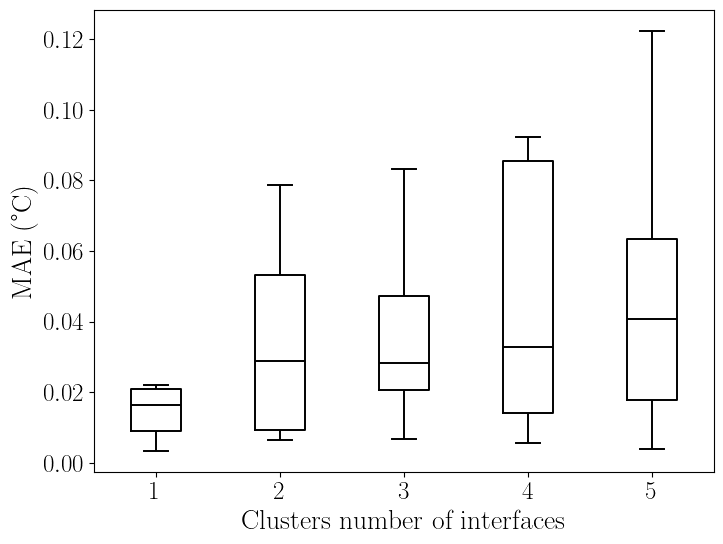

Spearman correlation mae vs nb interfaces: SignificanceResult(statistic=np.float64(0.2596296366667128), pvalue=np.float64(0.022594028149907287))


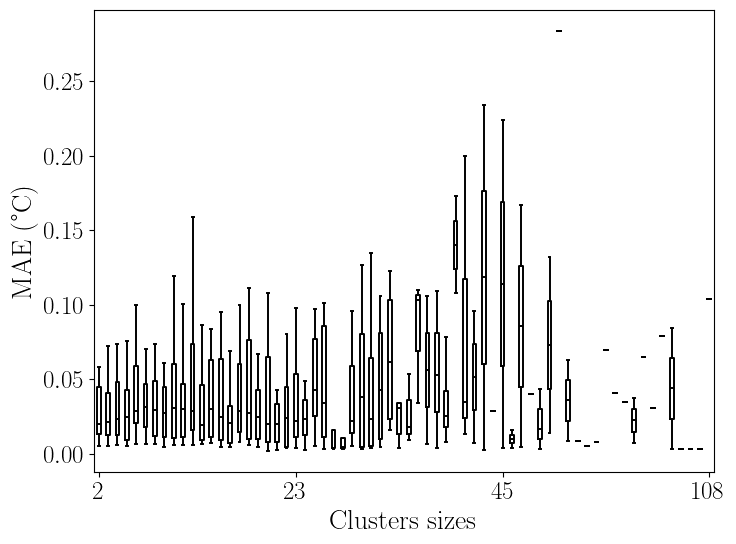

Spearman correlation MAE vs size: SignificanceResult(statistic=np.float64(0.010322368962136015), pvalue=np.float64(0.8349326884861952))


In [478]:
target_metric = 'mae'

fig, ax = plt.subplots(figsize=(8,6))
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'cut_size_modified'], as_index=False).mean(numeric_only=True)
# spearmanr(df_mean['cut_size_modified'], df_mean['mae'])
sns.boxplot(df_mean, x='cut_size_modified', y=target_metric, 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)
ax.set_ylabel('MAE (°C)')
ax.set_xlabel('Clusters cut sizes')
ax.set_xticklabels(["1", "2", "3", "4", "5+"])
plt.show()
print(f"Spearman correlation {target_metric} vs cut size: {spearmanr(df_mean['cut_size_modified'], df_mean[target_metric])}")

df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'total_interfaces_modified'], as_index=False).mean(numeric_only=True)
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_mean, x='total_interfaces_modified', y=target_metric, 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)
ax.set_ylabel('MAE (°C)')
ax.set_xlabel('Clusters number of interfaces')
plt.show()
print(f"Spearman correlation {target_metric} vs nb interfaces: {spearmanr(df_mean['total_interfaces_modified'], df_mean[target_metric])}")

fig, ax = plt.subplots(figsize=(8,6))
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'size'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_mean, x='size', y='mae', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)
# Get unique size values from the DataFrame
size_values = df_mean['size'].unique()
size_values.sort()  # Sort for consistency

# Select 3-4 representative tick positions (e.g., min, max, and a couple in between)
n_ticks = 4  # Number of ticks to show
if len(size_values) > n_ticks:
    # Evenly spaced indices
    tick_indices = np.linspace(0, len(size_values) - 1, n_ticks, dtype=int)
    tick_positions = tick_indices  # Positions correspond to index in sorted unique values
    tick_labels = [size_values[i] for i in tick_indices]
else:
    # If fewer unique values than n_ticks, use all
    tick_positions = range(len(size_values))
    tick_labels = size_values

# Set custom x-ticks
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

ax.set_ylabel('MAE (°C)')
ax.set_xlabel('Clusters sizes')

plt.show()
print(f"Spearman correlation MAE vs size: {spearmanr(df_mean['size'], df_mean['mae'])}")



C:\Users\d22rodri\AppData\Roaming\MobaXterm\slash\mx86_64b\var\log\xwin\ipykernel_14432\325491798.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["1", "2", "3", "4", "5+"])


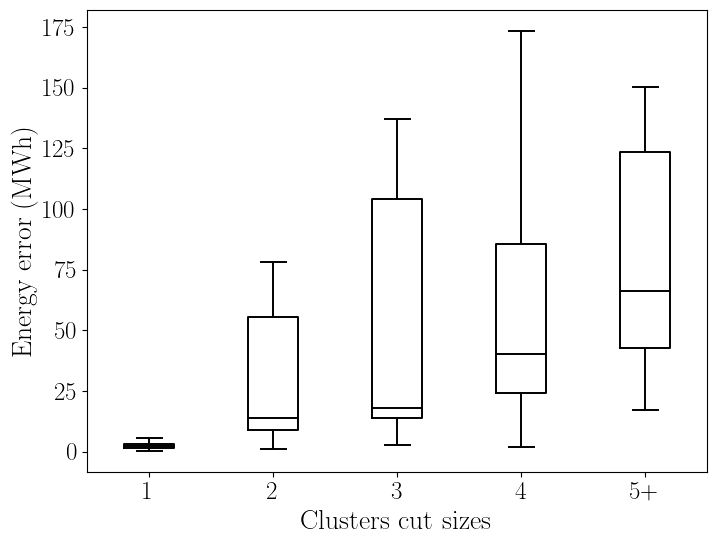

Spearman correlation Energy error vs cut size: SignificanceResult(statistic=np.float64(0.6818233183945058), pvalue=np.float64(8.706525813838983e-12))


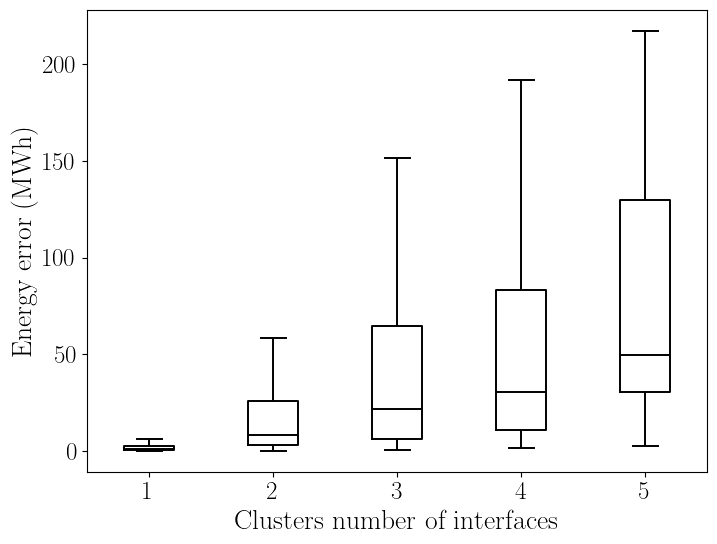

Spearman correlation Energy error vs nb interfaces: SignificanceResult(statistic=np.float64(0.6753755625170211), pvalue=np.float64(1.6140956671062403e-11))


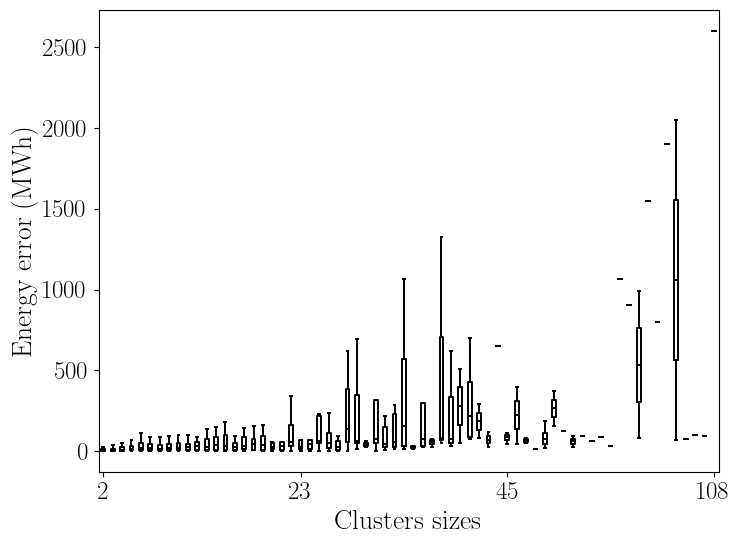

Spearman correlation Energy error vs size: SignificanceResult(statistic=np.float64(0.41704419107396445), pvalue=np.float64(1.1044595884061655e-18))


In [479]:
import seaborn as sns 

fig, ax = plt.subplots(figsize=(8,6))
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'cut_size_modified'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_mean, x='cut_size_modified', y='energy_error_mwh', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)
ax.set_ylabel('Energy error (MWh)')
ax.set_xlabel('Clusters cut sizes')
ax.set_xticklabels(["1", "2", "3", "4", "5+"])
plt.show()
print(f"Spearman correlation Energy error vs cut size: {spearmanr(df_mean['cut_size_modified'], df_mean['energy_error_mwh'])}")

fig, ax = plt.subplots(figsize=(8,6))
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'total_interfaces_modified'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_merged_tables_new, x='total_interfaces_modified', y='energy_error_mwh', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)
ax.set_ylabel('Energy error (MWh)')
ax.set_xlabel('Clusters number of interfaces')
plt.show()
print(f"Spearman correlation Energy error vs nb interfaces: {spearmanr(df_mean['total_interfaces_modified'], df_mean['energy_error_mwh'])}")

fig, ax = plt.subplots(figsize=(8,6))
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'size'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_merged_tables_new, x='size', y='energy_error_mwh', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)

# Get unique size values from the DataFrame
size_values = df_merged_tables_new['size'].unique()
size_values.sort()  # Sort for consistency

# Select 3-4 representative tick positions (e.g., min, max, and a couple in between)
n_ticks = 4  # Number of ticks to show
if len(size_values) > n_ticks:
    # Evenly spaced indices
    tick_indices = np.linspace(0, len(size_values) - 1, n_ticks, dtype=int)
    tick_positions = tick_indices  # Positions correspond to index in sorted unique values
    tick_labels = [size_values[i] for i in tick_indices]
else:
    # If fewer unique values than n_ticks, use all
    tick_positions = range(len(size_values))
    tick_labels = size_values

# Set custom x-ticks
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

ax.set_ylabel('Energy error (MWh)')
ax.set_xlabel('Clusters sizes')
plt.show()
print(f"Spearman correlation Energy error vs size: {spearmanr(df_mean['size'], df_mean['energy_error_mwh'])}")


C:\Users\d22rodri\AppData\Roaming\MobaXterm\slash\mx86_64b\var\log\xwin\ipykernel_14432\2838584386.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["1", "2", "3", "4", "5+"])


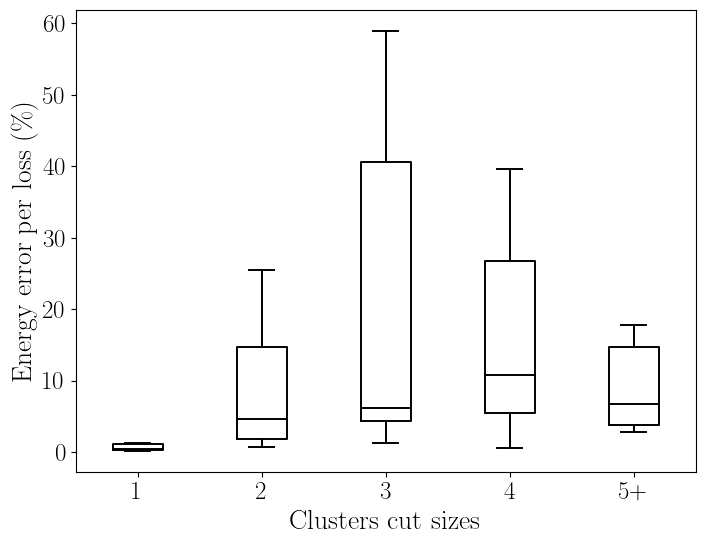

Spearman correlation Energy error per loss vs cut size: SignificanceResult(statistic=np.float64(0.5757040029109053), pvalue=np.float64(4.314357163308036e-08))


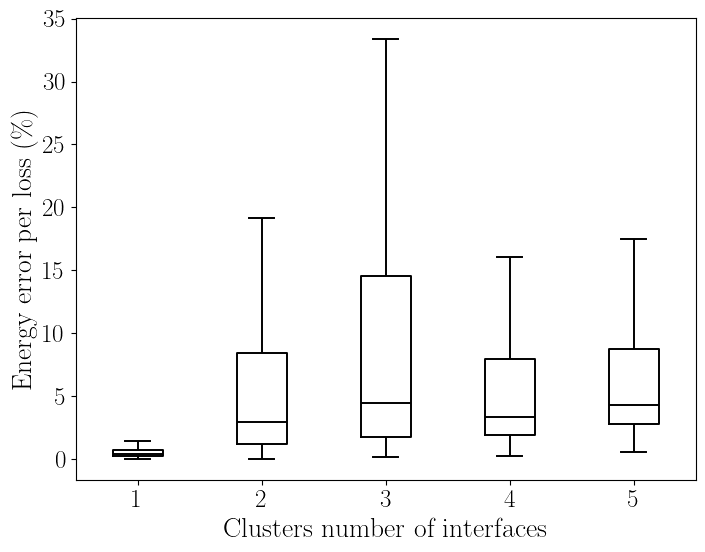

Spearman correlation Energy error per loss vs nb interfaces: SignificanceResult(statistic=np.float64(0.5291995636445477), pvalue=np.float64(7.492963411414775e-07))


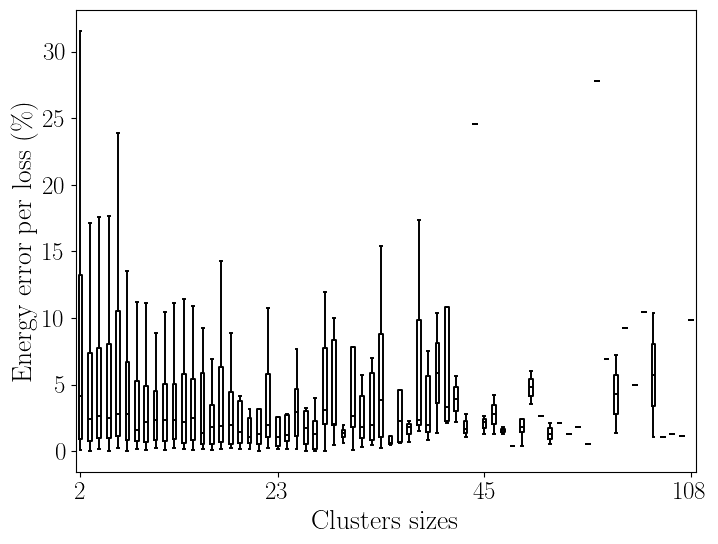

Spearman correlation Energy error per loss vs size: SignificanceResult(statistic=np.float64(-0.21954471717557456), pvalue=np.float64(7.232602127005713e-06))


In [480]:
import seaborn as sns 

fig, ax = plt.subplots(figsize=(8,6))
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'cut_size_modified'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_mean, x='cut_size_modified', y='energy_mare_per_loss', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)
ax.set_ylabel('Energy error per loss (\\%)')
ax.set_xlabel('Clusters cut sizes')
ax.set_xticklabels(["1", "2", "3", "4", "5+"])
plt.show()
print(f"Spearman correlation Energy error per loss vs cut size: {spearmanr(df_mean['cut_size_modified'], df_mean['energy_mare_per_loss'])}")

fig, ax = plt.subplots(figsize=(8,6))
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'total_interfaces_modified'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_merged_tables_new, x='total_interfaces_modified', y='energy_mare_per_loss', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)
ax.set_ylabel('Energy error per loss (\\%)')
ax.set_xlabel('Clusters number of interfaces')
plt.show()
print(f"Spearman correlation Energy error per loss vs nb interfaces: {spearmanr(df_mean['total_interfaces_modified'], df_mean['energy_mare_per_loss'])}")

fig, ax = plt.subplots(figsize=(8,6))
df_mean = df_merged_tables_new.groupby(by=['dhn_id', 'size'], as_index=False).mean(numeric_only=True)
sns.boxplot(df_merged_tables_new, x='size', y='energy_mare_per_loss', 
            showfliers=False, fill=False, color='black', 
            gap=.5, ax=ax)

# Get unique size values from the DataFrame
size_values = df_merged_tables_new['size'].unique()
size_values.sort()  # Sort for consistency

# Select 3-4 representative tick positions (e.g., min, max, and a couple in between)
n_ticks = 4  # Number of ticks to show
if len(size_values) > n_ticks:
    # Evenly spaced indices
    tick_indices = np.linspace(0, len(size_values) - 1, n_ticks, dtype=int)
    tick_positions = tick_indices  # Positions correspond to index in sorted unique values
    tick_labels = [size_values[i] for i in tick_indices]
else:
    # If fewer unique values than n_ticks, use all
    tick_positions = range(len(size_values))
    tick_labels = size_values

# Set custom x-ticks
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

ax.set_ylabel('Energy error per loss (\\%)')
ax.set_xlabel('Clusters sizes')
plt.show()
print(f"Spearman correlation Energy error per loss vs size: {spearmanr(df_mean['size'], df_mean['energy_mare_per_loss'])}")

In [481]:
df_merged_tables_new.columns

Index(['key', 'nodes', 'size', 'cluster_has_loop', 'density',
       'internal_degree', 'scaled_density', 'nodes_mean_internal_indegree',
       'nodes_sum_internal_indegree', 'nodes_max_internal_indegree',
       'nodes_mean_internal_outdegree', 'nodes_sum_internal_outdegree',
       'nodes_max_internal_outdegree', 'nodes_mean_internal_degree',
       'nodes_sum_internal_degree', 'nodes_max_internal_degree',
       'average_outdegree_fraction', 'max_outdegree_fraction',
       'average_indegree_fraction', 'max_indegree_fraction', 'cut_size',
       'cut_ratio', 'conductance', 'nb_upstream_interfaces',
       'nb_downstream_interfaces', 'max_diameter', 'mean_delay_time',
       'min_delay_time', 'max_delay_time', 'std_delay_time',
       'median_delay_time', 'e_loss_wrt_energy_through',
       'e_loss_wrt_energy_consumed', 'total_e_loss_wh', 'mean_ts_tr_distance',
       'mean_demands_distance', 'mean_pipes_loss', 'dhn_id', 'unique_key',
       'mae', 'energy_mae', 'energy_mare_per_los

In [482]:
metrics_considered = [
        'density', 'internal_degree', 'scaled_density', 'size',
       'nodes_mean_internal_indegree', 'nodes_sum_internal_indegree', 'nodes_max_internal_indegree',
       'nodes_mean_internal_outdegree', 'nodes_sum_internal_outdegree', 'nodes_max_internal_outdegree', 
       'nodes_mean_internal_degree', 'nodes_sum_internal_degree', 'nodes_max_internal_degree',
       'average_outdegree_fraction', 'max_outdegree_fraction', 'average_indegree_fraction', 'max_indegree_fraction', 
       'cut_size', 'cut_size_modified', 'cut_ratio', 'conductance', 
       'mean_ts_tr_distance','mean_demands_distance', 'mean_pipes_loss',
       'nb_upstream_interfaces', 'nb_downstream_interfaces', 'total_interfaces', 'total_interfaces_modified',
        'max_diameter', 'mean_delay_time', 'min_delay_time', 'max_delay_time', 'std_delay_time', 'median_delay_time',
        'e_loss_wrt_energy_through', 'e_loss_wrt_energy_consumed', 'energy_error_mwh', 'energy_loss_mwh',]

targets = ['mae', 'energy_mae', 'energy_error_mwh', 'energy_mare_per_loss']

In [483]:
# Metrics with performances

def get_corr_mi_from_metrics(df, targets, metrics_considered):
    dict_correlations = {}
    dict_mis = {}
    for el in metrics_considered:
        for target in targets:
            if not target in dict_correlations.keys():
                dict_correlations[target] = {}
                dict_mis[target] = {}
            # (val, pvalue) = compute_correalation_with_permutation_test(df_cut_size_fixed[target], df_cut_size_fixed[el], True, 'spearman')
            df_mean = df.groupby(by=['dhn_id', el], as_index=False).mean(numeric_only=True)
            sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
            rho = sp.statistic
            pval = sp.pvalue
            # print(el)
            mi = mutual_info_regression(df_mean[[el]].values, df_mean[target].values, random_state=RANDOM_STATE_SHUFFLE)  
            dict_correlations[target][el] = 0 if pval > 0.05 else rho
            dict_mis[target][el] = 0 if mi[0] < 0.1 else mi[0]

    return dict_correlations, dict_mis

#### Correlations over all clusters

In [484]:
# Correlations and mutual informations 
dict_correlations, dict_mis = get_corr_mi_from_metrics(df_merged_tables_new, targets, metrics_considered)

In [485]:
df_correlations = pd.DataFrame.from_dict(dict_correlations)
df_mis = pd.DataFrame.from_dict(dict_mis)

In [486]:
df_correlations

,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,0.000000,-0.400527,-0.400527,0.220763
internal_degree,0.000000,0.402666,0.402666,-0.230009
scaled_density,-0.142573,-0.329879,-0.329879,0.000000
size,0.000000,0.417044,0.417044,-0.219545
nodes_mean_internal_indegree,0.000000,0.314416,0.314416,-0.255980
nodes_sum_internal_indegree,0.000000,0.402666,0.402666,-0.230009
nodes_max_internal_indegree,0.000000,0.000000,0.000000,0.000000
nodes_mean_internal_outdegree,0.000000,0.314416,0.314416,-0.255980
nodes_sum_internal_outdegree,0.000000,0.402666,0.402666,-0.230009
nodes_max_internal_outdegree,0.000000,0.307923,0.307923,-0.444245


In [487]:
df_mis

,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,0.000000,0.139580,0.139580,0.000000
internal_degree,0.000000,0.101766,0.101766,0.101268
scaled_density,0.000000,0.127112,0.127112,0.175697
size,0.000000,0.125484,0.125484,0.000000
nodes_mean_internal_indegree,0.000000,0.124672,0.124672,0.106804
nodes_sum_internal_indegree,0.000000,0.101766,0.101766,0.101268
nodes_max_internal_indegree,0.000000,0.125621,0.125621,0.150035
nodes_mean_internal_outdegree,0.000000,0.124672,0.124672,0.106804
nodes_sum_internal_outdegree,0.000000,0.101766,0.101766,0.101268
nodes_max_internal_outdegree,0.000000,0.000000,0.000000,0.315180


In [488]:
# view perf by cut sizes
df_merged_tables_new[df_merged_tables_new['dhn_id'] == 1].sort_values(by='mae', ascending=True).head(10)[['mae', 'cut_size', 'total_interfaces', 'energy_mae',]]

,mae,cut_size,total_interfaces,energy_mae
8,0.001660,1,1,5.010139e+06
27,0.002803,1,1,1.731728e+07
31,0.005110,2,2,7.145076e+08
26,0.005133,3,2,5.880200e+08
103,0.005251,1,1,2.506469e+07
123,0.006410,3,3,9.320780e+08
24,0.006699,1,1,5.068347e+07
67,0.007201,1,1,5.661552e+07
49,0.007272,1,1,3.204556e+07
17,0.008218,3,3,1.211341e+09


In [489]:
# Mean perf per cut size

df_mean_perfs = df_merged_tables_new.groupby(by=['cut_size_modified'], as_index=True).mean(numeric_only=True)
df_mean_perfs[['mae', 'energy_error_mwh', 'energy_mare_per_loss']]

,mae,energy_error_mwh,energy_mare_per_loss
cut_size_modified,,,
1,0.022411,2.407783,0.880585
2,0.028833,33.051641,15.152639
3,0.028407,84.136539,24.460914
4,0.029112,94.712308,22.522565
5,0.036189,170.614903,17.935560


In [490]:
df_merged_tables_new.columns

Index(['key', 'nodes', 'size', 'cluster_has_loop', 'density',
       'internal_degree', 'scaled_density', 'nodes_mean_internal_indegree',
       'nodes_sum_internal_indegree', 'nodes_max_internal_indegree',
       'nodes_mean_internal_outdegree', 'nodes_sum_internal_outdegree',
       'nodes_max_internal_outdegree', 'nodes_mean_internal_degree',
       'nodes_sum_internal_degree', 'nodes_max_internal_degree',
       'average_outdegree_fraction', 'max_outdegree_fraction',
       'average_indegree_fraction', 'max_indegree_fraction', 'cut_size',
       'cut_ratio', 'conductance', 'nb_upstream_interfaces',
       'nb_downstream_interfaces', 'max_diameter', 'mean_delay_time',
       'min_delay_time', 'max_delay_time', 'std_delay_time',
       'median_delay_time', 'e_loss_wrt_energy_through',
       'e_loss_wrt_energy_consumed', 'total_e_loss_wh', 'mean_ts_tr_distance',
       'mean_demands_distance', 'mean_pipes_loss', 'dhn_id', 'unique_key',
       'mae', 'energy_mae', 'energy_mare_per_los

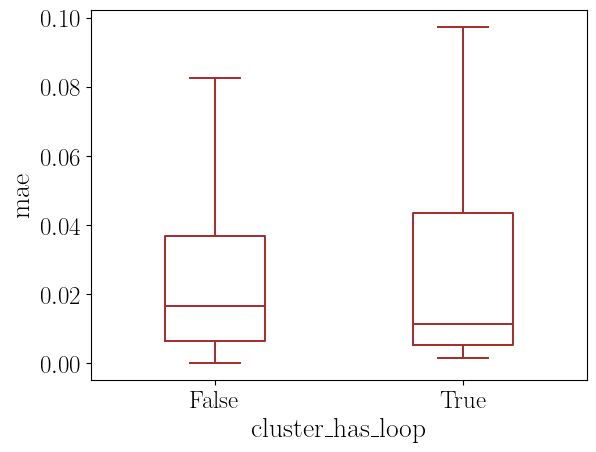

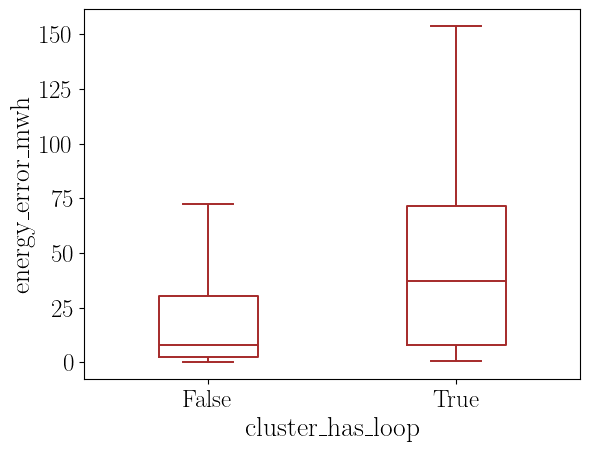

In [491]:
sns.boxplot(df_merged_tables_new, x='cluster_has_loop', y='mae', showfliers=False, fill=False, gap=0.5)
plt.show()
sns.boxplot(df_merged_tables_new, x='cluster_has_loop', y='energy_error_mwh', showfliers=False, fill=False, gap=0.5)
plt.show()

In [ ]:
# X_data = df_merged_tables_new[['mean_pipes_loss', 'max_delay_time', 'mean_delay_time', 'median_delay_time', 'cut_size_modified', 'max_outdegree_fraction', 'mean_demands_distance']]
x_cols = ['mean_pipes_loss', 'energy_loss_mwh', 'max_delay_time', 'mean_delay_time', 'median_delay_time', 'cut_size_modified']
X_data = df_merged_tables_new[x_cols]
df_merged_tables_new['goodness'] = df_merged_tables_new['energy_mare_per_loss'].apply(lambda x: 1 if x <= 5 else 0)
Y_data_classification = df_merged_tables_new['goodness']

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
decision_tree = DecisionTreeClassifier(criterion='log_loss', splitter='best', max_depth=5)
X_data, Y_data_classification = shuffle(X_data, Y_data_classification, random_state=112)
# X_data.reset_index(inplace=True)
# Y_data_classification.reset_index(inplace=True)
decision_tree.fit(X_data[0:2200], Y_data_classification[0:2200])

print(f'Score classifier tree : ', decision_tree.score(X_data[2200:], Y_data_classification[2200:]))
tree_rules = export_text(decision_tree, feature_names=x_cols)
print(tree_rules)

Score classifier tree :  0.7482993197278912
|--- cut_size_modified <= 1.50
|   |--- energy_loss_mwh <= 60.08
|   |   |--- energy_loss_mwh <= 59.74
|   |   |   |--- energy_loss_mwh <= 37.11
|   |   |   |   |--- energy_loss_mwh <= 36.66
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- energy_loss_mwh >  36.66
|   |   |   |   |   |--- class: 0
|   |   |   |--- energy_loss_mwh >  37.11
|   |   |   |   |--- class: 1
|   |   |--- energy_loss_mwh >  59.74
|   |   |   |--- class: 0
|   |--- energy_loss_mwh >  60.08
|   |   |--- class: 1
|--- cut_size_modified >  1.50
|   |--- max_delay_time <= 26.70
|   |   |--- median_delay_time <= 3.94
|   |   |   |--- cut_size_modified <= 2.50
|   |   |   |   |--- mean_delay_time <= 1.51
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- mean_delay_time >  1.51
|   |   |   |   |   |--- class: 0
|   |   |   |--- cut_size_modified >  2.50
|   |   |   |   |--- mean_pipes_loss <= 0.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- mean_pipes_l

In [ ]:
# X_data = df_merged_tables_new[['mean_pipes_loss', 'max_delay_time', 'mean_delay_time', 'median_delay_time', 'cut_size_modified', 'max_outdegree_fraction', 'mean_demands_distance']]
x_cols = ['max_delay_time', 'median_delay_time', 'mean_delay_time', 'cut_size_modified', 'energy_loss_mwh']

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
best_max_depth = 0
best_score = 0
for i in range(1,7):
    X_data = df_merged_tables_new[x_cols]
    df_merged_tables_new['goodness'] = df_merged_tables_new['energy_mare_per_loss'].apply(lambda x: 1 if x <= 3 else 0)
    Y_data_classification = df_merged_tables_new['goodness']
    decision_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i)
    X_data, Y_data_classification = shuffle(X_data, Y_data_classification, random_state=112)
    decision_tree.fit(X_data[0:1200], Y_data_classification[0:1200])
    sc = decision_tree.score(X_data[1200:], Y_data_classification[1200:])
    if sc > best_score:
        best_score = sc
        best_max_depth = i

print(f'Best at max depth {best_max_depth}')
decision_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=best_max_depth)
X_data, Y_data_classification = shuffle(X_data, Y_data_classification, random_state=112)
decision_tree.fit(X_data[0:1200], Y_data_classification[0:1200])

print(f'Score classifier tree : ', decision_tree.score(X_data[1200:], Y_data_classification[1200:]))
tree_rules = export_text(decision_tree, feature_names=x_cols)
print(tree_rules)

Best at max depth 4
Score classifier tree :  0.7147814018043026
|--- cut_size_modified <= 1.50
|   |--- max_delay_time <= 8.97
|   |   |--- mean_delay_time <= 8.92
|   |   |   |--- median_delay_time <= 8.17
|   |   |   |   |--- class: 1
|   |   |   |--- median_delay_time >  8.17
|   |   |   |   |--- class: 1
|   |   |--- mean_delay_time >  8.92
|   |   |   |--- class: 0
|   |--- max_delay_time >  8.97
|   |   |--- energy_loss_mwh <= 36.87
|   |   |   |--- energy_loss_mwh <= 36.30
|   |   |   |   |--- class: 1
|   |   |   |--- energy_loss_mwh >  36.30
|   |   |   |   |--- class: 0
|   |   |--- energy_loss_mwh >  36.87
|   |   |   |--- class: 1
|--- cut_size_modified >  1.50
|   |--- max_delay_time <= 47.35
|   |   |--- median_delay_time <= 5.31
|   |   |   |--- energy_loss_mwh <= 6021.55
|   |   |   |   |--- class: 0
|   |   |   |--- energy_loss_mwh >  6021.55
|   |   |   |   |--- class: 1
|   |   |--- median_delay_time >  5.31
|   |   |   |--- cut_size_modified <= 2.50
|   |   |   |   

In [ ]:
df_merged_tables_new[df_merged_tables_new['max_delay_time'] <= 60.0][['goodness', 'size', 'cut_size', 'mean_pipes_loss', 'mae', 'energy_mare_per_loss']]

,goodness,size,cut_size,mean_pipes_loss,mae,energy_mare_per_loss
0,0,2,2,0.105795,0.041671,16.070555
1,0,2,3,0.022448,0.020201,16.711509
2,0,2,2,0.053523,0.011192,11.633656
3,0,3,3,0.042039,0.026725,11.222793
4,0,2,4,0.001844,0.008642,25.241564
...,...,...,...,...,...,...
2548,0,2,1,0.083793,0.064061,3.273277
2553,0,2,3,0.023642,0.026319,5.918192
2562,1,8,2,0.083898,0.155501,0.479764
2585,0,2,2,0.029986,0.030092,5.193425


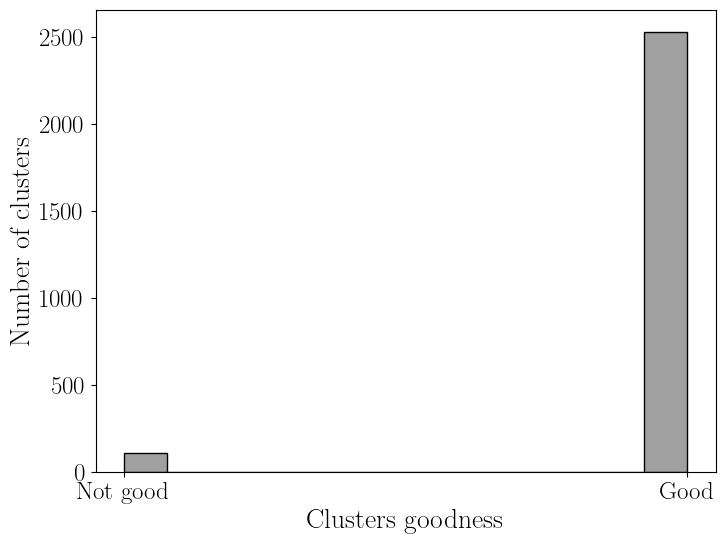

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_merged_tables_new, x='goodness_mae', color='grey', fill=True, stat='count', ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not good", "Good"])
ax.set_ylabel('Number of clusters')
ax.set_xlabel('Clusters goodness')
plt.show()

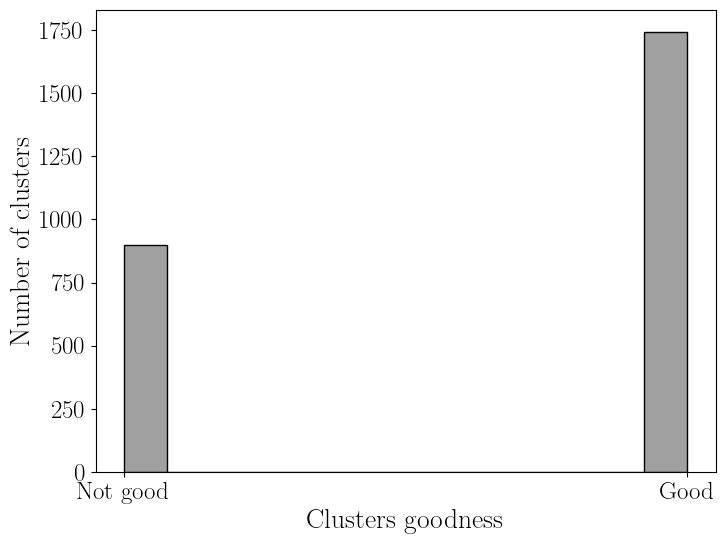

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_merged_tables_new, x='goodness_energy', color='grey', fill=True, stat='count', ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not good", "Good"])
ax.set_ylabel('Number of clusters')
ax.set_xlabel('Clusters goodness')
plt.show()

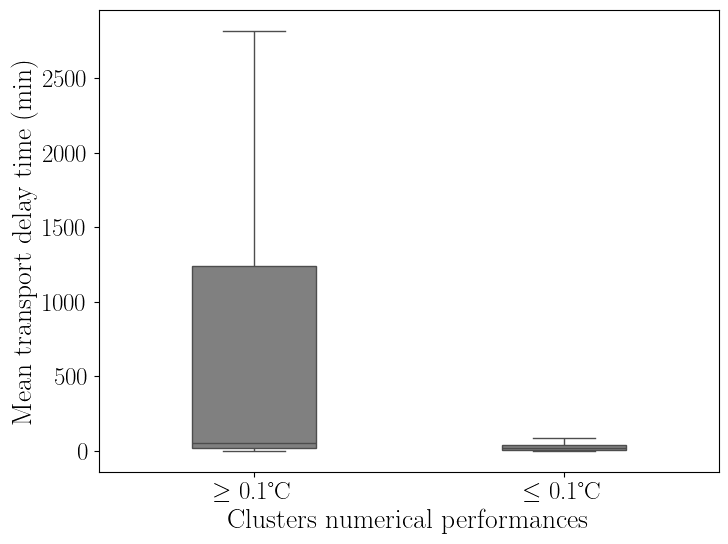

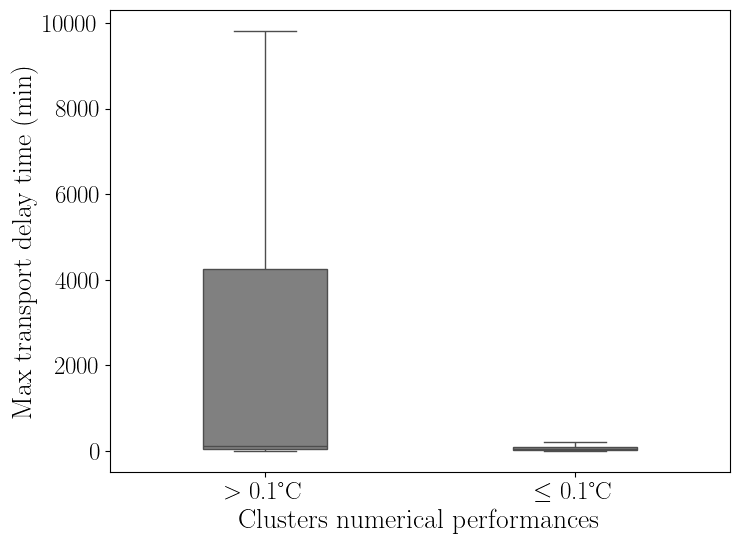

C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\2557943765.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$>$ 0.1°C", "$\\leq$ 0.1°C"])


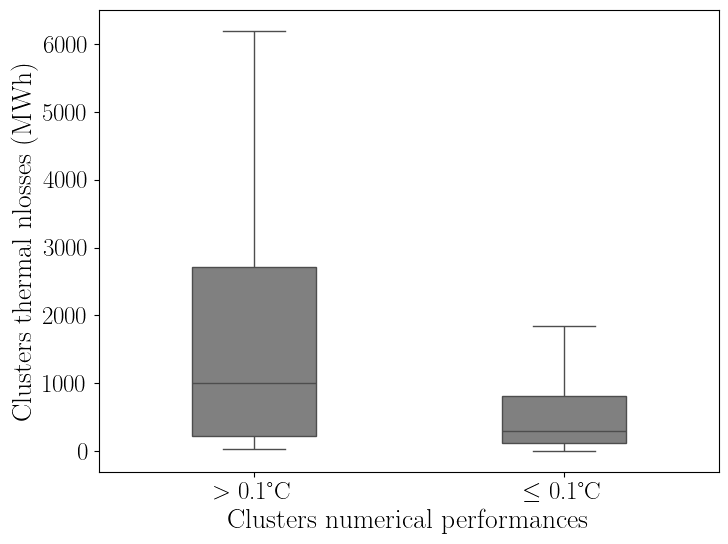

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_merged_tables_new, x='goodness_mae', y='mean_delay_time', showfliers=False, fill=True, color='grey', width=0.4, ax=ax)
ax.set_ylabel('Mean transport delay time (min)')
ax.set_xlabel('Clusters numerical performances')
ax.set_xticks([0, 1])
ax.set_xticklabels(["$\\geq$ 0.1°C", "$\\leq$ 0.1°C"])
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_merged_tables_new, x='goodness_mae', y='max_delay_time', showfliers=False, fill=True, color='grey', width=0.4, ax=ax)
ax.set_ylabel('Max transport delay time (min)')
ax.set_xlabel('Clusters numerical performances')
ax.set_xticks([0, 1])
ax.set_xticklabels(["$>$ 0.1°C", "$\\leq$ 0.1°C"])
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_merged_tables_new, x='goodness_mae', y='energy_loss_mwh', showfliers=False, fill=True, color='grey', width=0.4, ax=ax)
ax.set_ylabel('Clusters thermal nlosses (MWh)')
ax.set_xlabel('Clusters numerical performances')
ax.set_xticklabels(["$>$ 0.1°C", "$\\leq$ 0.1°C"])
plt.show()

# fig, ax = plt.subplots(figsize=(8,6))
# sns.boxplot(df_merged_tables_new, x='goodness_mae', y='total_interfaces', showfliers=False, ax=ax)
# plt.show()

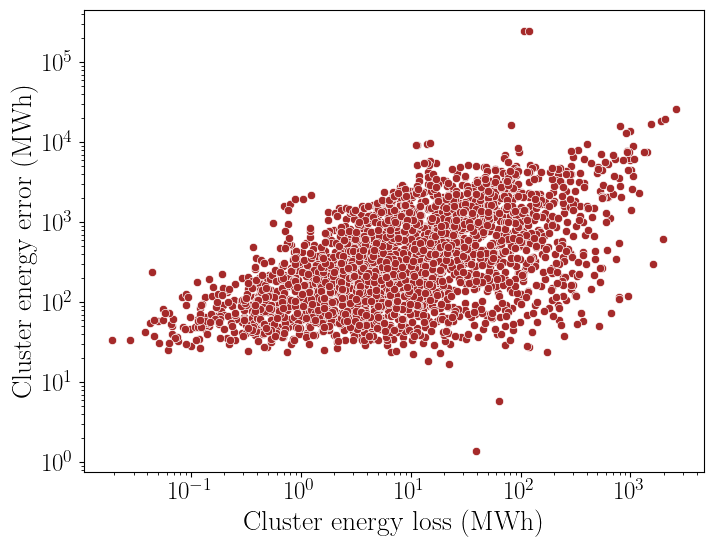

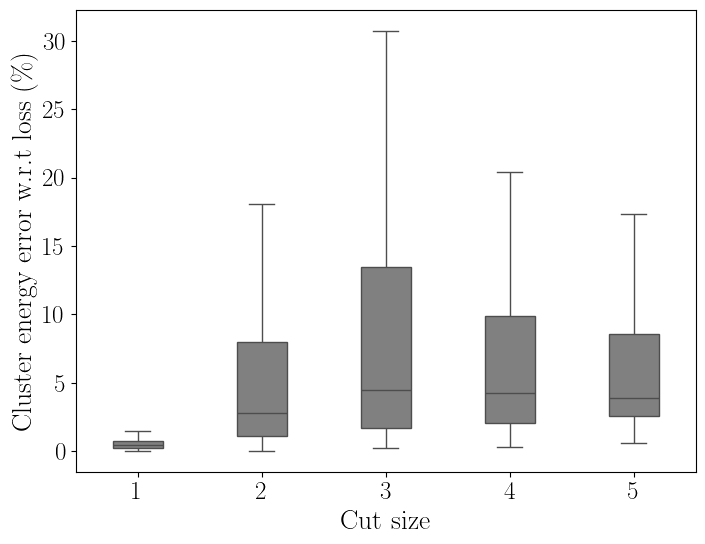

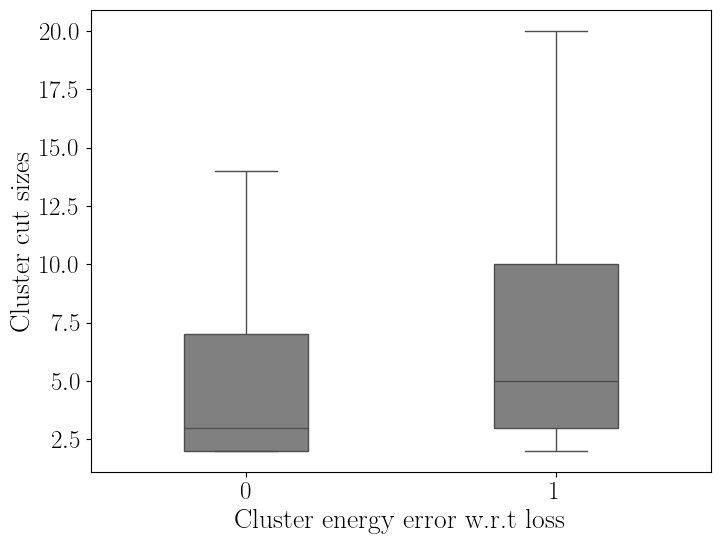

C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\2748093516.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$> 5\\%$", "$\\leq 5\\%$"])


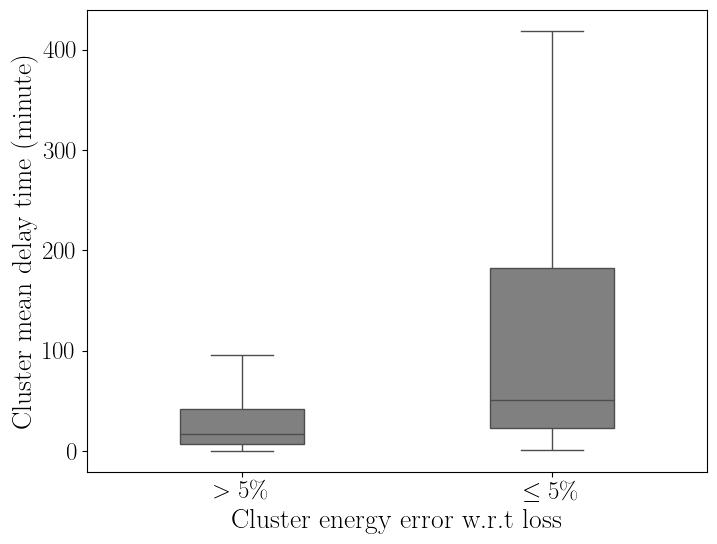

C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\2748093516.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$> 5\\%$", "$\\leq 5\\%$"])


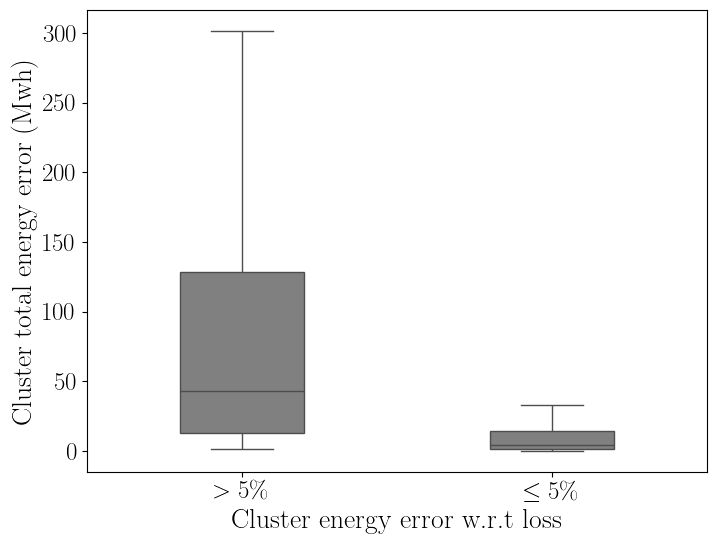

C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\2748093516.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["$> 5\\%$", "$\\leq 5\\%$"])


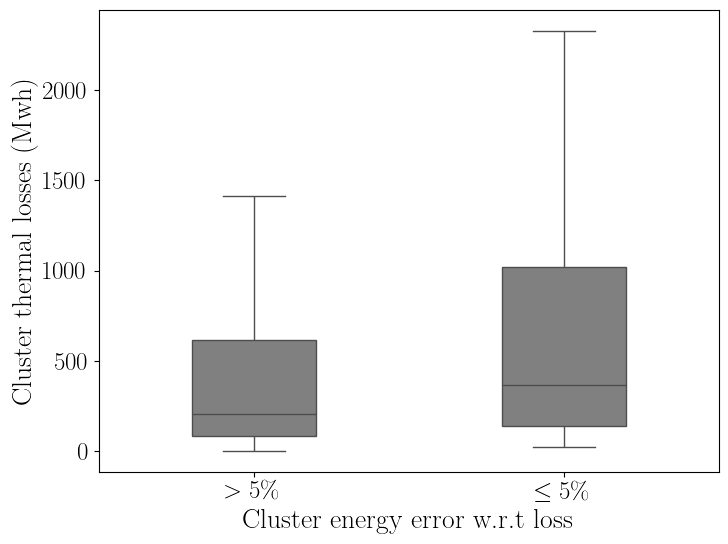

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")
sns.scatterplot(df_merged_tables_new, x='energy_error_mwh', y='energy_loss_mwh', ax=ax)
ax.set_xlabel('Cluster energy loss (MWh)')
ax.set_ylabel('Cluster energy error (MWh)')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_merged_tables_new, x='cut_size_modified', y='energy_mare_per_loss', showfliers=False, fill=True, color='grey', width=0.4, ax=ax)
ax.set_xlabel('Cut size')
ax.set_ylabel('Cluster energy error w.r.t loss (\\%)')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_merged_tables_new, x='goodness_energy', y='size', showfliers=False, fill=True, color='grey', width=0.4, ax=ax)
ax.set_xlabel('Cluster energy error w.r.t loss')
ax.set_ylabel('Cluster cut sizes')
# ax.set_xticks([0, 1])
# ax.set_xticklabels(["$> 5\\%$", "$\\leq 5\\%$"])
plt.show()


fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_merged_tables_new, x='goodness_energy', y='max_delay_time', showfliers=False, fill=True, color='grey', width=0.4, ax=ax)
ax.set_xlabel('Cluster energy error w.r.t loss')
ax.set_ylabel('Cluster mean delay time (minute)')
# ax.set_xticks([0, 1])
ax.set_xticklabels(["$> 5\\%$", "$\\leq 5\\%$"])
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_merged_tables_new, x='goodness_energy', y='energy_error_mwh', showfliers=False, fill=True, color='grey', width=0.4, ax=ax)
ax.set_xlabel('Cluster energy error w.r.t loss')
ax.set_ylabel('Cluster total energy error (Mwh)')
# ax.set_xticks([0, 1])
ax.set_xticklabels(["$> 5\\%$", "$\\leq 5\\%$"])
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(df_merged_tables_new, x='goodness_energy', y='energy_loss_mwh', showfliers=False, fill=True, color='grey', width=0.4, ax=ax)
ax.set_xlabel('Cluster energy error w.r.t loss')
ax.set_ylabel('Cluster thermal losses (Mwh)')
# ax.set_xticks([0, 1])
ax.set_xticklabels(["$> 5\\%$", "$\\leq 5\\%$"])
plt.show()

In [ ]:
df_merged_tables_new['cut_size_modified'].unique()

array([2, 3, 4, 1, 5])

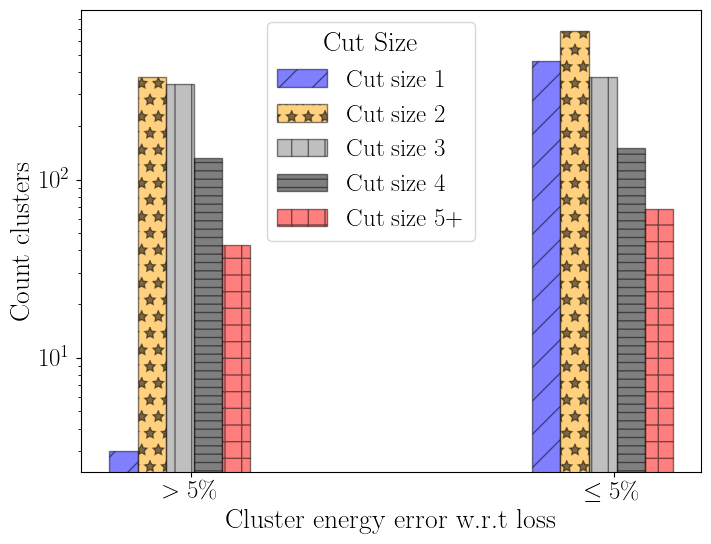

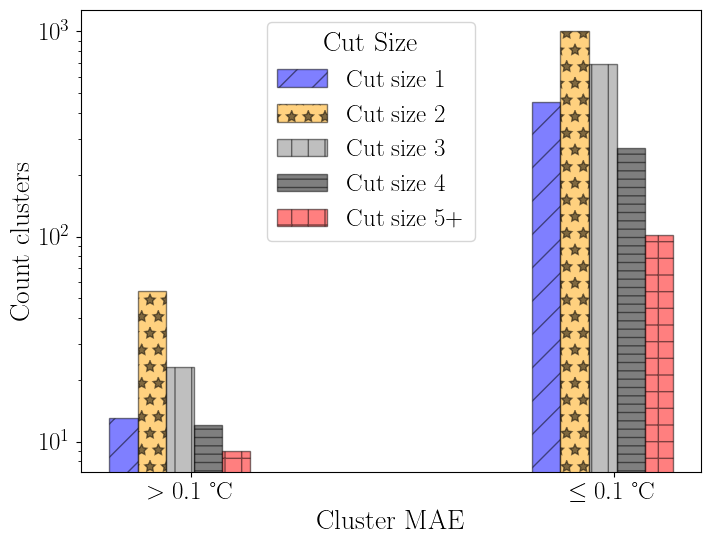

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define bins and bar width for dodging
bins = np.arange(df_merged_tables_new['goodness_energy'].min(), df_merged_tables_new['goodness_energy'].max() + 0.25, 0.25)
width = 0.25 / 5  # Divide binwidth by number of categories (5 here)

# Define hatch patterns for each cut_size
hatch_patterns = ['/', '*', '|', '--', '+']  # One for each of [1, 2, 3, 4, 5]
cut_sizes = [1, 2, 3, 4, 5]
labels = ['Cut size 1', 'Cut size 2', 'Cut size 3', 'Cut size 4', 'Cut size 5+']
colors = ['blue', 'orange', 'grey', 'black', 'red']

# Plot dodged bars with hatch patterns
for i, (cut_size, hatch, label) in enumerate(zip(cut_sizes, hatch_patterns, labels)):
    hist, _ = np.histogram(
        df_merged_tables_new[df_merged_tables_new['cut_size_modified'] == cut_size]['goodness_energy'], 
        bins=bins
    )
    ax.bar(
        bins[:-1] + i * width,  # Offset each bar for dodging
        hist,
        width=width,
        color=colors[i],  # Uniform color (no differentiation by color)
        hatch=hatch,   # Apply hatch pattern
        alpha=0.5,
        edgecolor='black',  # Outline for clarity
        label=label
    )

# Customize x-ticks and labels
ax.set_xticks([0.12, 0.87])
ax.set_xticklabels(["$> 5\\%$", "$\\leq 5\\%$"])
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Cluster energy error w.r.t loss')
ax.set_ylabel('Count clusters')

# Add legend
ax.legend(title='Cut Size', loc=(0.3, 0.5))

# Show plot
plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define bins and bar width for dodging
bins = np.arange(df_merged_tables_new['goodness_mae'].min(), df_merged_tables_new['goodness_mae'].max() + 0.25, 0.25)
width = 0.25 / 5  # Divide binwidth by number of categories (5 here)

# Define hatch patterns for each cut_size
hatch_patterns = ['/', '*', '|', '--', '+']  # One for each of [1, 2, 3, 4, 5]
cut_sizes = [1, 2, 3, 4, 5]
labels = ['Cut size 1', 'Cut size 2', 'Cut size 3', 'Cut size 4', 'Cut size 5+']
colors = ['blue', 'orange', 'grey', 'black', 'red']

# Plot dodged bars with hatch patterns
for i, (cut_size, hatch, label) in enumerate(zip(cut_sizes, hatch_patterns, labels)):
    hist, _ = np.histogram(
        df_merged_tables_new[df_merged_tables_new['cut_size_modified'] == cut_size]['goodness_mae'], 
        bins=bins
    )
    ax.bar(
        bins[:-1] + i * width,  # Offset each bar for dodging
        hist,
        width=width,
        color=colors[i],  # Uniform color (no differentiation by color)
        hatch=hatch,   # Apply hatch pattern
        alpha=0.5,
        edgecolor='black',  # Outline for clarity
        label=label
    )

# Customize x-ticks and labels
ax.set_xticks([0.12, 0.87])
ax.set_xticklabels(["$> 0.1$ °C", "$\\leq 0.1$ °C"])
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Cluster MAE')
ax.set_ylabel('Count clusters')

# Add legend
ax.legend(title='Cut Size', loc=(0.3, 0.5))

# Show plot
plt.show()

In [ ]:
linear_interpol = LogisticRegression(fit_intercept=True)
X_data = df_merged_tables_new[['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh', 'cut_size_modified']]
X_data /= X_data.max()
Y_data = df_merged_tables_new[['goodness_mae']]
linear_interpol.fit(X_data, Y_data)
print(linear_interpol.intercept_)
print(linear_interpol.coef_)
print(linear_interpol.score(X_data,Y_data))

# Example usage with your data
intercept = linear_interpol.intercept_
coefficients = linear_interpol.coef_[0]
variables = ['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh', 'cut_size_modified']

# Compute thresholds with all other variables set to 0
thresholds = compute_goodness_thresholds(intercept, coefficients, variables)
print("Individual thresholds (others = 0):")
for var, thresh in thresholds.items():
    print(f"{var}: {thresh}")

[3.87683937]
[[-3.63966712 -0.89637367 -0.76150345 -0.2999228  -0.89951916]]
0.957970465732677
Individual thresholds (others = 0):
max_delay_time: [1.06516317]
mean_delay_time: [4.32502594]
median_delay_time: [5.0910332]
energy_loss_mwh: [12.92612426]
cut_size_modified: [4.30990192]


d:\PhD DATA\Codes & Works\Works_current\Part 2 - clusters_identification\.env\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
linear_interpol = LogisticRegression(fit_intercept=True)
X_data = df_merged_tables_new[['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh', 'cut_size_modified']]
# X_data /= X_data.max()
Y_data = df_merged_tables_new[['goodness_energy']]
linear_interpol.fit(X_data, Y_data)
print(linear_interpol.intercept_)
print(linear_interpol.coef_)
print(linear_interpol.score(X_data,Y_data))

# Example usage with your data
intercept = linear_interpol.intercept_
coefficients = linear_interpol.coef_[0]
variables = ['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh', 'cut_size_modified']

# Compute thresholds with all other variables set to 0
thresholds = compute_goodness_thresholds(intercept, coefficients, variables)
print("Individual thresholds (others = 0):")
for var, thresh in thresholds.items():
    print(f"{var}: {thresh}")

[1.96825419]
[[ 2.94007956e-03  1.75164750e-03 -4.80027006e-03  9.55614444e-05
  -6.51729583e-01]]
0.6664142370314274
Individual thresholds (others = 0):
max_delay_time: [-669.45609717]
mean_delay_time: [-1123.65883297]
median_delay_time: [410.02988716]
energy_loss_mwh: [-20596.73963066]
cut_size_modified: [3.02004733]


d:\PhD DATA\Codes & Works\Works_current\Part 2 - clusters_identification\.env\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df_merged_tables_new.columns

Index(['key', 'nodes', 'size', 'cluster_has_loop', 'density',
       'internal_degree', 'scaled_density', 'nodes_mean_internal_indegree',
       'nodes_sum_internal_indegree', 'nodes_max_internal_indegree',
       'nodes_mean_internal_outdegree', 'nodes_sum_internal_outdegree',
       'nodes_max_internal_outdegree', 'nodes_mean_internal_degree',
       'nodes_sum_internal_degree', 'nodes_max_internal_degree',
       'average_outdegree_fraction', 'max_outdegree_fraction',
       'average_indegree_fraction', 'max_indegree_fraction', 'cut_size',
       'cut_ratio', 'conductance', 'nb_upstream_interfaces',
       'nb_downstream_interfaces', 'max_diameter', 'mean_delay_time',
       'min_delay_time', 'max_delay_time', 'std_delay_time',
       'median_delay_time', 'e_loss_wrt_energy_through',
       'e_loss_wrt_energy_consumed', 'total_e_loss_wh', 'mean_ts_tr_distance',
       'mean_demands_distance', 'mean_pipes_loss', 'dhn_id', 'unique_key',
       'mae', 'energy_mae', 'energy_mare_per_los

In [ ]:
df_merged_tables_new['multi_mean_median_transport_delay_time'] = df_merged_tables_new['mean_delay_time'] * df_merged_tables_new['median_delay_time']
df_merged_tables_new['sum_mean_median_transport_delay_time'] = df_merged_tables_new['mean_delay_time'] + df_merged_tables_new['median_delay_time']

In [ ]:
# Function to compute Spearman correlation for all pairs
def spearman_correlation_matrix(df, variables):
    # Select the relevant columns
    subset = df[variables]
    
    # Compute Spearman correlation matrix
    corr_matrix, p_matrix = spearmanr(subset)

    corr_matrix[p_matrix > 0.05] = 0.0
    
    # Convert to DataFrame for better readability
    corr_df = pd.DataFrame(corr_matrix, index=variables, columns=variables)
    p_df = pd.DataFrame(p_matrix, index=variables, columns=variables)
    
    return corr_df, p_df

# Define variables of interest
variables = ['mae', 'energy_mae', 'energy_mare_per_loss', 
              'size', 'energy_loss_wh', 'cut_size_modified', 'max_delay_time',
              'mean_delay_time','median_delay_time', 'multi_mean_median_transport_delay_time', 'sum_mean_median_transport_delay_time']

# Calculate Spearman correlation and p-values
corr_df, p_df = spearman_correlation_matrix(df_merged_tables_new, variables)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Display results
# print("Spearman Correlation Matrix:")
# print(corr_df)
# print("\nP-Value Matrix:")
# print(p_df)


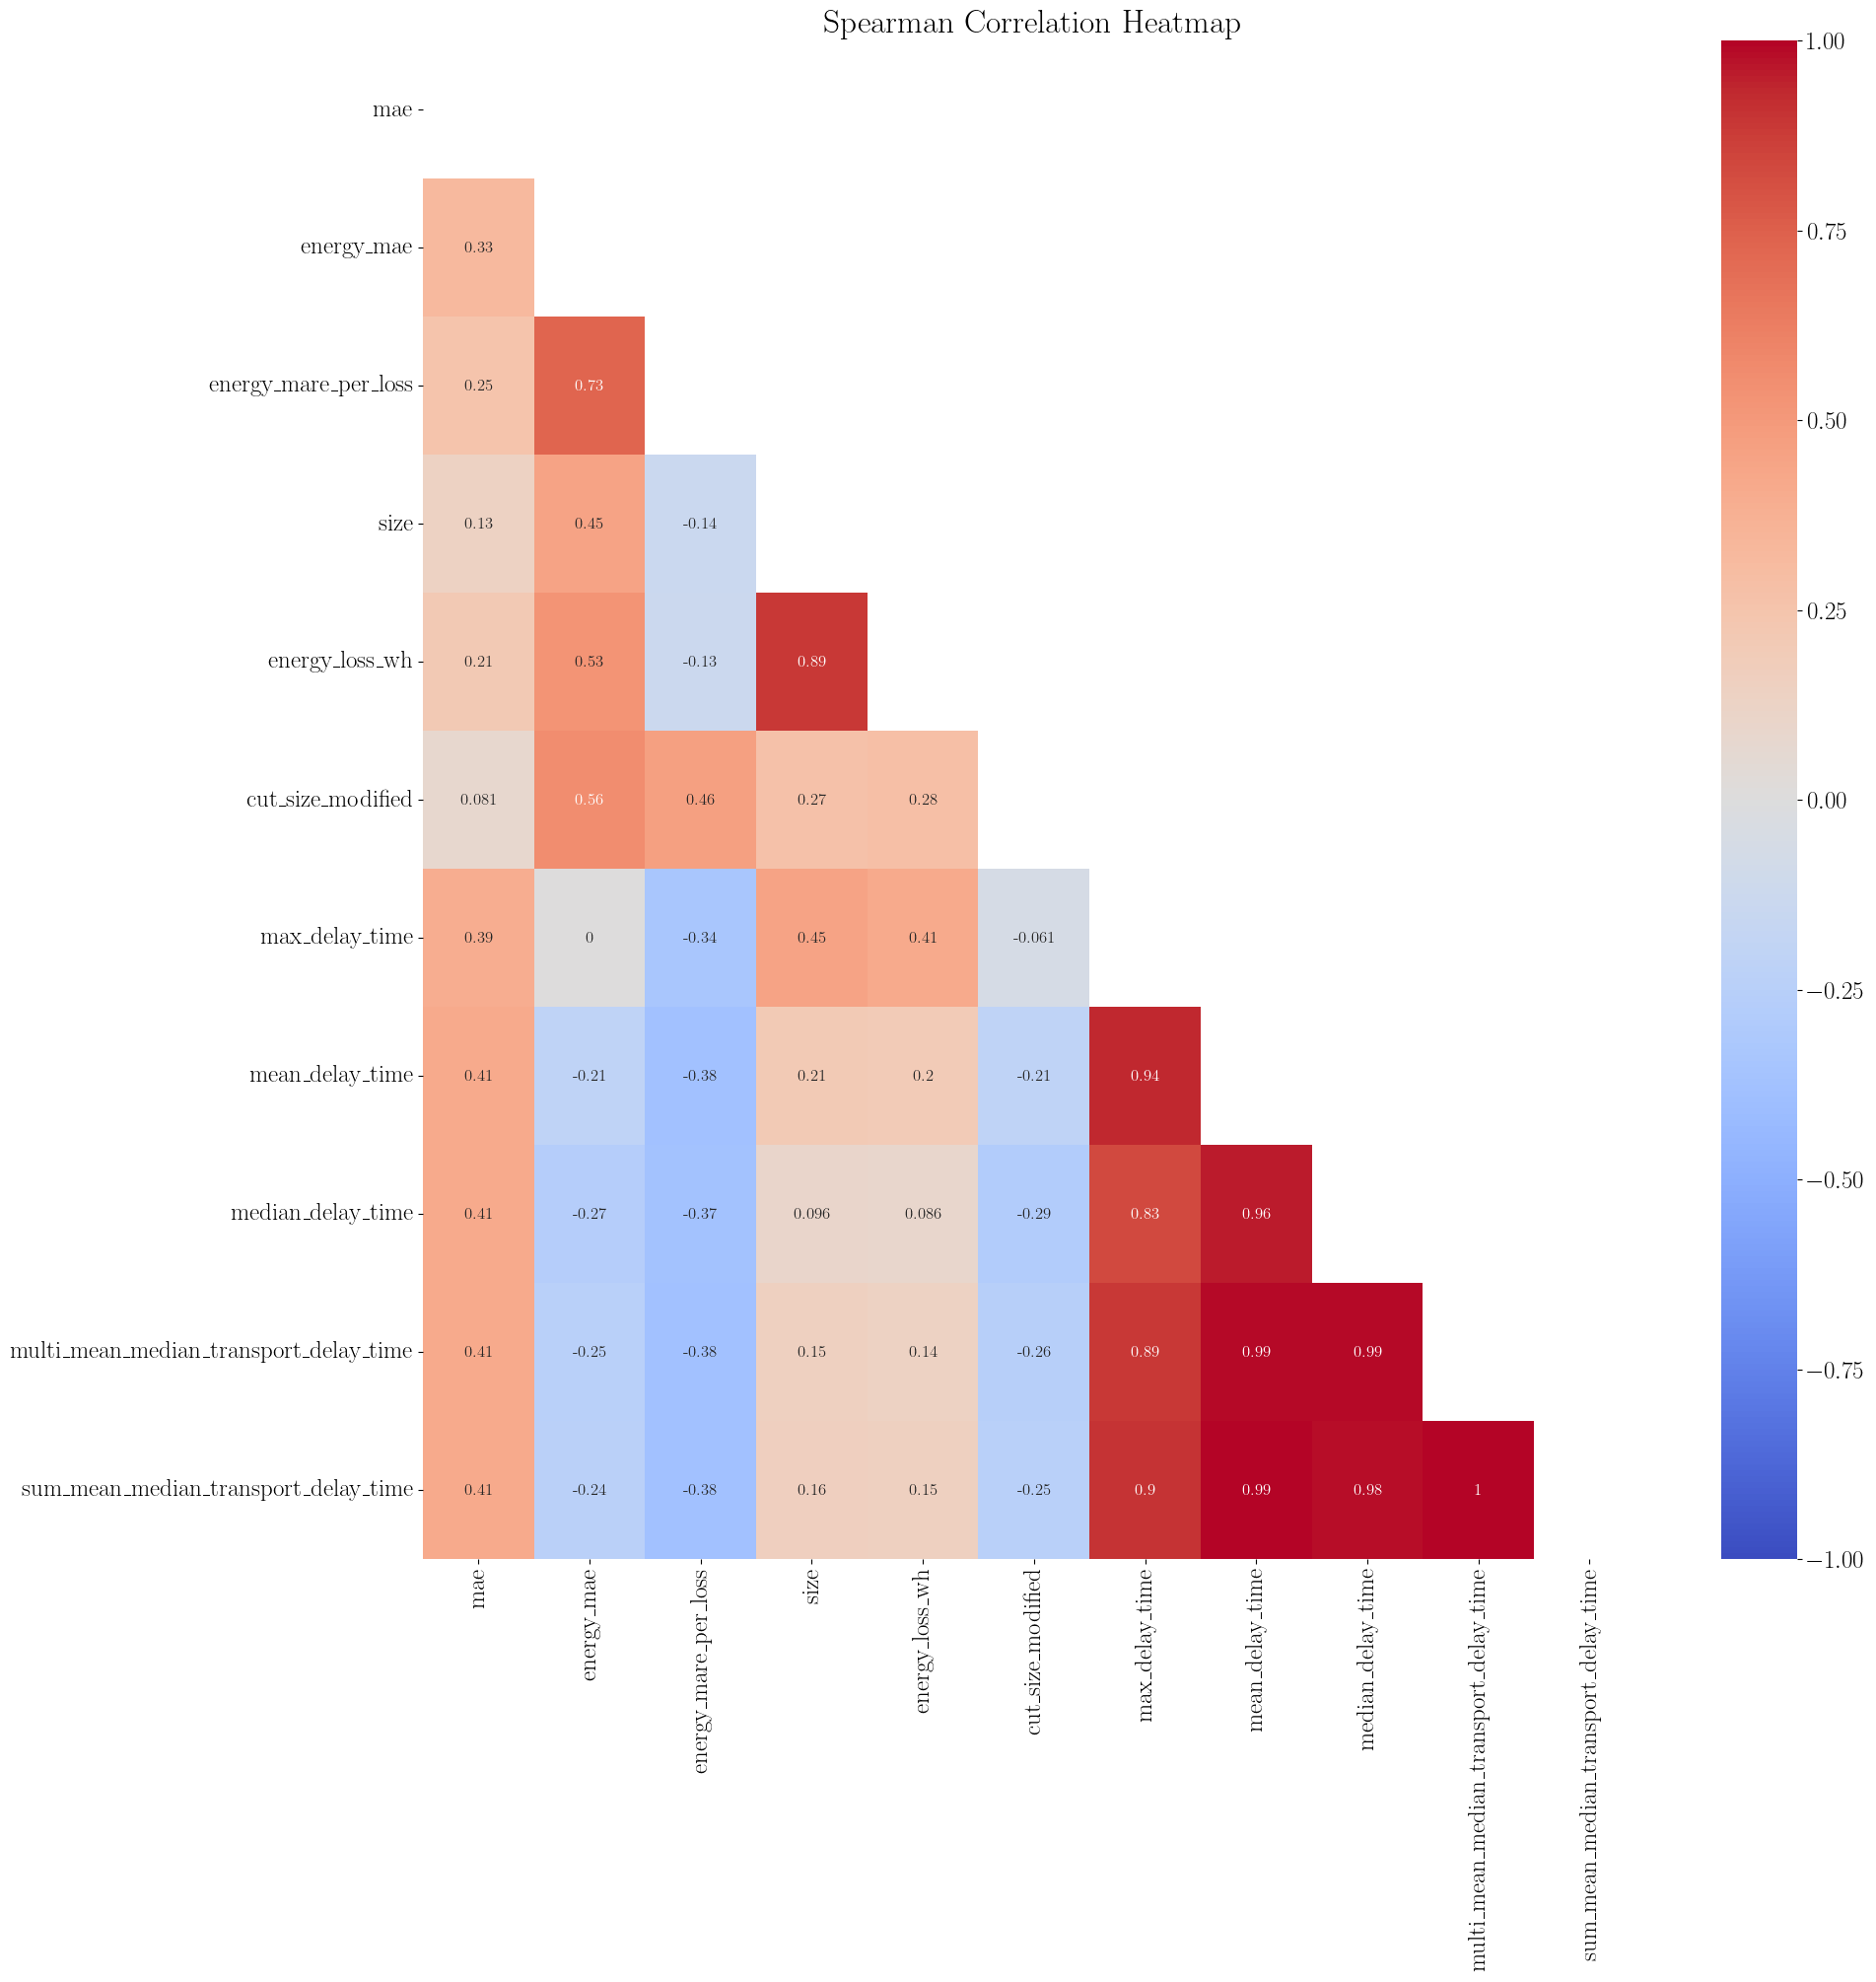

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))
# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, mask=mask, annot_kws={"size": 12})
plt.title("Spearman Correlation Heatmap")
plt.show()

In [8]:
round(0.870001, ndigits=2)

0.87

In [ ]:

plt.figure(figsize=(10,8))
# Optional: Pairplot to visualize relationships
sns.pairplot(df_merged_tables_new[variables], kind='scatter', diag_kind='kde')
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, mask=mask)
plt.title("Spearman Correlation Heatmap")
plt.show()

## Per cut sizes

In [ ]:
metrics_considered_per_cut_size = ['density',
        'internal_degree',
        'scaled_density',
        'size',
        'nodes_mean_internal_indegree',
        'nodes_sum_internal_indegree',
        'nodes_max_internal_indegree',
        'nodes_mean_internal_outdegree',
        'nodes_sum_internal_outdegree',
        'nodes_max_internal_outdegree',
        'nodes_mean_internal_degree',
        'nodes_sum_internal_degree',
        'nodes_max_internal_degree',
        'average_outdegree_fraction',
        'max_outdegree_fraction',
        'average_indegree_fraction',
        'max_indegree_fraction',
        'cut_ratio',
        'conductance',
        'mean_ts_tr_distance',
        'mean_demands_distance',
        'mean_pipes_loss',
        'max_diameter',
        'mean_delay_time',
        'min_delay_time',
        'max_delay_time',
        'std_delay_time',
        'median_delay_time',
        'energy_loss_mwh']

#### Cut size 1

In [ ]:
df_clusters_cut_size_1 = df_merged_tables_new[df_merged_tables_new['cut_size_modified'] == 1]

In [ ]:
correlations_cut_size_1, mis_cut_size_1 = get_corr_mi_from_metrics(df_clusters_cut_size_1,targets, metrics_considered_per_cut_size)

C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120

In [ ]:
df_correlations_cut_size_1 = pd.DataFrame.from_dict(correlations_cut_size_1)
df_correlations_cut_size_1

,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,0.000000,-0.679823,-0.679823,0.155382
internal_degree,0.000000,0.683711,0.683711,-0.152684
scaled_density,0.000000,0.371671,0.371671,0.000000
size,0.000000,0.685545,0.685545,-0.154286
nodes_mean_internal_indegree,0.000000,0.650280,0.650280,-0.190411
nodes_sum_internal_indegree,0.000000,0.683711,0.683711,-0.152684
nodes_max_internal_indegree,0.000000,0.443637,0.443637,0.000000
nodes_mean_internal_outdegree,0.000000,0.650280,0.650280,-0.190411
nodes_sum_internal_outdegree,0.000000,0.683711,0.683711,-0.152684
nodes_max_internal_outdegree,0.000000,0.696743,0.696743,0.000000


In [ ]:
df_mis_cut_size_1 = pd.DataFrame.from_dict(mis_cut_size_1)
df_mis_cut_size_1

,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,0.000000,0.416595,0.416595,0.104419
internal_degree,0.000000,0.368412,0.368412,0.000000
scaled_density,0.000000,0.448661,0.448661,0.216028
size,0.000000,0.383824,0.383824,0.000000
nodes_mean_internal_indegree,0.000000,0.317727,0.317727,0.000000
nodes_sum_internal_indegree,0.000000,0.368412,0.368412,0.000000
nodes_max_internal_indegree,0.000000,0.174564,0.174564,0.000000
nodes_mean_internal_outdegree,0.000000,0.317727,0.317727,0.000000
nodes_sum_internal_outdegree,0.000000,0.368412,0.368412,0.000000
nodes_max_internal_outdegree,0.000000,0.315774,0.315774,0.111088


In [ ]:
linear_interpol = LogisticRegression(fit_intercept=True)
X_data = df_clusters_cut_size_1[['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh']]
Y_data = df_clusters_cut_size_1[['goodness_mae']]
linear_interpol.fit(X_data, Y_data)
print(linear_interpol.intercept_)
print(linear_interpol.coef_)
print(linear_interpol.score(X_data,Y_data))

# Example usage with your data
intercept = linear_interpol.intercept_
coefficients = linear_interpol.coef_[0]
variables = ['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh']

# Compute thresholds with all other variables set to 0
thresholds = compute_goodness_thresholds(intercept, coefficients, variables)
print("Individual thresholds (others = 0):")
for var, thresh in thresholds.items():
    print(f"{var}: {thresh}")


[4.75810644]
[[-5.87619527e-04  1.26348956e-03 -1.19128057e-03  2.07567284e-05]]
0.9786324786324786
Individual thresholds (others = 0):
max_delay_time: [8097.25717947]
mean_delay_time: [-3765.8454567]
median_delay_time: [3994.11066625]
energy_loss_mwh: [-229232.0031201]


d:\PhD DATA\Codes & Works\Works_current\Part 2 - clusters_identification\.env\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df_clusters_cut_size_1[df_clusters_cut_size_1['goodness_energy'] == 1].median(numeric_only=True)[['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh']]

max_delay_time        43.114863
mean_delay_time       26.015543
median_delay_time     22.507482
energy_loss_mwh      191.705693
dtype: float64

In [ ]:
df_clusters_cut_size_1[df_clusters_cut_size_1['goodness_energy'] == 0].median(numeric_only=True)[['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh']]

max_delay_time       19.83789
mean_delay_time      19.83789
median_delay_time    19.83789
energy_loss_mwh      36.90270
dtype: float64

In [ ]:
df_clusters_cut_size_1[['mae', 'energy_mare_per_loss']].sort_values(by=['energy_mare_per_loss'], ascending=False)

,mae,energy_mare_per_loss
987,0.588751,109.913463
773,0.068721,7.401416
637,0.069539,6.572347
1368,0.040154,4.805097
1370,0.050674,4.774718
...,...,...
1487,0.005300,0.052350
522,0.003162,0.046947
1489,0.005072,0.044943
518,0.002979,0.044297


<Axes: xlabel='goodness_mae', ylabel='mean_delay_time'>

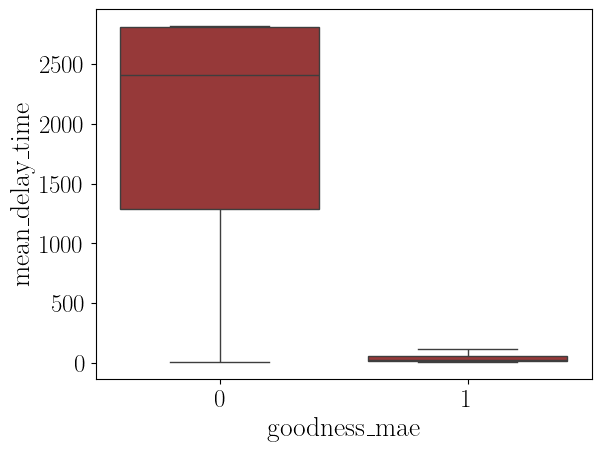

In [ ]:
# df_ = df_clusters_cut_size_1[['max_delay_time', 'mean_delay_time', 'energy_loss_mwh', 'size']]
sns.boxplot(df_clusters_cut_size_1, x='goodness_mae', y='mean_delay_time', showfliers=False)

### Cut size 2

In [ ]:
df_clusters_cut_size_2 = df_merged_tables_new[df_merged_tables_new['cut_size_modified'] == 2]
print(f'Length = {len(df_clusters_cut_size_2)}')

Length = 1059


In [ ]:
correlations_cut_size_2, mis_cut_size_2 = get_corr_mi_from_metrics(df_clusters_cut_size_2,targets, metrics_considered_per_cut_size)

In [ ]:
df_correlations_cut_size_2 = pd.DataFrame.from_dict(correlations_cut_size_2)
df_correlations_cut_size_2

,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,0.000000,-0.363576,-0.363576,0.282995
internal_degree,0.000000,0.352558,0.352558,-0.288779
scaled_density,0.000000,0.000000,0.000000,0.000000
size,0.000000,0.351444,0.351444,-0.289283
nodes_mean_internal_indegree,0.000000,0.328607,0.328607,-0.281967
nodes_sum_internal_indegree,0.000000,0.352558,0.352558,-0.288779
nodes_max_internal_indegree,0.000000,0.000000,0.000000,0.000000
nodes_mean_internal_outdegree,0.000000,0.328607,0.328607,-0.281967
nodes_sum_internal_outdegree,0.000000,0.352558,0.352558,-0.288779
nodes_max_internal_outdegree,0.000000,0.348357,0.348357,-0.406780


In [ ]:
df_mis_cut_size_2 = pd.DataFrame.from_dict(mis_cut_size_2)
df_mis_cut_size_2

,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,0.000000,0.000000,0.000000,0.117791
internal_degree,0.000000,0.000000,0.000000,0.000000
scaled_density,0.105850,0.000000,0.000000,0.181398
size,0.000000,0.000000,0.000000,0.000000
nodes_mean_internal_indegree,0.000000,0.000000,0.000000,0.126324
nodes_sum_internal_indegree,0.000000,0.000000,0.000000,0.000000
nodes_max_internal_indegree,0.000000,0.000000,0.000000,0.000000
nodes_mean_internal_outdegree,0.000000,0.000000,0.000000,0.126324
nodes_sum_internal_outdegree,0.000000,0.000000,0.000000,0.000000
nodes_max_internal_outdegree,0.000000,0.000000,0.000000,0.155075


In [ ]:
# linear_interpol = LinearRegression(fit_intercept=True)

# X_data = df_clusters_cut_size_2[['mean_pipes_loss', 'max_delay_time', 'mean_delay_time', 'median_delay_time']]
# Y_data_classification = df_clusters_cut_size_2['goodness']

# from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
# decision_tree = DecisionTreeClassifier(criterion='log_loss', splitter='best', max_depth=3)
# decision_tree.fit(X_data, Y_data_classification)

# print(f'Score classifier tree : ', decision_tree.score(X_data, Y_data_classification))
# tree_rules = export_text(decision_tree, feature_names=['mean_pipes_loss', 'max_delay_time', 'mean_delay_time', 'median_delay_time'])
# print(tree_rules)

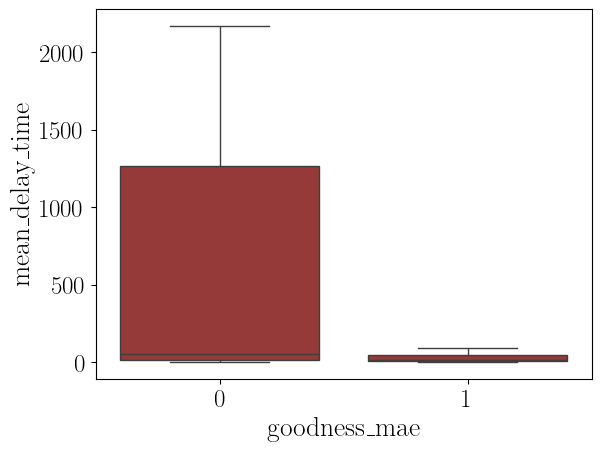

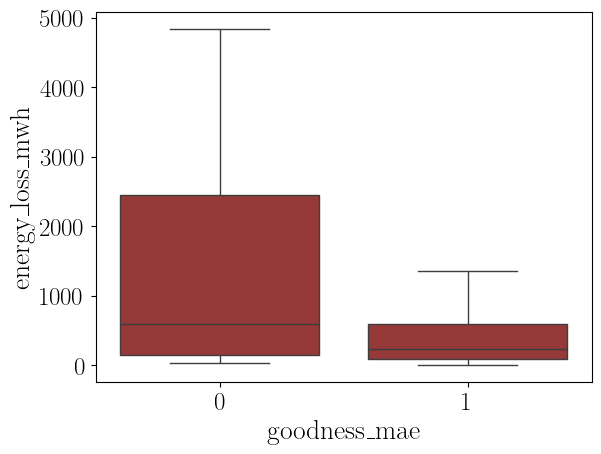

In [ ]:
# df_ = df_clusters_cut_size_1[['max_delay_time', 'mean_delay_time', 'energy_loss_mwh', 'size']]
sns.boxplot(df_clusters_cut_size_2, x='goodness_mae', y='mean_delay_time', showfliers=False)
plt.show()
sns.boxplot(df_clusters_cut_size_2, x='goodness_mae', y='energy_loss_mwh', showfliers=False)
plt.show()

In [ ]:
linear_interpol = LogisticRegression(fit_intercept=True)
X_data = df_clusters_cut_size_2[['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh']]
Y_data = df_clusters_cut_size_2[['goodness_mae']]
linear_interpol.fit(X_data, Y_data)
print(linear_interpol.intercept_)
print(linear_interpol.coef_)
print(linear_interpol.score(X_data,Y_data))

# Example usage with your data
intercept = linear_interpol.intercept_
coefficients = linear_interpol.coef_[0]
variables = ['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh']

# Compute thresholds with all other variables set to 0
thresholds = compute_goodness_thresholds(intercept, coefficients, variables)
print("Individual thresholds (others = 0):")
for var, thresh in thresholds.items():
    print(f"{var}: {thresh}")


[3.2163748]
[[-5.55631466e-04  2.27638173e-03 -2.01072195e-03 -3.22216699e-06]]
0.947119924457035
Individual thresholds (others = 0):
max_delay_time: [5788.68368229]
mean_delay_time: [-1412.93296837]
median_delay_time: [1599.61191967]
energy_loss_mwh: [998202.39281077]


d:\PhD DATA\Codes & Works\Works_current\Part 2 - clusters_identification\.env\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Cut size 3

In [ ]:
df_clusters_cut_size_3 = df_merged_tables_new[df_merged_tables_new['cut_size_modified'] == 3]
print(f'Length = {len(df_clusters_cut_size_3)}')

Length = 720


In [ ]:
correlations_cut_size_3, mis_cut_size_3 = get_corr_mi_from_metrics(df_clusters_cut_size_3, targets, metrics_considered_per_cut_size)
df_correlations_cut_size_3 = pd.DataFrame.from_dict(correlations_cut_size_3)
df_correlations_cut_size_3

,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,0.000000,-0.370567,-0.370567,0.347233
internal_degree,0.000000,0.369040,0.369040,-0.344990
scaled_density,0.000000,-0.250009,-0.250009,-0.348196
size,0.000000,0.367739,0.367739,-0.350802
nodes_mean_internal_indegree,0.000000,0.311896,0.311896,-0.355032
nodes_sum_internal_indegree,0.000000,0.369040,0.369040,-0.344990
nodes_max_internal_indegree,0.000000,0.000000,0.000000,0.000000
nodes_mean_internal_outdegree,0.000000,0.311896,0.311896,-0.355032
nodes_sum_internal_outdegree,0.000000,0.369040,0.369040,-0.344990
nodes_max_internal_outdegree,0.000000,0.000000,0.000000,-0.492080


In [ ]:
linear_interpol = LogisticRegression(fit_intercept=True)
X_data = df_clusters_cut_size_3[['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh']]
Y_data = df_clusters_cut_size_3[['goodness_mae']]
linear_interpol.fit(X_data, Y_data)
print(linear_interpol.intercept_)
print(linear_interpol.coef_)
print(linear_interpol.score(X_data,Y_data))

# Example usage with your data
intercept = linear_interpol.intercept_
coefficients = linear_interpol.coef_[0]
variables = ['max_delay_time', 'mean_delay_time', 'median_delay_time', 'energy_loss_mwh']

# Compute thresholds with all other variables set to 0
thresholds = compute_goodness_thresholds(intercept, coefficients, variables)
print("Individual thresholds (others = 0):")
for var, thresh in thresholds.items():
    print(f"{var}: {thresh}")


[3.70055014]
[[-1.73157626e-03  6.72774905e-03 -3.84546812e-03 -5.29667126e-05]]
0.9694444444444444
Individual thresholds (others = 0):
max_delay_time: [2137.09914679]
mean_delay_time: [-550.04283216]
median_delay_time: [962.31460596]
energy_loss_mwh: [69865.58076391]


d:\PhD DATA\Codes & Works\Works_current\Part 2 - clusters_identification\.env\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


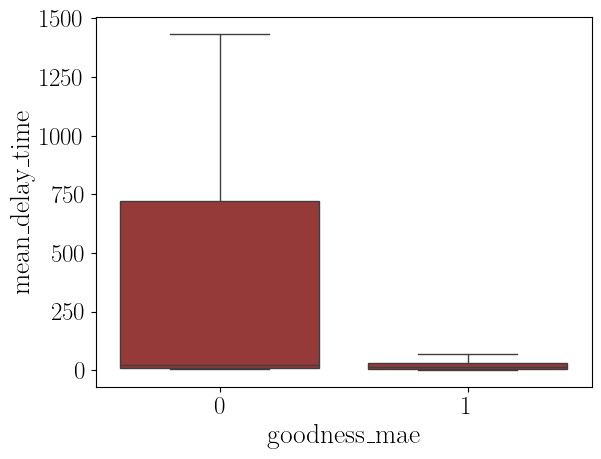

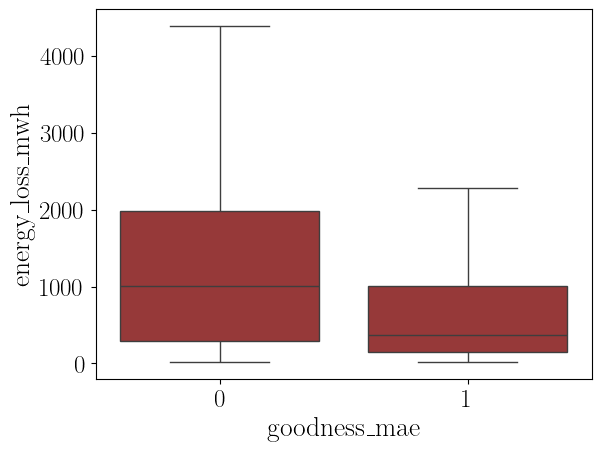

In [ ]:
# df_ = df_clusters_cut_size_1[['max_delay_time', 'mean_delay_time', 'energy_loss_mwh', 'size']]
sns.boxplot(df_clusters_cut_size_3, x='goodness_mae', y='mean_delay_time', showfliers=False)
plt.show()
sns.boxplot(df_clusters_cut_size_3, x='goodness_mae', y='energy_loss_mwh', showfliers=False)
plt.show()

#### Cut size 4

In [ ]:
df_clusters_cut_size_4 = df_merged_tables_new[df_merged_tables_new['cut_size_modified'] == 4]
print(f'Length = {len(df_clusters_cut_size_4)}')

Length = 283


In [ ]:
correlations_cut_size_4, mis_cut_size_4 = get_corr_mi_from_metrics(df_clusters_cut_size_4, targets, metrics_considered_per_cut_size)
df_correlations_cut_size_4 = pd.DataFrame.from_dict(correlations_cut_size_4)
df_correlations_cut_size_4

C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')


,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,0.000000,-0.364278,-0.364278,0.400506
internal_degree,0.000000,0.345809,0.345809,-0.414874
scaled_density,-0.340038,0.000000,0.000000,-0.395802
size,0.000000,0.373688,0.373688,-0.400350
nodes_mean_internal_indegree,0.000000,0.343433,0.343433,-0.393969
nodes_sum_internal_indegree,0.000000,0.345809,0.345809,-0.414874
nodes_max_internal_indegree,0.000000,0.000000,0.000000,-0.416519
nodes_mean_internal_outdegree,0.000000,0.343433,0.343433,-0.393969
nodes_sum_internal_outdegree,0.000000,0.345809,0.345809,-0.414874
nodes_max_internal_outdegree,0.000000,0.000000,0.000000,-0.562839


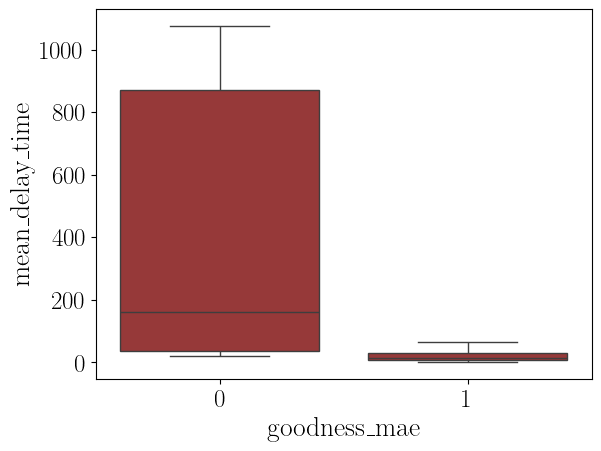

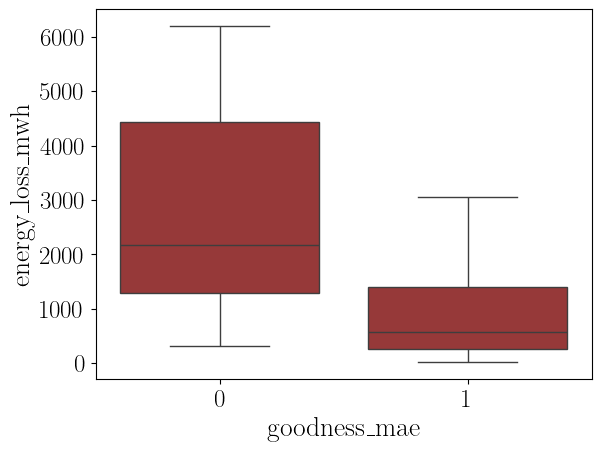

In [ ]:
# df_ = df_clusters_cut_size_1[['max_delay_time', 'mean_delay_time', 'energy_loss_mwh', 'size']]
sns.boxplot(df_clusters_cut_size_4, x='goodness_mae', y='mean_delay_time', showfliers=False)
plt.show()
sns.boxplot(df_clusters_cut_size_4, x='goodness_mae', y='energy_loss_mwh', showfliers=False)
plt.show()

#### Cut size 5+

In [ ]:
df_clusters_cut_size_5 = df_merged_tables_new[df_merged_tables_new['cut_size_modified'] == 5]
print(f'Length = {len(df_clusters_cut_size_5)}')

Length = 111


In [ ]:
correlations_cut_size_5, mis_cut_size_5 = get_corr_mi_from_metrics(df_clusters_cut_size_5, targets, metrics_considered_per_cut_size)
df_correlations_cut_size_5 = pd.DataFrame.from_dict(correlations_cut_size_5)
df_correlations_cut_size_5

C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')
C:\Users\d22rodri\AppData\Local\Temp\ipykernel_22120\1779790462.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sp = spearmanr(df_mean[el], df_mean[target], alternative='two-sided')


,mae,energy_mae,energy_error_mwh,energy_mare_per_loss
density,-0.225003,-0.512280,-0.512280,0.277186
internal_degree,0.267922,0.535837,0.535837,-0.245950
scaled_density,-0.423086,0.000000,0.000000,-0.531502
size,0.270314,0.521448,0.521448,-0.252935
nodes_mean_internal_indegree,0.000000,0.464187,0.464187,-0.287195
nodes_sum_internal_indegree,0.267922,0.535837,0.535837,-0.245950
nodes_max_internal_indegree,0.000000,0.000000,0.000000,0.000000
nodes_mean_internal_outdegree,0.000000,0.464187,0.464187,-0.287195
nodes_sum_internal_outdegree,0.267922,0.535837,0.535837,-0.245950
nodes_max_internal_outdegree,0.463753,0.000000,0.000000,0.000000


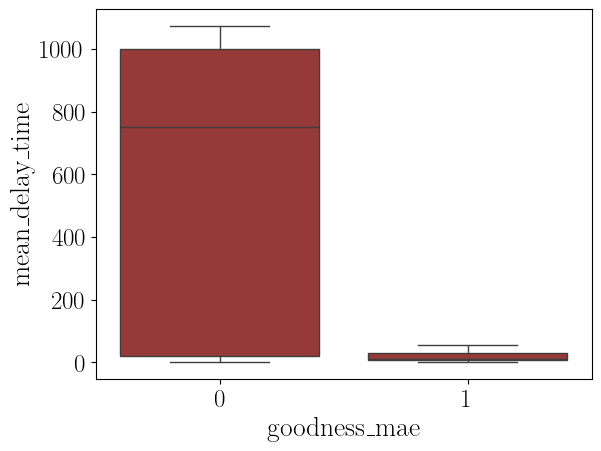

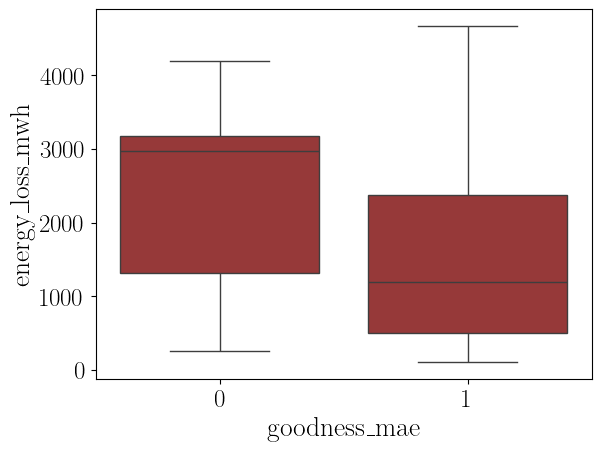

In [ ]:
# df_ = df_clusters_cut_size_1[['max_delay_time', 'mean_delay_time', 'energy_loss_mwh', 'size']]
sns.boxplot(df_clusters_cut_size_5, x='goodness_mae', y='mean_delay_time', showfliers=False)
plt.show()
sns.boxplot(df_clusters_cut_size_5, x='goodness_mae', y='energy_loss_mwh', showfliers=False)
plt.show()

## Clustering results

In [542]:
df_clustering_results = pd.DataFrame()

# Function to parse JSON-like strings
def parse_json(value):
    try:
        return ast.literal_eval(value)  # Convert string to dictionary safely
    except (ValueError, SyntaxError):
        return None  # Return None if parsing fails

def treat_csv_file(csv_file_path):
    # Load the CSV file
    df = pd.read_csv(csv_file_path, encoding="utf-8", delimiter=",", engine="python")

    # Remove unnecessary index column if present
    if df.columns[0].startswith("Unnamed"):
        df = df.iloc[:, 1:]

    # Apply parsing function to all cells
    df = df.applymap(parse_json)

    # Expanding dictionary values into separate columns
    df_expanded = df.applymap(lambda x: pd.Series(x) if isinstance(x, dict) else x)

    # Concatenating the expanded DataFrame
    df_cleaned = pd.concat([df_expanded[col].apply(pd.Series) for col in df_expanded.columns], axis=0)

    df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.duplicated()]

    return df_cleaned

for dhn_id in dhns_ids_considered:
    # path_metric = os.path.join('new_clusters_paradigm_saved', f'dhn_{dhn_id}', 'clusters_metrics.csv')
    # path_clusteirng_result = os.path.join('new_clusters_paradigm_saved', f'clustering_results_new_dhn_{dhn_id}_all.csv')
    # path_clusteirng_result = os.path.join('new_clusters_paradigm_saved', f'clustering_results_new_dhn_{dhn_id}_2hypr.csv')
    path_clusteirng_result = os.path.join(f'clustering_results_new_dhn_{dhn_id}.csv')
    if os.path.isfile(path_clusteirng_result):
        # df_t = treat_csv_file(path_clusteirng_result)
        df_t = pd.read_csv(path_clusteirng_result, index_col=0)
        df_t['dhn_id'] = dhn_id
        df_clustering_results = pd.concat([df_clustering_results, df_t], ignore_index=True)
df_clustering_results = df_clustering_results.dropna()
print(f"Total results found = {len(df_clustering_results)} from {len(df_clustering_results['dhn_id'].unique())} DHNs")
df_clustering_results.head()

Total results found = 171385 from 17 DHNs


,mean_size,mean_cluster_has_loop,mean_density,mean_internal_degree,mean_scaled_density,mean_nodes_mean_internal_indegree,mean_nodes_sum_internal_indegree,mean_nodes_max_internal_indegree,mean_nodes_mean_internal_outdegree,mean_nodes_sum_internal_outdegree,...,mean_topology_distance,mean_transport_distance,Count_clusters,Total_clustered_nodes,List_clusters,delta,alpha,beta,dhn_id,clusters_labels
0,2.0,0.0,0.5,1.0,1.0,0.5,1.0,1.0,0.5,1.0,...,2.0,229.944603,1,2,"[[69, 70]]",0.10,1.0,1.0,1,[37 65 52 58 55 69 67 38 47 57 61 59 44 53 68 ...
1,2.0,0.0,0.5,1.0,1.0,0.5,1.0,1.0,0.5,1.0,...,2.0,229.944603,1,2,"[[69, 70]]",0.11,1.0,1.0,1,[37 65 52 58 55 69 67 38 47 57 61 59 44 53 68 ...
2,2.0,0.0,0.5,1.0,1.0,0.5,1.0,1.0,0.5,1.0,...,2.0,229.944603,1,2,"[[69, 70]]",0.12,1.0,1.0,1,[37 65 52 58 55 69 67 38 47 57 61 59 44 53 68 ...
3,2.0,0.0,0.5,1.0,1.0,0.5,1.0,1.0,0.5,1.0,...,2.0,229.944603,1,2,"[[69, 70]]",0.13,1.0,1.0,1,[37 65 52 58 55 69 67 38 47 57 61 59 44 53 68 ...
4,2.0,0.0,0.5,1.0,1.0,0.5,1.0,1.0,0.5,1.0,...,2.0,229.944603,1,2,"[[69, 70]]",0.14,1.0,1.0,1,[37 65 52 58 55 69 67 38 47 57 61 59 44 53 68 ...


In [543]:
print(f"Beta = {df_clustering_results['beta'].unique()}")
print(f"Delta = {df_clustering_results['delta'].unique()}")
print(f"Alpha = {df_clustering_results['alpha'].unique()}")

Beta = [1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Delta = [0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99]
Alpha = [1.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [544]:
df_clustering_results['total_cut_sizes'] = df_clustering_results['mean_cut_size'] * df_clustering_results['Count_clusters']
total_size_dhns = {
    1: 71,
    2: 21,
    3: 61,
    4: 91,
    100: 82, 
    101: 97,
    102: 96,
    103: 190,
    104: 113, 
    105: 57,
    106: 63,
    108: 123,
    109: 60,
    110: 164,
    111: 33,
    112: 147,
    137: 169
}
df_clustering_results['Total_clustered_nodes'] = df_clustering_results.apply(lambda x: x['mean_size'] * x['Count_clusters'], axis=1)
df_clustering_results['Total_clustered_nodes_percent'] = df_clustering_results.apply(lambda x: 100* x['Total_clustered_nodes'] / total_size_dhns[x['dhn_id']], axis=1)
df_clustering_results['Remaining_nodes'] = 100 - df_clustering_results['Total_clustered_nodes_percent']

In [545]:
df_clustering_results[['Total_clustered_nodes', 'Total_clustered_nodes_percent']]

,Total_clustered_nodes,Total_clustered_nodes_percent
0,2.0,2.816901
1,2.0,2.816901
2,2.0,2.816901
3,2.0,2.816901
4,2.0,2.816901
...,...,...
185141,77.0,45.562130
185142,78.0,46.153846
185143,81.0,47.928994
185144,82.0,48.520710


In [546]:
dhns_ids_considered

[1, 2, 3, 4, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 137]

In [547]:
df_clustering_results['dhn_id'].unique()

array([  1,   2,   3,   4, 100, 101, 102, 103, 104, 105, 106, 108, 109,
       110, 111, 112, 137])

In [548]:
df_clustering_results.columns

Index(['mean_size', 'mean_cluster_has_loop', 'mean_density',
       'mean_internal_degree', 'mean_scaled_density',
       'mean_nodes_mean_internal_indegree', 'mean_nodes_sum_internal_indegree',
       'mean_nodes_max_internal_indegree',
       'mean_nodes_mean_internal_outdegree',
       'mean_nodes_sum_internal_outdegree',
       'mean_nodes_max_internal_outdegree', 'mean_nodes_mean_internal_degree',
       'mean_nodes_sum_internal_degree', 'mean_nodes_max_internal_degree',
       'mean_average_outdegree_fraction', 'mean_max_outdegree_fraction',
       'mean_average_indegree_fraction', 'mean_max_indegree_fraction',
       'mean_cut_size', 'mean_cut_ratio', 'mean_conductance',
       'mean_nb_upstream_interfaces', 'mean_nb_downstream_interfaces',
       'mean_max_diameter', 'mean_mean_delay_time', 'mean_min_delay_time',
       'mean_max_delay_time', 'mean_std_delay_time', 'mean_median_delay_time',
       'mean_e_loss_wrt_energy_through', 'mean_e_loss_wrt_energy_consumed',
       'mean

<Axes: xlabel='delta', ylabel='mean_cut_size'>

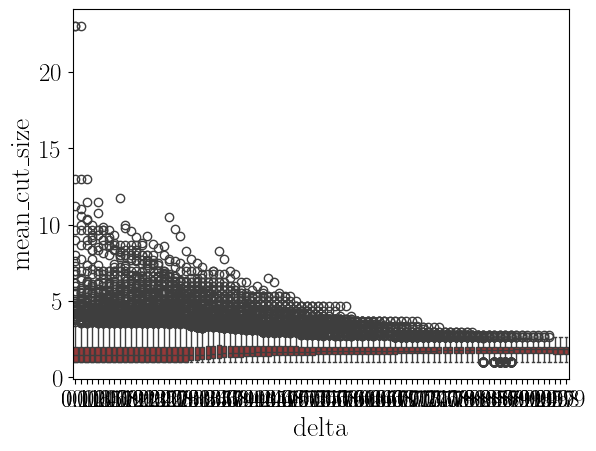

In [549]:
sns.boxplot(df_clustering_results, x='delta', y='mean_cut_size')

<Axes: xlabel='delta', ylabel='count'>

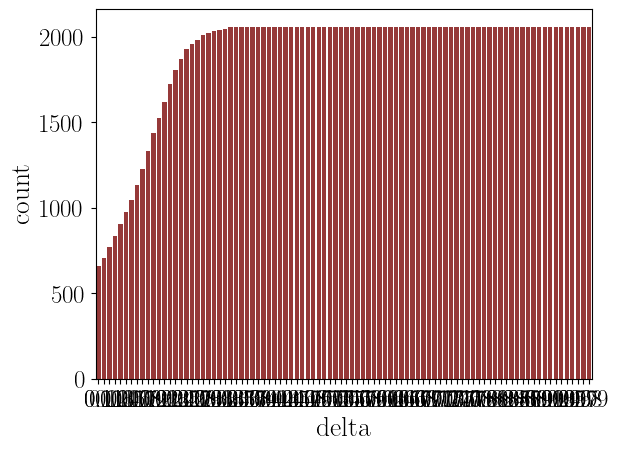

In [550]:
count_ = df_clustering_results.groupby(by=['delta'], as_index=False).count()
sns.countplot(df_clustering_results, x='delta')

Total: 90


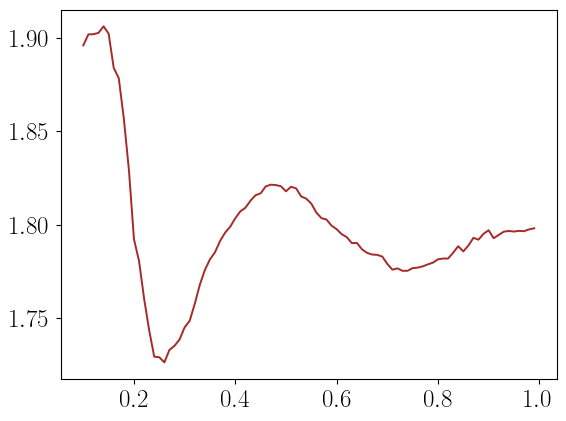

Total: 11


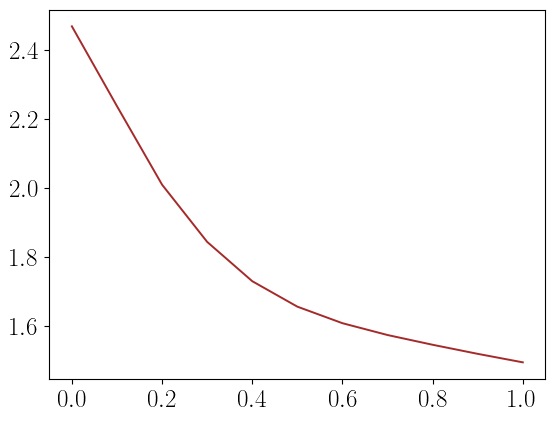

Total: 11


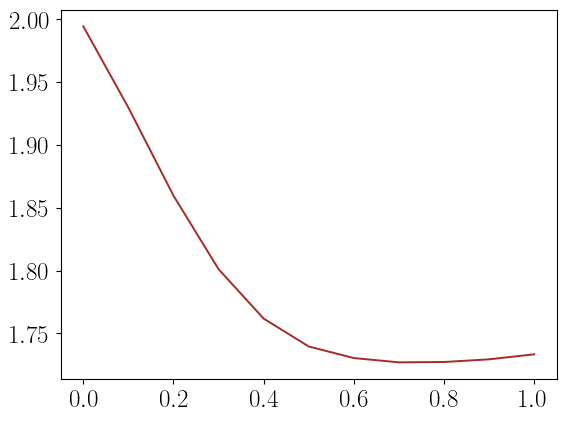

In [551]:
df_mean_by_delta = df_clustering_results.groupby(by=['delta'], as_index=False).mean(numeric_only=True)
print(f'Total: {len(df_mean_by_delta)}')
plt.plot(df_mean_by_delta['delta'], df_mean_by_delta['mean_cut_size'])
plt.show()

df_mean_by_alpha = df_clustering_results.groupby(by=['alpha'], as_index=False).mean(numeric_only=True)
print(f'Total: {len(df_mean_by_alpha)}')
plt.plot(df_mean_by_alpha['alpha'], df_mean_by_alpha['mean_cut_size'])
plt.show()

df_mean_by_beta = df_clustering_results.groupby(by=['beta'], as_index=False).mean(numeric_only=True)
print(f'Total: {len(df_mean_by_beta)}')
plt.plot(df_mean_by_beta['beta'], df_mean_by_beta['mean_cut_size'])
plt.show()
# plt.xlim([0.21,1.0])
# plt.ylim([1.2,1.8])

Total: 90


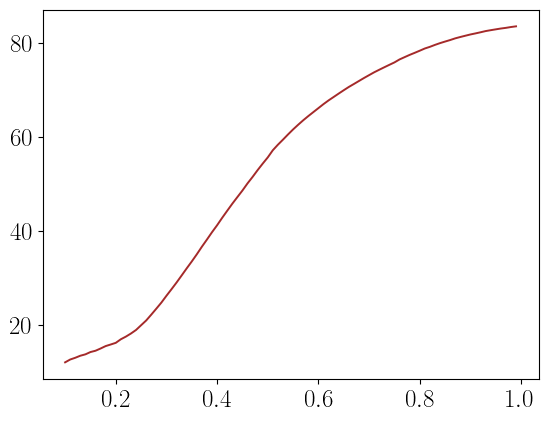

Total: 11


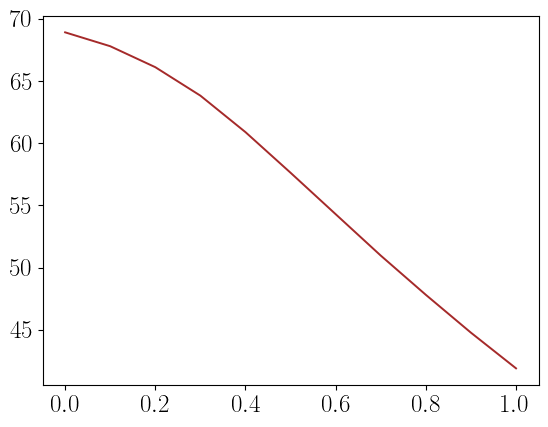

Total: 11


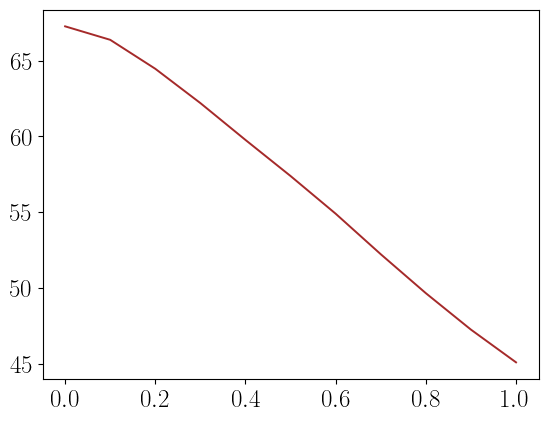

In [552]:
y_label = 'Total_clustered_nodes_percent'

df_mean_by_delta = df_clustering_results.groupby(by=['delta'], as_index=False).mean(numeric_only=True)
print(f'Total: {len(df_mean_by_delta)}')
plt.plot(df_mean_by_delta['delta'], df_mean_by_delta[y_label])
plt.show()

df_mean_by_alpha = df_clustering_results.groupby(by=['alpha'], as_index=False).mean(numeric_only=True)
print(f'Total: {len(df_mean_by_alpha)}')
plt.plot(df_mean_by_alpha['alpha'], df_mean_by_alpha[y_label])
plt.show()

df_mean_by_beta = df_clustering_results.groupby(by=['beta'], as_index=False).mean(numeric_only=True)
print(f'Total: {len(df_mean_by_beta)}')
plt.plot(df_mean_by_beta['beta'], df_mean_by_beta[y_label])
plt.show()

In [553]:
df_merged_tables.columns

Index(['key', 'nodes', 'size', 'cluster_has_loop', 'density',
       'internal_degree', 'scaled_density', 'nodes_mean_internal_indegree',
       'nodes_sum_internal_indegree', 'nodes_max_internal_indegree',
       'nodes_mean_internal_outdegree', 'nodes_sum_internal_outdegree',
       'nodes_max_internal_outdegree', 'nodes_mean_internal_degree',
       'nodes_sum_internal_degree', 'nodes_max_internal_degree',
       'average_outdegree_fraction', 'max_outdegree_fraction',
       'average_indegree_fraction', 'max_indegree_fraction', 'cut_size',
       'cut_ratio', 'conductance', 'nb_upstream_interfaces',
       'nb_downstream_interfaces', 'max_diameter', 'mean_delay_time',
       'min_delay_time', 'max_delay_time', 'std_delay_time',
       'median_delay_time', 'e_loss_wrt_energy_through',
       'e_loss_wrt_energy_consumed', 'total_e_loss_wh', 'mean_ts_tr_distance',
       'mean_demands_distance', 'mean_pipes_loss', 'dhn_id', 'unique_key',
       'mae', 'energy_mae', 'energy_mare_per_los

In [554]:
df_ml_performances = df_merged_tables_new[['mae', 'energy_error_mwh', 'energy_mare_per_loss', 'nodes', 'dhn_id']]

In [555]:
# Gets the cluster unique key

def generate_cluster_key(cluster_of_nodes, dhn_id, eval_=True):
    if eval_:
        cluster = ast.literal_eval(cluster_of_nodes)
    else:
        cluster = cluster_of_nodes
    # print(cluster)
    cluster.sort()
    name_ = '_'.join([str(i) for i in cluster])
    name_ += f'_{dhn_id}'
    return name_

df_ml_performances['merge_key'] = df_ml_performances.apply(lambda x: generate_cluster_key(x['nodes'], x['dhn_id']), axis=1)

C:\Users\d22rodri\AppData\Roaming\MobaXterm\slash\mx86_64b\var\log\xwin\ipykernel_14432\3327179833.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml_performances['merge_key'] = df_ml_performances.apply(lambda x: generate_cluster_key(x['nodes'], x['dhn_id']), axis=1)


In [556]:
# Merge clustering results with performances


def get_clustering_ml_performances(row):
    list_clusters = ast.literal_eval(row['List_clusters'])
    maes = []
    energy_errors = []
    energy_errors_mare = []

    for cluster in list_clusters:
        # print(cluster)
        # return 
        name_ = generate_cluster_key(cluster, row['dhn_id'], eval_=False)
        perf_row = df_ml_performances[df_ml_performances['merge_key'] == name_]

        if perf_row.empty:
            # print(f'Cluster {cluster} not found for dhn{dhn_id}')
            # maes.append(None)
            # energy_errors.append(None)
            # energy_errors_mare.append(None)
            continue
        else:
            maes.append(perf_row['mae'].values[0])
            energy_errors.append(perf_row['energy_error_mwh'].values[0])
            energy_errors_mare.append(perf_row['energy_mare_per_loss'].values[0])

    if len(maes) == 0:
        return None, None, None
    
    # Ensure consistency in output (always return three values)
    if any(x is not None for x in maes):  
        mean_mae = np.nanmean([x for x in maes if x is not None])
    else:
        mean_mae = None

    if any(x is not None for x in energy_errors):  
        mean_energy_error = np.nanmean([x for x in energy_errors if x is not None])
    else:
        mean_energy_error = None

    if any(x is not None for x in energy_errors_mare):  
        mean_energy_mare = np.nanmean([x for x in energy_errors_mare if x is not None])
    else:
        mean_energy_mare = None

    return mean_mae, mean_energy_error, mean_energy_mare

In [509]:
# Apply the function to each row and create new columns for the results
df_clustering_results[['mean_mae', 'mean_energy_error', 'mean_energy_mare']] = df_clustering_results.apply(get_clustering_ml_performances, axis=1, result_type='expand')

<Axes: xlabel='alpha', ylabel='count'>

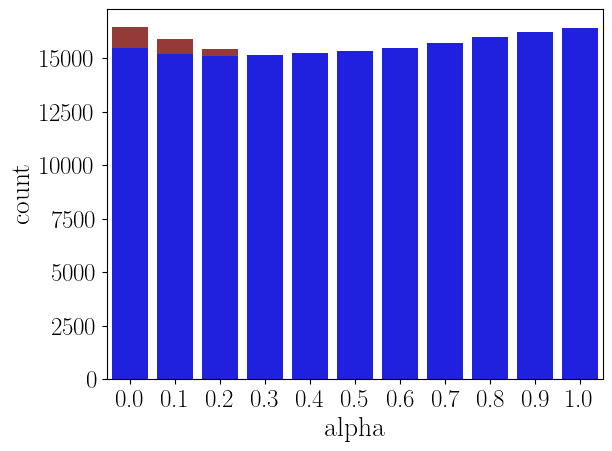

In [517]:
sns.countplot(df_clustering_results, x='alpha')
sns.countplot(df_clustering_results, x='beta')

In [518]:
# df_clustering_results_with_perfs = df_clustering_results[(df_clustering_results['alpha'] == 0.5) & (df_clustering_results['beta'] == 0.5)].copy()
df_clustering_results_with_perfs = df_clustering_results.dropna()

In [699]:
df_clustering_results_with_perfs['dhn_id'].unique()

array([  1,   2,   3,   4, 100, 101, 102, 103, 104, 105, 106, 108, 109,
       110, 111, 112, 137])

In [721]:
dhns_ids_considered_no = [1, 2, 3, 4, 100, 101]

In [ ]:
df_clustering_results_considered = df_clustering_results_with_perfs[df_clustering_results_with_perfs['dhn_id'].isin(dhns_ids_considered_no)]
df_grouped_over_hyperparameters = df_clustering_results_considered.groupby(by=['delta', 'alpha', 'beta'], as_index=False).mean(numeric_only=True)

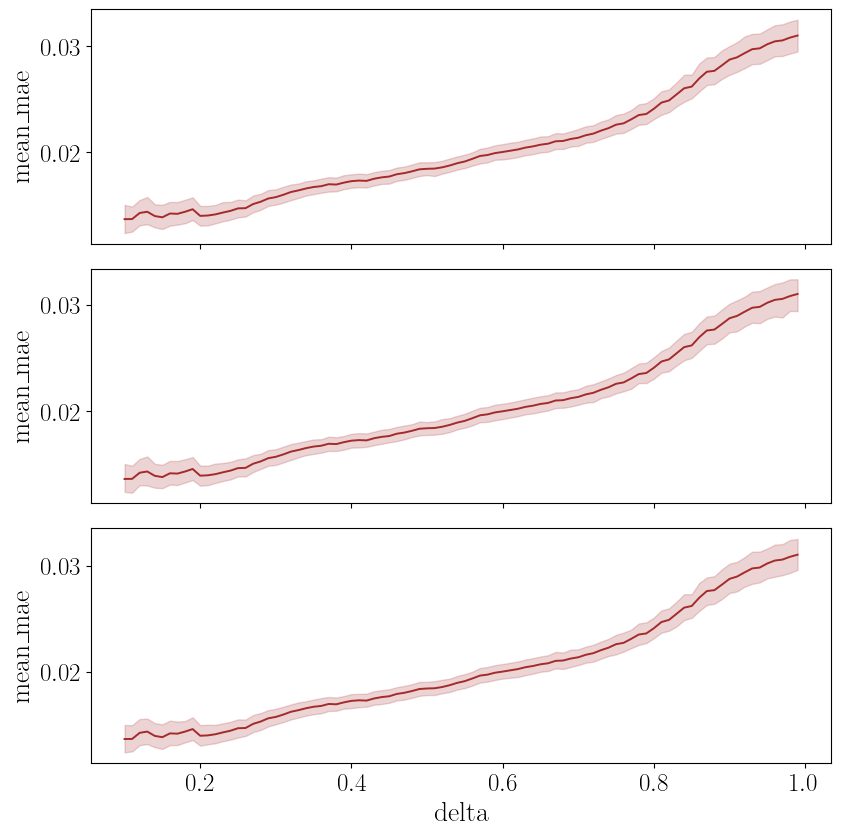

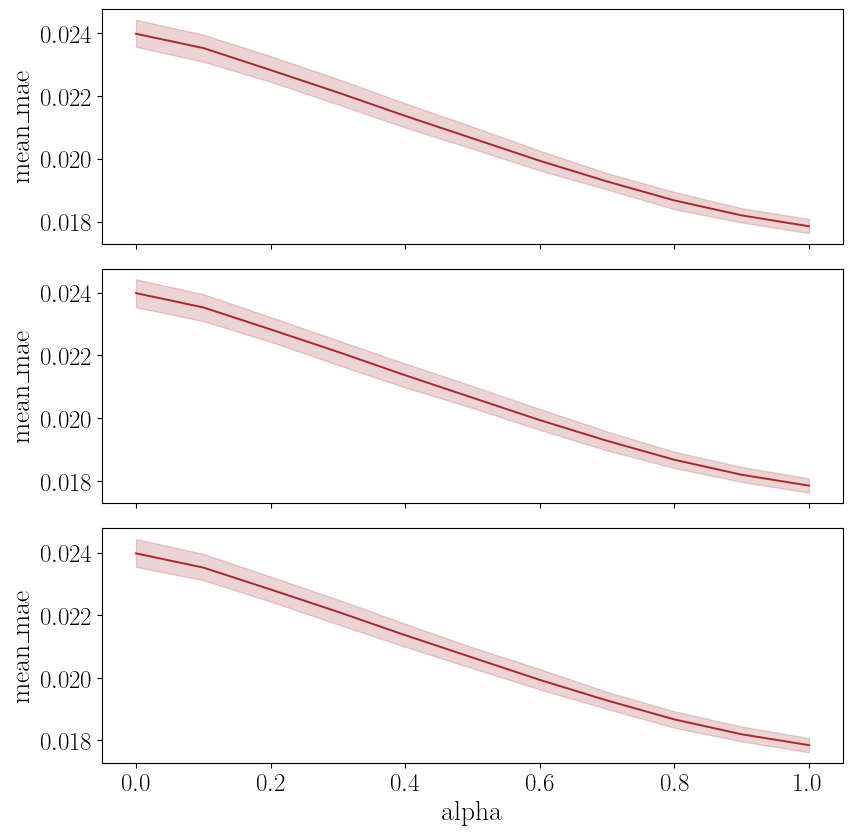

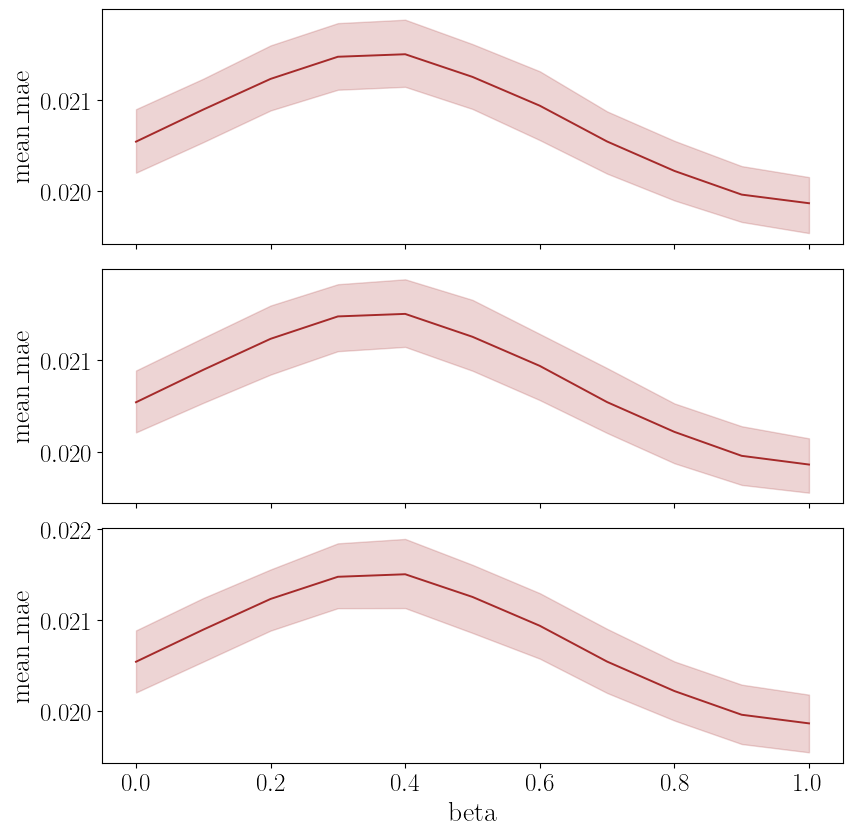

In [669]:
y_label = 'mean_mae'

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[2])

plt.show()

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[2])

plt.show()

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[2])

plt.show()

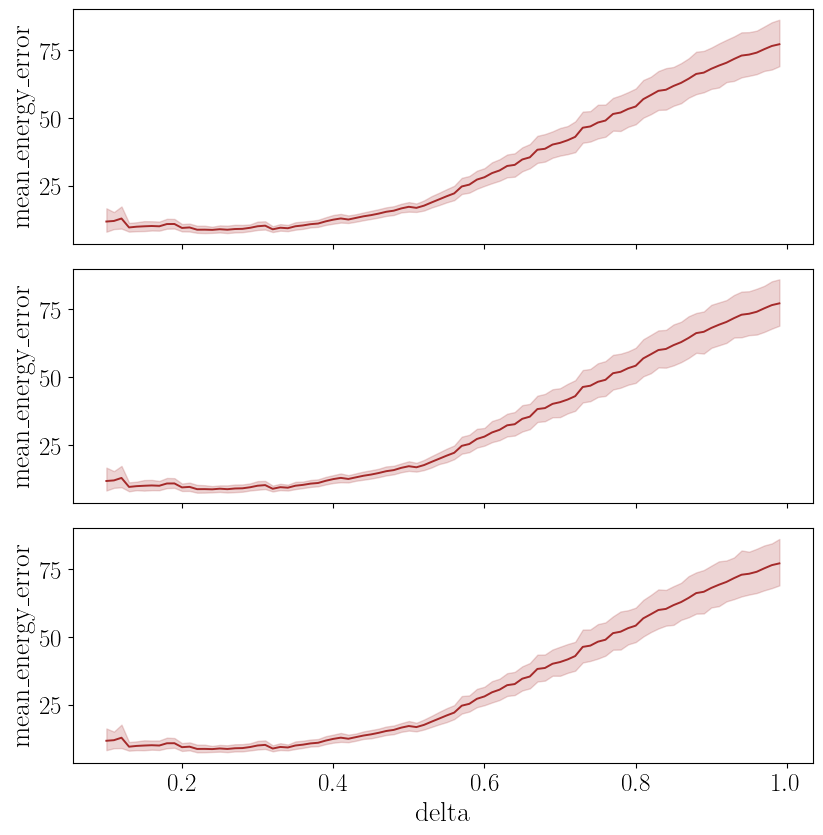

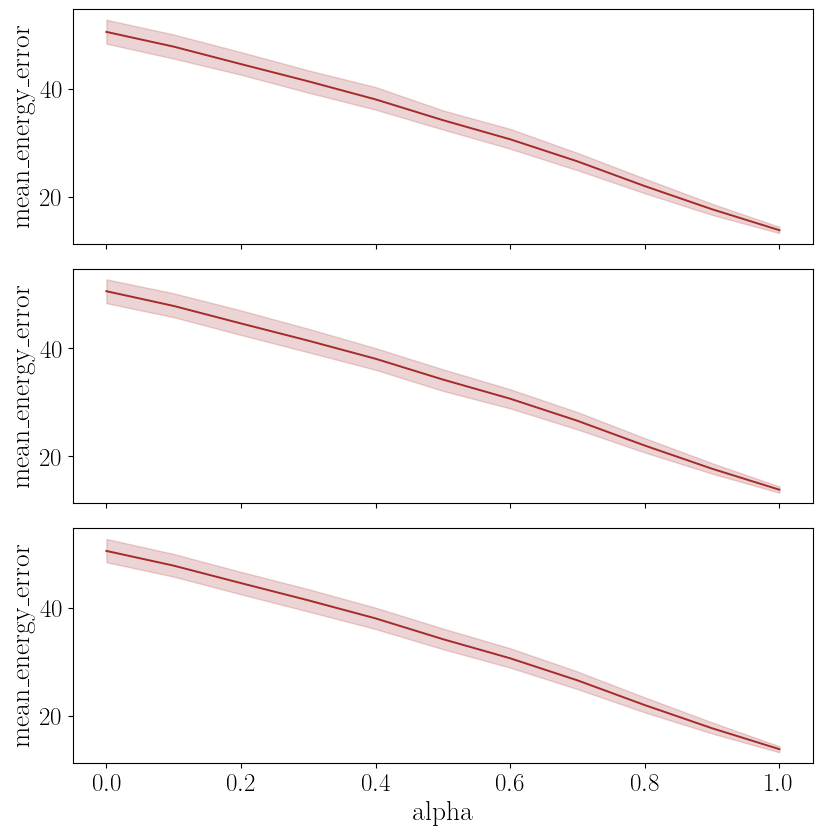

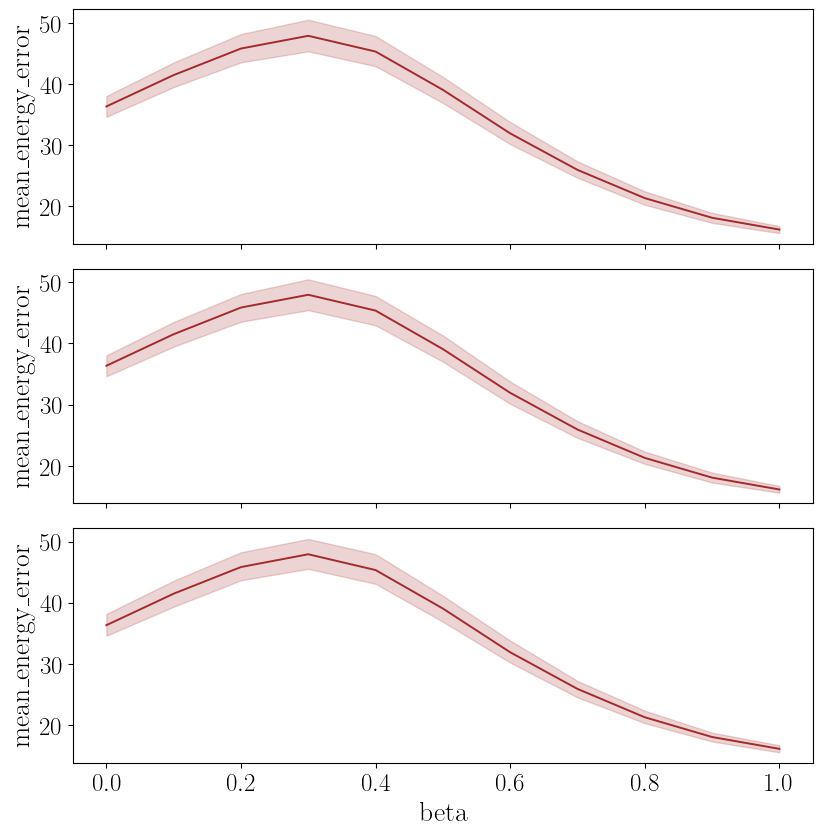

In [ ]:
y_label = 'mean_energy_error'

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[2])

plt.show()

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[2])

plt.show()

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[2])

plt.show()

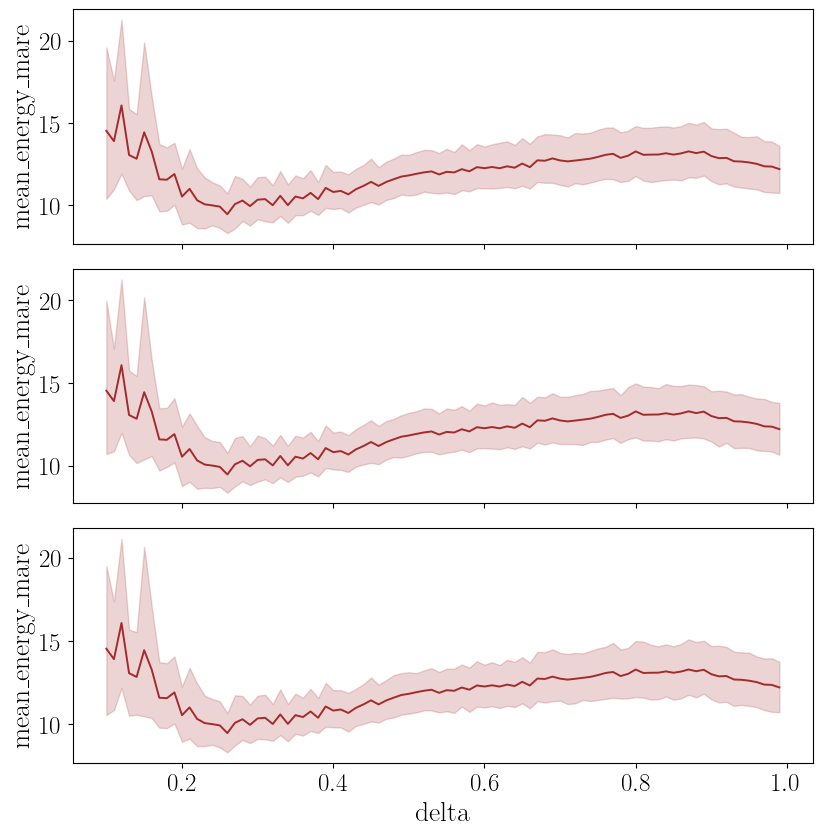

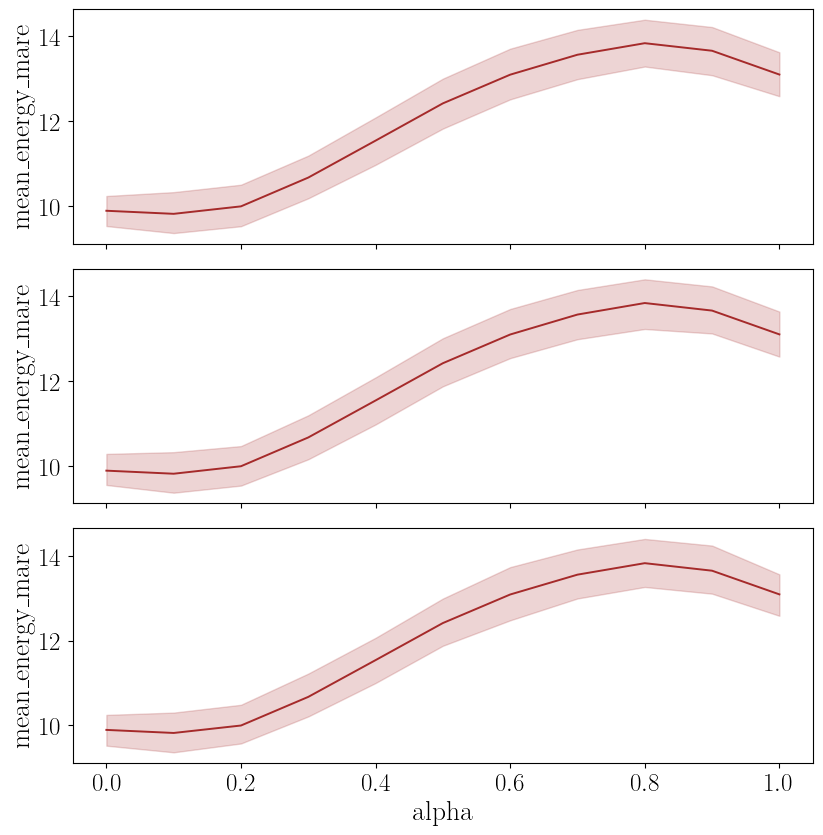

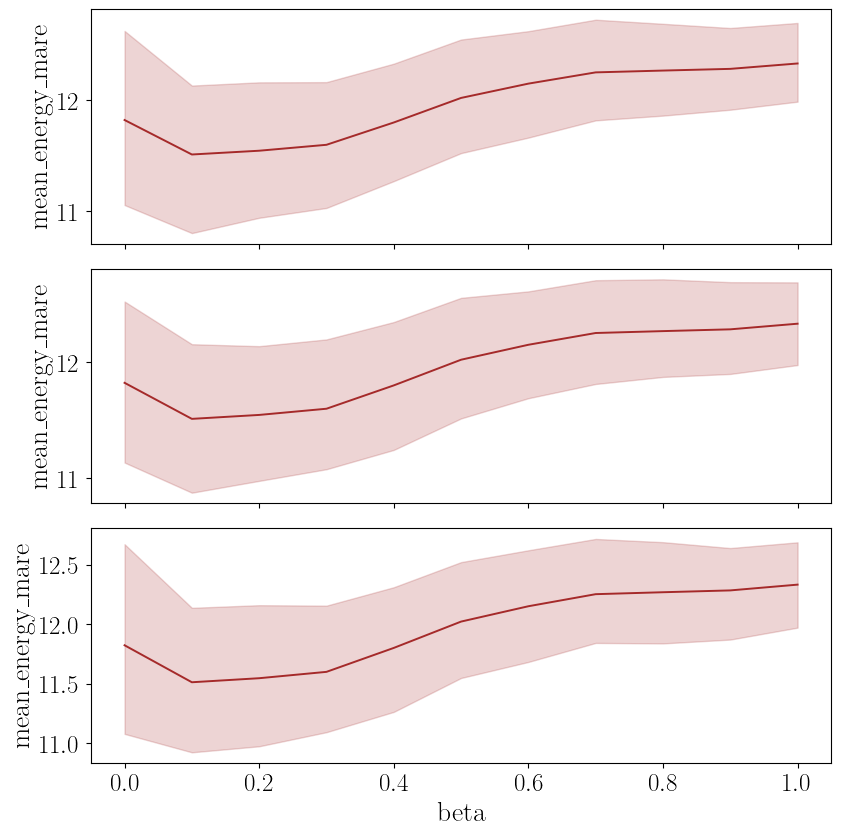

In [670]:
y_label = 'mean_energy_mare'

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='delta', y=y_label, ax=axes[2])

plt.show()

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='alpha', y=y_label, ax=axes[2])

plt.show()

fig, axes = plt.subplots(figsize=(8,8), nrows=3, sharex=True)
fig.tight_layout(pad=0.1)

sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[0])
sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[1])
sns.lineplot(df_clustering_results_considered, x='beta', y=y_label, ax=axes[2])

plt.show()

In [889]:
# array([  1,   2,   3,   4, 100, 101, 102, 103, 104, 105, 106, 108, 109,
#        110, 111, 112, 137])
dhns_ids_considered_no = [1, 2, 3, 4, 100, 101, 102, 103, 104, 105, 106, 109, 110, 111, 112, 122, 133, 137]
dhns_ids_considered_no = [1, 2, 3, 4, 100, 137]
df_clustering_results_considered = df_clustering_results_with_perfs[df_clustering_results_with_perfs['dhn_id'].isin(dhns_ids_considered_no)]
df_grouped_over_hyperparameters = df_clustering_results_considered.groupby(by=['delta', 'alpha', 'beta'], as_index=False).mean(numeric_only=True)

In [890]:
# Pareto font

# obj_1 = 'mean_energy_mare'
# obj_1 = 'mean_energy_mare'
obj_1 = 'mean_energy_error'
# obj_1 = 'total_energy_mare_per_loss'
obj_2 = 'Remaining_nodes'

In [891]:
# Parento font functions

# Has to be defined
def is_left_dominated_by_right_objsc_1(p1, p2, x_tolerence, y_tolerence): # if the x is to minimize and y is to maximize
    if ((p1[0] - p2[0]) > x_tolerence and (p1[1] - p2[1]) < -1* y_tolerence):
        return True
    elif p1[0] == p2[0] and (p1[1] - p2[1]) < -1* y_tolerence:
        return True
    elif (p1[0] - p2[0]) > x_tolerence and p1[1] == p2[1]:
        return True
    else:
        return False
    
def is_left_dominated_by_right_objsc_2(p1, p2, x_tolerence, y_tolerence): # if the both x and y are to minimize
    # if p2[0] <= p1[0] and p2[1] <= p1[0]: # 2 is better than 1
    #     return True
    if ((p1[0] - p2[0]) > x_tolerence and (p2[1] - p1[1]) < -1* y_tolerence):
        return True
    elif p1[0] == p2[0] and (p2[1] - p1[1]) < -1* y_tolerence:
        return True
    elif (p1[0] - p2[0]) > x_tolerence and p1[1] == p2[1]:
        return True
    else:
        return False

In [892]:
df_clustering_results_considered['dhn_id'].unique()

array([  1,   2,   3,   4, 100, 137])

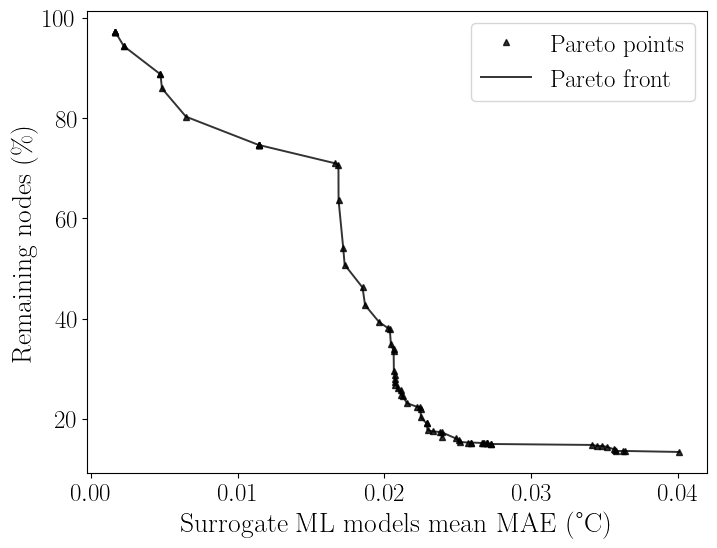

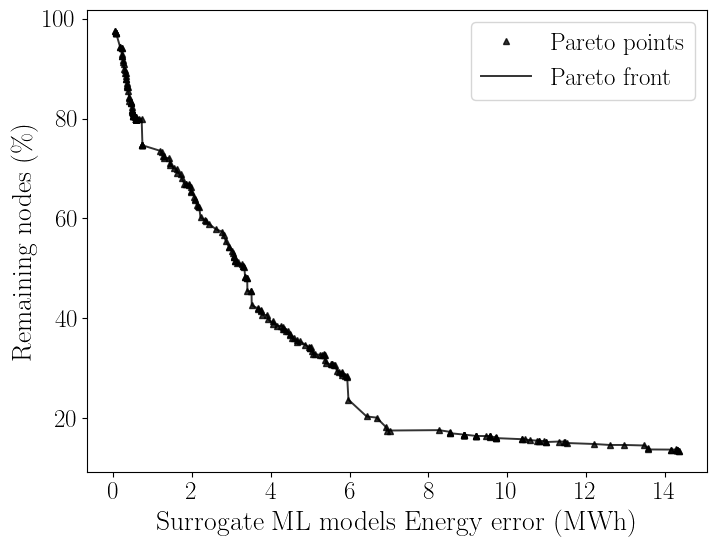

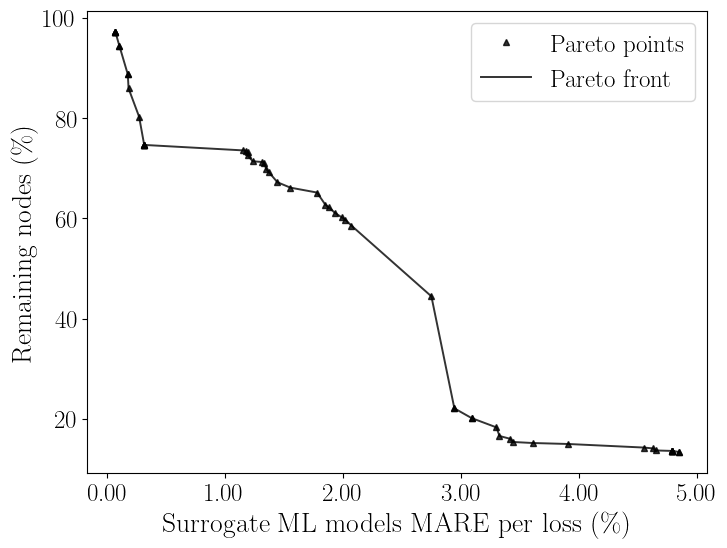

In [902]:
# points = df_averaged_over_the_dhns[[obj_1, obj_2, 'dhn_id']].to_numpy()
df_averaged_over_the_dhns = df_grouped_over_hyperparameters.groupby(by=['delta', 'alpha', 'beta'], as_index=False).mean(numeric_only=True)


# Pareto font with MAE and Size
obj_1 = 'mean_mae'
# points = df_averaged_over_the_dhns[[obj_1, obj_2, 'dhn_id']].to_numpy()
points = df_averaged_over_the_dhns[[obj_1, obj_2]].to_numpy()
points_3d = np.zeros(shape=(points.shape[0], points.shape[1]+1))
points_3d[:, 0:-1] = points
points_3d[:, 2] = df_averaged_over_the_dhns.index
parento_points = pareto_front(points_3d, is_left_dominated_by_right_objsc_2, x_threshold=0.00001, y_threshold=0.001)

indices_pareto_points = [int(i) for i in parento_points[:,2]]
# print(len(indices_pareto_points))
df_pareto_font = df_averaged_over_the_dhns.loc[indices_pareto_points]

# df_pareto_font_averaged = df_pareto_font.groupby(by=[obj_1, obj_2], as_index=False).mean(numeric_only=True)
df_pareto_font_averaged = df_pareto_font.copy()

from matplotlib.ticker import ScalarFormatter, FuncFormatter

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df_pareto_font_averaged[obj_1], df_pareto_font_averaged[obj_2], '^', c='black', alpha=0.8, label='Pareto points', markersize=4)
ax.plot(df_pareto_font_averaged[obj_1], df_pareto_font_averaged[obj_2], c='black', alpha=0.8, label='Pareto front')

# Set log-scaling on both axes
# ax.set_xscale('log')
# ax.set_yscale('log')

# Use ScalarFormatter to keep the original values
# ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

# Optionally, use FuncFormatter to format the labels as percentages
def percent_formatter(x, pos):
    return f'{x:.0f}%'

def mare_formatter(x, pos):
    return f'{x:.2f}%'

# ax.xaxis.set_major_formatter(FuncFormatter(mare_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set labels and legend
ax.set_ylabel("Remaining nodes (\\%)")
ax.set_xlabel("Surrogate ML models mean MAE (°C)")
ax.legend()

# ax.legend()
# ax.set_ylabel("Remaining nodes (\\%)")
# ax.set_xlabel("Energy error (\\%)")
# ax.set_xlim([-0.01, 0.2])
# plt.savefig(os.path.join('article_results', 'pareto_font_points_hyperparameters_log_x.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Pareto font with MAE and Size
obj_1 = 'mean_energy_error'
# points = df_averaged_over_the_dhns[[obj_1, obj_2, 'dhn_id']].to_numpy()
points = df_averaged_over_the_dhns[[obj_1, obj_2]].to_numpy()
points_3d = np.zeros(shape=(points.shape[0], points.shape[1]+1))
points_3d[:, 0:-1] = points
points_3d[:, 2] = df_averaged_over_the_dhns.index
parento_points = pareto_front(points_3d, is_left_dominated_by_right_objsc_2, x_threshold=0.001, y_threshold=0.1)

indices_pareto_points = [int(i) for i in parento_points[:,2]]
# print(len(indices_pareto_points))
df_pareto_font = df_averaged_over_the_dhns.loc[indices_pareto_points]

# df_pareto_font_averaged = df_pareto_font.groupby(by=[obj_1, obj_2], as_index=False).mean(numeric_only=True)
df_pareto_font_averaged = df_pareto_font.copy()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df_pareto_font_averaged[obj_1], df_pareto_font_averaged[obj_2], '^', c='black', alpha=0.8, label='Pareto points', markersize=4)
ax.plot(df_pareto_font_averaged[obj_1], df_pareto_font_averaged[obj_2], c='black', alpha=0.8, label='Pareto front')


# Set log-scaling on both axes
# ax.set_xscale('log')
# ax.set_yscale('log')

# Use ScalarFormatter to keep the original values
# ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

# ax.xaxis.set_major_formatter(FuncFormatter(mare_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set labels and legend
ax.set_ylabel("Remaining nodes (\\%)")
ax.set_xlabel("Surrogate ML models Energy error (MWh)")
ax.legend()

plt.show()

# Pareto font with MAE and Size
obj_1 = 'mean_energy_mare'
# points = df_averaged_over_the_dhns[[obj_1, obj_2, 'dhn_id']].to_numpy()
points = df_averaged_over_the_dhns[[obj_1, obj_2]].to_numpy()
points_3d = np.zeros(shape=(points.shape[0], points.shape[1]+1))
points_3d[:, 0:-1] = points
points_3d[:, 2] = df_averaged_over_the_dhns.index
parento_points = pareto_front(points_3d, is_left_dominated_by_right_objsc_2, x_threshold=0.0001, y_threshold=0.0001)

indices_pareto_points = [int(i) for i in parento_points[:,2]]
# print(len(indices_pareto_points))
df_pareto_font = df_averaged_over_the_dhns.loc[indices_pareto_points]

# df_pareto_font_averaged = df_pareto_font.groupby(by=[obj_1, obj_2], as_index=False).mean(numeric_only=True)
df_pareto_font_averaged = df_pareto_font.copy()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df_pareto_font_averaged[obj_1], df_pareto_font_averaged[obj_2], '^', c='black', alpha=0.8, label='Pareto points', markersize=4)
ax.plot(df_pareto_font_averaged[obj_1], df_pareto_font_averaged[obj_2], c='black', alpha=0.8, label='Pareto front')


# Set log-scaling on both axes
# ax.set_xscale('log')
# ax.set_yscale('log')

# Use ScalarFormatter to keep the original values
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

ax.xaxis.set_major_formatter(FuncFormatter(mare_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set labels and legend
ax.set_ylabel("Remaining nodes (\\%)")
ax.set_xlabel("Surrogate ML models MARE per loss (\\%)")
ax.legend()

plt.show()

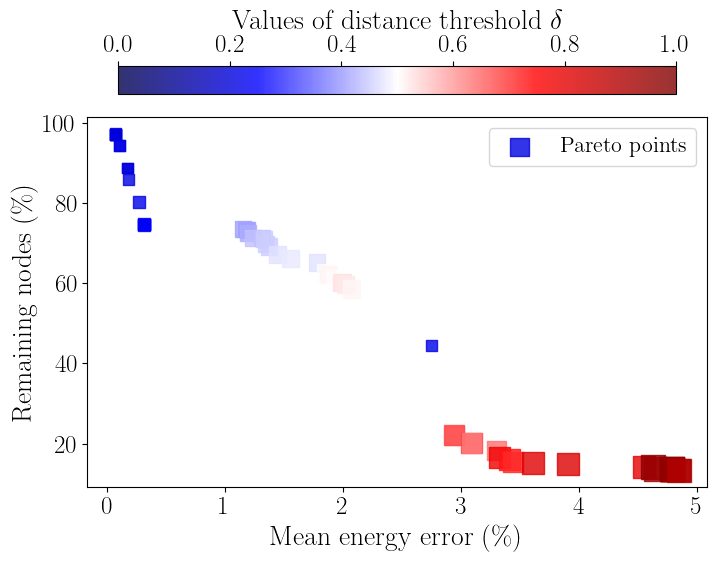

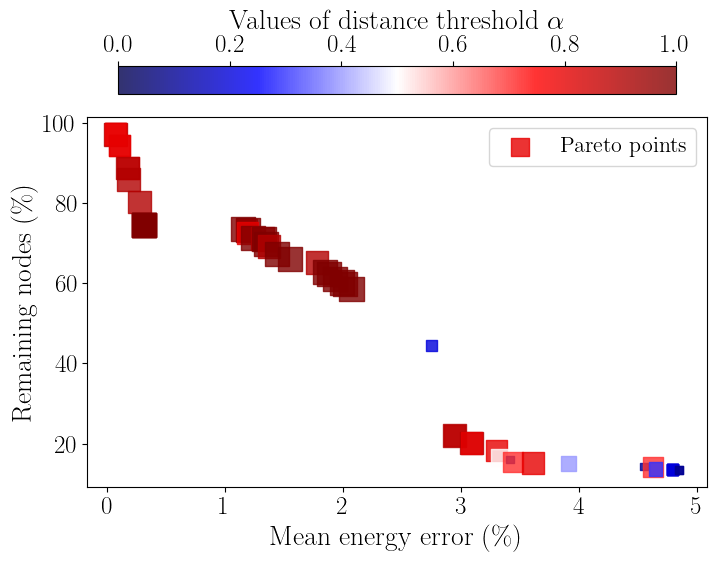

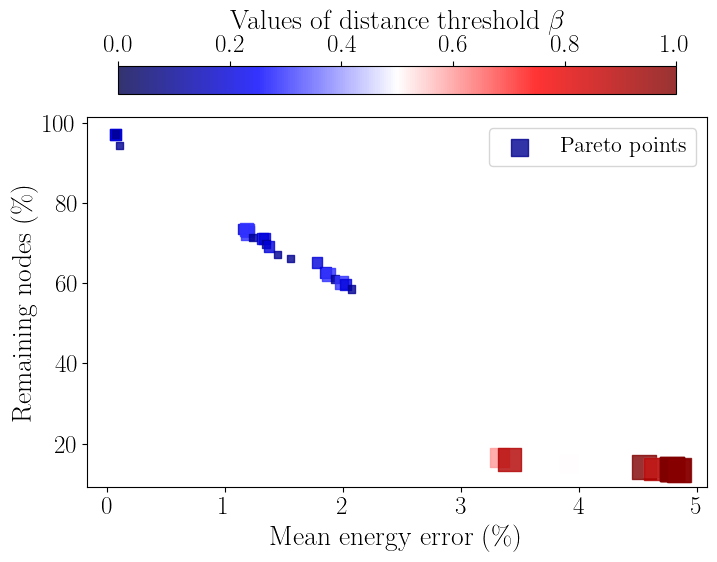

In [903]:
# Values of delta on the pareto fonts 

fig, ax = plt.subplots(figsize=(8,6))

# Without post processing
z = df_pareto_font_averaged['delta']
x = df_pareto_font_averaged[obj_1]
y = df_pareto_font_averaged[obj_2]
sizes = z / np.max(z) * 300  # Scale sizes for better visualization
scatter = ax.scatter(x, y, s=sizes, c=z, marker='s', cmap='seismic', alpha=0.8, label='Pareto points', vmin=0, vmax=1)

# Figures treatement
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', shrink=0.9,  location='top')
cbar.set_label(r"Values of distance threshold $\mathbf{\delta}$")
# ax.legend()

# ax.set_xscale('log')
# ax.set_yscale('log')

# Format y-axis as percentage
def percent_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set labels and legend
ax.set_ylabel("Remaining nodes (\\%)")
ax.set_xlabel("Mean energy error (\\%)")
ax.legend(loc='best', prop={'size': 16})

# Saving
# plt.savefig(os.path.join('article_results', 'effect_delta.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Values of delta on the pareto fonts 

fig, ax = plt.subplots(figsize=(8,6))

# Without post processing
z = df_pareto_font_averaged['alpha']
x = df_pareto_font_averaged[obj_1]
y = df_pareto_font_averaged[obj_2]
sizes = z / np.max(z) * 300  # Scale sizes for better visualization
scatter = ax.scatter(x, y, s=sizes, c=z, marker='s', cmap='seismic', alpha=0.8, label='Pareto points', vmin=0, vmax=1)

# Figures treatement
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', shrink=0.9,  location='top')
cbar.set_label(r"Values of distance threshold $\mathbf{\alpha}$")
# ax.legend()

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set labels and legend
ax.set_ylabel("Remaining nodes (\\%)")
ax.set_xlabel("Mean energy error (\\%)")
ax.legend(loc='best', prop={'size': 16})

# Saving
# plt.savefig(os.path.join('article_results', 'effect_delta.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

# Values of delta on the pareto fonts 

fig, ax = plt.subplots(figsize=(8,6))

# Without post processing
z = df_pareto_font_averaged['beta']
x = df_pareto_font_averaged[obj_1]
y = df_pareto_font_averaged[obj_2]
sizes = z / np.max(z) * 300  # Scale sizes for better visualization
scatter = ax.scatter(x, y, s=sizes, c=z, marker='s', cmap='seismic', alpha=0.8, label='Pareto points', vmin=0, vmax=1)

# Figures treatement
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', shrink=0.9,  location='top')
cbar.set_label(r"Values of distance threshold $\mathbf{\beta}$")
# ax.legend()

# ax.set_xscale('log')
# ax.set_yscale('log')

# Format y-axis as percentage
def percent_formatter(x, pos):
    return f'{x:.0f}%'

ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set labels and legend
ax.set_ylabel("Remaining nodes (\\%)")
ax.set_xlabel("Mean energy error (\\%)")
ax.legend(loc='best', prop={'size': 16})

# Saving
# plt.savefig(os.path.join('article_results', 'effect_delta.pdf'), format='pdf', dpi='figure', bbox_inches='tight')
plt.show()

R-squared (LR model) value: 0.9613063238997557
LR model coefficient: 
[[ 1.1999217  -0.4274725  -0.25456979]
 [-1.29296546  0.49304639  0.55189245]] 
	with intercept = [0.18929231 0.71156287]

LR model coefficient relative contributions: 
[[ 57.93207229 -20.63831999 -12.29059803]
 [-42.39971743  16.16827986  18.09799616]] 
	with intercept = [ 7.72671858 15.90940387]
(57, 10)
R-squared (Hyper ellipse model) value: 0.583636734201306
Hyper ellipse model coefficient: 
[[ 0.         -0.34224669  0.33227496  0.46141785]
 [ 0.          0.32053033  0.06841442 -0.34655059]] 
	with intercept = [0.52119173 0.40726579]
['delta' 'alpha' 'beta']


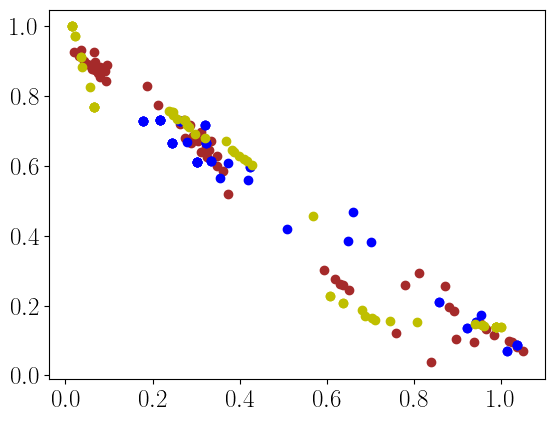

In [904]:
# Linear regression on the pareto font

X = df_pareto_font_averaged[['delta', 'alpha', 'beta']]
Y = df_pareto_font_averaged[[obj_1, obj_2]]
Y_norm = Y / Y.max()
# Y_norm = Y
X_norm = X / X.max()
# X_norm = X

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures as poly

model = LinearRegression(fit_intercept=True,)
# Train the model
model.fit(X_norm, Y_norm)

# Evaluate the model
r2_score = model.score(X_norm, Y_norm)
print(f"R-squared (LR model) value: {r2_score}")
print(f"LR model coefficient: \n{model.coef_} \n\twith intercept = {model.intercept_}")
y_predicted_lr = model.predict(X)
# Contributions relative
coefficients = model.coef_
intercepts = model.intercept_
coefficients_relative = 100 * coefficients / (np.sum(np.abs(coefficients), axis=1).reshape(2,1) + np.abs(intercepts).reshape(2,1))
intercepts_relative = 100 * intercepts / np.sum(np.abs(coefficients) + np.abs(intercepts).reshape(2,1), axis=1).reshape(2,)
print(f"\nLR model coefficient relative contributions: \n{coefficients_relative} \n\twith intercept = {intercepts_relative}")


poly_feat = poly(2, interaction_only=False)
X_norm_deg_2 = poly_feat.fit_transform(X_norm)
print(X_norm_deg_2.shape)
X_norm_deg_only_power_2 = X_norm_deg_2[:,[0,7,8,9]]
model_poly = LinearRegression(fit_intercept=True)
model_poly.fit(X_norm_deg_only_power_2, Y_norm)
r2_score = model_poly.score(X_norm_deg_only_power_2, Y_norm)
print(f"R-squared (Hyper ellipse model) value: {r2_score}")
print(f"Hyper ellipse model coefficient: \n{model_poly.coef_} \n\twith intercept = {model_poly.intercept_}")

y_poly_predicted = model_poly.predict(X_norm_deg_only_power_2)
y_lr_predicted = model.predict(X_norm)

plt.scatter(y_lr_predicted[:,0], y_lr_predicted[:,1])
plt.scatter(y_poly_predicted[:,0], y_poly_predicted[:,1])
plt.scatter(Y_norm[obj_1], Y_norm[obj_2])
print(poly_feat.feature_names_in_)

Strat 1 ----- 
 mean_energy_mare     0.071774
Remaining_nodes     97.183099
delta                0.210000
alpha                0.800000
beta                 0.100000
Name: 1047, dtype: float64
Strat 2 ----- 
 mean_energy_mare     4.846129
Remaining_nodes     13.402072
delta                0.840000
alpha                0.100000
beta                 0.900000
Name: 8599, dtype: float64
Strat 3 ----- 
 mean_energy_mare     1.990408
Remaining_nodes     60.187653
delta                0.530000
alpha                1.000000
beta                 0.300000
Name: 4941, dtype: float64


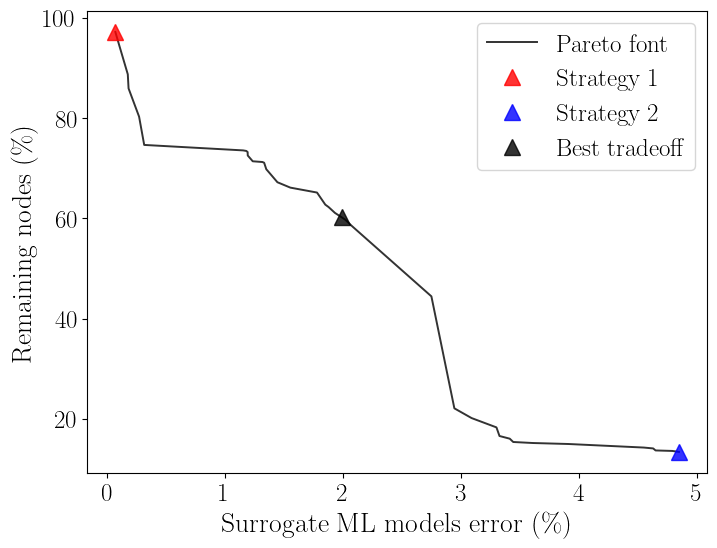

In [905]:
## Identification of strategies and test on new DHNs

# 1st strategy, I want the most precise clusters
pareto_points_extreme_1 = df_pareto_font_averaged.sort_values(by=obj_1).iloc[0]
print('Strat 1 ----- \n', pareto_points_extreme_1[[obj_1, obj_2, 'delta', 'alpha', 'beta']])

# 2nd strategy, I want the most reduction clusters
pareto_points_extreme_2 = df_pareto_font_averaged.sort_values(by=obj_2).iloc[0]
print('Strat 2 ----- \n', pareto_points_extreme_2[[obj_1, obj_2, 'delta', 'alpha', 'beta']])

# 3rd strategy, I want the best tradeoff
# Using the weighting factor approach, w1 * obj_1 + (1-w1) * obj_2
df_pareto_font_copy = df_pareto_font_averaged.copy()
def get_normalized(values):
    return (values - np.min(values))/(np.max(values) - np.min(values))
# df_pareto_font_copy['weighted_objective'] = 0.5*(get_normalized(df_pareto_font_copy[obj_1])) + 0.5*(get_normalized(df_pareto_font_copy[obj_2]))
df_pareto_font_copy['weighted_objective'] = np.abs(df_pareto_font_copy[obj_2] - 60)
# df_pareto_font_copy['weighted_objective_from_lr'] = 0.5 * get_normalized(y_predicted_lr[:,0]) + 0.5 * get_normalized(y_predicted_lr[:,1]) 
pareto_points_best_tradeoff = df_pareto_font_copy.sort_values(by='weighted_objective').iloc[0]
# pareto_points_best_tradeoff = df_pareto_font_copy[df_pareto_font_copy].iloc[0]
# pareto_points_best_tradeoff_lr = df_pareto_font_copy.sort_values(by='weighted_objective_from_lr').iloc[0]
print('Strat 3 ----- \n', pareto_points_best_tradeoff[[obj_1, obj_2, 'delta', 'alpha', 'beta']])
# using weighting factor approach
fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(df_pareto_font[obj_1], df_pareto_font[obj_2], '^', c='black', alpha=0.8, label='Pareto points')
ax.plot(df_pareto_font_averaged[obj_1], df_pareto_font_averaged[obj_2], c='black', alpha=0.8, label='Pareto font')
ax.plot(pareto_points_extreme_1[obj_1], pareto_points_extreme_1[obj_2], '^', c='red', alpha=.8, markersize=12, label='Strategy 1')
ax.plot(pareto_points_extreme_2[obj_1], pareto_points_extreme_2[obj_2], '^', c='blue', alpha=.8, markersize=12, label='Strategy 2')
ax.plot(pareto_points_best_tradeoff[obj_1], pareto_points_best_tradeoff[obj_2], '^', c='black', alpha=.8, markersize=12, label='Best tradeoff')
# ax.plot(pareto_points_best_tradeoff_lr[obj_1], pareto_points_best_tradeoff_lr[obj_2], 'v', c='black', alpha=.8, markersize=12)
# ax.plot(y_predicted_lr[:, 0], y_predicted_lr[:, 1], '*', c='black', alpha=.8, markersize=12)
ax.legend()
ax.set_xlabel('Surrogate ML models error (\\%)')
ax.set_ylabel("Remaining nodes (\\%)")
# ax.set_title(r"Effect of hyperparameters ($\delta$, $\alpha$, $\gamma$)" + '\n clustering results over 14 DHNs')
plt.show()

In [888]:
# Identification clusters for the DHN 108

df_clustering_results[(df_clustering_results['dhn_id'] == 1) & (df_clustering_results['delta'] == 0.91)  & (df_clustering_results['alpha'] == 1.0)  & (df_clustering_results['beta'] == 1.0)]

,mean_size,mean_cluster_has_loop,mean_density,mean_internal_degree,mean_scaled_density,mean_nodes_mean_internal_indegree,mean_nodes_sum_internal_indegree,mean_nodes_max_internal_indegree,mean_nodes_mean_internal_outdegree,mean_nodes_sum_internal_outdegree,...,Total_clustered_nodes,List_clusters,delta,alpha,beta,dhn_id,clusters_labels,total_cut_sizes,Total_clustered_nodes_percent,Remaining_nodes
81,2.45,0.0,0.429167,1.45,1.0,0.570833,1.45,1.0,0.570833,1.45,...,49.0,"[[3, 5], [4, 35], [9, 10], [13, 15, 23], [14, ...",0.91,1.0,1.0,1,[37 32 17 36 17 34 33 38 3 3 30 29 6 13 6 ...,32.0,69.014085,30.985915
